In [1]:
# Group number: 14
# Veerle Schepers s1023102
# Angeliki-Ilektra Karaiskou, s1029746
# Lei Xiaoxuan, s1025681
# Parsia Basimfar : s1022274

In this assignment you will learn how to apply the REINFORCE algorithm within the OpenAI Gym environment. Make sure OpenAI gym is installed on your machine. Now let's import some relevant packages.

In [2]:
import gym
from gym import wrappers, logger
import matplotlib.pyplot as plt
import tqdm
import numpy as np
from chainer import Chain
import chainer.links as L
import chainer.functions as F
from chainer.optimizers import Adam
from chainer import Variable

%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


We will make use of the classic CartPole environment provided by OpenAI Gym. Figure out what the details of this environment are.

In [3]:
env_id = 'CartPole-v0'

# You can set the level to logger.DEBUG or logger.WARN if you want to change the amount of output.
logger.set_level(logger.INFO)

Let's define a baseline agent which just emits random actions.

In [4]:
class RandomAgent(object):
    """The world's simplest agent!"""

    def __init__(self, action_space):
        self.action_space = action_space

    def act(self, observation, reward, done):
        return self.action_space.sample()


Let's run the agent on the environment.

In [5]:
env = gym.make(env_id)
env.seed(0)
agent = RandomAgent(env.action_space)

episode_count = 2000
done = False
reward = 0
    
R0 = np.zeros(episode_count)
for i in tqdm.trange(episode_count):

    ob = env.reset()

    while True:

        action = agent.act(ob, reward, done)
        ob, reward, done, _ = env.step(action)

        R0[i] += reward

        if done:
            break

# Close the env and write monitor result info to disk
env.close()

INFO: Making new env: CartPole-v0


C:\ProgramData\Anaconda3\lib\site-packages\gym\envs\registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)
100%|████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 3282.71it/s]


Let's create the REINFORCE agent. We assume that the policy is computed using an MLP with a softmax output.

In [6]:
class MLP(Chain):
    """Multilayer perceptron"""

    def __init__(self, n_output=1, n_hidden=5):
        super(MLP, self).__init__(l1=L.Linear(None, n_hidden), l2=L.Linear(n_hidden, n_output))

    def __call__(self, x):
        return self.l2(F.relu(self.l1(x)))

1: A skeleton for the REINFORCEAgent is given. Implement the compute_loss and compute_score functions. 

In [7]:
class REINFORCEAgent(object):
    """Agent trained using REINFORCE"""

    def __init__(self, action_space, model, optimizer=Adam()):

        self.action_space = action_space

        self.model = model

        self.optimizer = optimizer
        self.optimizer.setup(self.model)

        # monitor score and reward
        self.rewards = []
        self.scores = []


    def act(self, observation, reward, done):

        # linear outputs reflecting the log action probabilities and the value
        policy = self.model(Variable(np.atleast_2d(np.asarray(observation, 'float32'))))
        
        # generate action according to policy
        p = F.softmax(policy).data

        # normalize p in case tiny floating precision problems occur
        row_sums = p.sum(axis=1)
        p /= row_sums[:, np.newaxis]

        action = np.asarray([np.random.choice(p.shape[1], None, True, p[0])])

        return action, policy


    def compute_loss(self):
        """
        Return loss for this episode based on computed scores and accumulated rewards
        """
        Q_hat = 0
        loss = 0
        
        """
        for i in range(len(self.rewards)):
            Q_hat = np.asarray(self.rewards[i:])
            Q_hat = np.sum(Q_hat)
            loss -= F.sum(self.scores[i] * Q_hat)
        """
        
        for i in reversed(range(len(self.rewards))):            
            Q_hat += self.rewards[i] # the summation of Q_hat is happening backwards (from the last element to the 1st)
            loss -= F.sum(self.scores[i] * Q_hat)
            # It goes backward
            
        return loss

    def compute_score(self, action, policy):
        """
        Computes score

        Args:
            action (int):
            policy:

        Returns:
            score
        """
        
        p = F.softmax(policy) # to become normalize 
        score = F.log(p[:,action[0]]) # use the action the agent did 
        
        return score


Now we run the REINFORCE agent on the CartPole environment. Note that we update the agent after each episode for simplicity.

In [8]:
env = gym.make(env_id)
env.seed(0)

network = MLP(n_output=env.action_space.n, n_hidden=3)
agent = REINFORCEAgent(env.action_space, network, optimizer=Adam())

episode_count = 2000
done = False
reward = 0
    
R = np.zeros(episode_count)
for i in tqdm.trange(episode_count):

    
    ob = env.reset()
    
    loss = 0


    while True:
        action, policy = agent.act(ob, reward, done)
        ob, reward, done, _ = env.step(action[0])
        # get reward associated with taking the previous action in the previous state
        agent.rewards.append(reward)

        R[i] += reward

        # recompute score function: grad_theta log pi_theta (s_t, a_t) * v_t
        agent.scores.append(agent.compute_score(action, policy))
            
        # we learn at the end of each episode
        if done:
            print("Total Reward = \n", R[i])
            loss += agent.compute_loss()

            agent.model.cleargrads()
            loss.backward()
            loss.unchain_backward()
            agent.optimizer.update()
            agent.rewards[:] = [] # empty the reward list after each episode so the learning doesn't take into account previous rewards
            agent.scores[:] = [] # empty the score list after each episode so the learning doesn't take into account previous scores

            break

INFO: Making new env: CartPole-v0


C:\ProgramData\Anaconda3\lib\site-packages\gym\envs\registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)
  0%|                                                                                         | 0/2000 [00:00<?, ?it/s]

Total Reward = 
 19.0
Total Reward = 
 10.0
Total Reward = 
 28.0


  0%|                                                                                 | 3/2000 [00:00<01:42, 19.58it/s]

Total Reward = 
 11.0
Total Reward = 
 10.0
Total Reward = 
 22.0


  0%|▏                                                                                | 6/2000 [00:00<01:45, 18.92it/s]

Total Reward = 
 24.0
Total Reward = 
 23.0


  0%|▎                                                                                | 8/2000 [00:00<01:55, 17.25it/s]

Total Reward = 
 17.0
Total Reward = 
 17.0
Total Reward = 
 26.0


  1%|▍                                                                               | 11/2000 [00:00<01:54, 17.40it/s]

Total Reward = 
 21.0
Total Reward = 
 9.0
Total Reward = 
 16.0


  1%|▌                                                                               | 14/2000 [00:00<01:48, 18.37it/s]

Total Reward = 
 14.0
Total Reward = 
 46.0


  1%|▋                                                                               | 16/2000 [00:00<02:20, 14.16it/s]

Total Reward = 
 15.0
Total Reward = 
 19.0


  1%|▋                                                                               | 18/2000 [00:01<02:08, 15.48it/s]

Total Reward = 
 23.0
Total Reward = 
 23.0


  1%|▊                                                                               | 20/2000 [00:01<02:03, 16.01it/s]

Total Reward = 
 9.0
Total Reward = 
 30.0


  1%|▉                                                                               | 22/2000 [00:01<02:01, 16.29it/s]

Total Reward = 
 16.0
Total Reward = 
 33.0


  1%|▉                                                                               | 24/2000 [00:01<02:09, 15.24it/s]

Total Reward = 
 12.0
Total Reward = 
 30.0


  1%|█                                                                               | 26/2000 [00:01<02:06, 15.61it/s]

Total Reward = 
 23.0
Total Reward = 
 21.0


  1%|█                                                                               | 28/2000 [00:01<02:08, 15.29it/s]

Total Reward = 
 20.0
Total Reward = 
 12.0
Total Reward = 
 11.0


  2%|█▏                                                                              | 31/2000 [00:01<01:51, 17.71it/s]

Total Reward = 
 31.0
Total Reward = 
 28.0


  2%|█▎                                                                              | 33/2000 [00:02<02:05, 15.71it/s]

Total Reward = 
 26.0
Total Reward = 
 18.0


  2%|█▍                                                                              | 35/2000 [00:02<02:03, 15.95it/s]

Total Reward = 
 13.0
Total Reward = 
 17.0
Total Reward = 
 27.0


  2%|█▌                                                                              | 38/2000 [00:02<01:54, 17.07it/s]

Total Reward = 
 11.0
Total Reward = 
 33.0


  2%|█▌                                                                              | 40/2000 [00:02<02:01, 16.09it/s]

Total Reward = 
 27.0
Total Reward = 
 40.0


  2%|█▋                                                                              | 42/2000 [00:02<02:43, 11.97it/s]

Total Reward = 
 15.0
Total Reward = 
 51.0


  2%|█▊                                                                              | 44/2000 [00:02<02:42, 12.02it/s]

Total Reward = 
 16.0
Total Reward = 
 13.0
Total Reward = 
 13.0


  2%|█▉                                                                              | 47/2000 [00:02<02:15, 14.42it/s]

Total Reward = 
 21.0
Total Reward = 
 43.0


  2%|█▉                                                                              | 49/2000 [00:03<02:19, 14.02it/s]

Total Reward = 
 12.0
Total Reward = 
 18.0
Total Reward = 
 35.0


  3%|██                                                                              | 52/2000 [00:03<02:05, 15.49it/s]

Total Reward = 
 19.0
Total Reward = 
 10.0
Total Reward = 
 22.0


  3%|██▏                                                                             | 55/2000 [00:03<01:51, 17.49it/s]

Total Reward = 
 13.0
Total Reward = 
 21.0
Total Reward = 
 35.0


  3%|██▎                                                                             | 58/2000 [00:03<01:46, 18.18it/s]

Total Reward = 
 53.0
Total Reward = 
 11.0


  3%|██▍                                                                             | 60/2000 [00:03<01:55, 16.77it/s]

Total Reward = 
 13.0
Total Reward = 
 57.0


  3%|██▍                                                                             | 62/2000 [00:03<02:04, 15.57it/s]

Total Reward = 
 19.0
Total Reward = 
 12.0
Total Reward = 
 18.0


  3%|██▌                                                                             | 65/2000 [00:03<01:49, 17.74it/s]

Total Reward = 
 24.0
Total Reward = 
 18.0
Total Reward = 
 38.0


  3%|██▋                                                                             | 68/2000 [00:04<01:49, 17.65it/s]

Total Reward = 
 12.0
Total Reward = 
 12.0
Total Reward = 
 12.0
Total Reward = 
 36.0


  4%|██▉                                                                             | 72/2000 [00:04<01:40, 19.25it/s]

Total Reward = 
 16.0
Total Reward = 
 13.0
Total Reward = 
 13.0


  4%|███                                                                             | 75/2000 [00:04<01:30, 21.39it/s]

Total Reward = 
 10.0
Total Reward = 
 16.0
Total Reward = 
 25.0


  4%|███                                                                             | 78/2000 [00:04<01:25, 22.36it/s]

Total Reward = 
 21.0
Total Reward = 
 16.0
Total Reward = 
 17.0


  4%|███▏                                                                            | 81/2000 [00:04<01:25, 22.42it/s]

Total Reward = 
 15.0
Total Reward = 
 67.0
Total Reward = 
 39.0


  4%|███▎                                                                            | 84/2000 [00:04<01:56, 16.47it/s]

Total Reward = 
 32.0
Total Reward = 
 16.0


  4%|███▍                                                                            | 86/2000 [00:05<01:52, 16.95it/s]

Total Reward = 
 37.0
Total Reward = 
 11.0


  4%|███▌                                                                            | 88/2000 [00:05<01:49, 17.49it/s]

Total Reward = 
 11.0
Total Reward = 
 16.0
Total Reward = 
 35.0


  5%|███▋                                                                            | 91/2000 [00:05<01:43, 18.41it/s]

Total Reward = 
 15.0
Total Reward = 
 19.0
Total Reward = 
 28.0


  5%|███▊                                                                            | 94/2000 [00:05<01:39, 19.15it/s]

Total Reward = 
 11.0
Total Reward = 
 11.0
Total Reward = 
 9.0
Total Reward = 
 19.0


  5%|███▉                                                                            | 98/2000 [00:05<01:26, 21.88it/s]

Total Reward = 
 14.0
Total Reward = 
 11.0
Total Reward = 
 30.0


  5%|███▉                                                                           | 101/2000 [00:05<01:24, 22.58it/s]

Total Reward = 
 17.0
Total Reward = 
 47.0
Total Reward = 
 32.0


  5%|████                                                                           | 104/2000 [00:05<01:38, 19.31it/s]

Total Reward = 
 14.0
Total Reward = 
 41.0
Total Reward = 
 32.0


  5%|████▏                                                                          | 107/2000 [00:06<01:44, 18.07it/s]

Total Reward = 
 27.0
Total Reward = 
 19.0


  5%|████▎                                                                          | 109/2000 [00:06<01:47, 17.58it/s]

Total Reward = 
 36.0
Total Reward = 
 25.0


  6%|████▍                                                                          | 111/2000 [00:06<01:52, 16.86it/s]

Total Reward = 
 11.0
Total Reward = 
 11.0
Total Reward = 
 29.0


  6%|████▌                                                                          | 114/2000 [00:06<01:40, 18.77it/s]

Total Reward = 
 13.0
Total Reward = 
 44.0
Total Reward = 
 12.0


  6%|████▌                                                                          | 117/2000 [00:06<01:38, 19.13it/s]

Total Reward = 
 19.0
Total Reward = 
 14.0
Total Reward = 
 14.0


  6%|████▋                                                                          | 120/2000 [00:06<01:29, 20.93it/s]

Total Reward = 
 15.0
Total Reward = 
 24.0
Total Reward = 
 21.0


  6%|████▊                                                                          | 123/2000 [00:06<01:29, 20.99it/s]

Total Reward = 
 18.0
Total Reward = 
 18.0
Total Reward = 
 73.0


  6%|████▉                                                                          | 126/2000 [00:07<01:48, 17.23it/s]

Total Reward = 
 16.0
Total Reward = 
 22.0


  6%|█████                                                                          | 128/2000 [00:07<01:53, 16.43it/s]

Total Reward = 
 32.0
Total Reward = 
 19.0


  6%|█████▏                                                                         | 130/2000 [00:07<02:22, 13.13it/s]

Total Reward = 
 15.0
Total Reward = 
 21.0


  7%|█████▏                                                                         | 132/2000 [00:07<02:40, 11.61it/s]

Total Reward = 
 25.0
Total Reward = 
 37.0


  7%|█████▎                                                                         | 134/2000 [00:07<03:04, 10.09it/s]

Total Reward = 
 11.0
Total Reward = 
 39.0


  7%|█████▎                                                                         | 136/2000 [00:08<03:14,  9.60it/s]

Total Reward = 
 17.0
Total Reward = 
 15.0


  7%|█████▍                                                                         | 138/2000 [00:08<02:56, 10.56it/s]

Total Reward = 
 15.0
Total Reward = 
 13.0


  7%|█████▌                                                                         | 140/2000 [00:08<02:51, 10.83it/s]

Total Reward = 
 11.0
Total Reward = 
 20.0


  7%|█████▌                                                                         | 142/2000 [00:08<02:41, 11.54it/s]

Total Reward = 
 23.0
Total Reward = 
 36.0


  7%|█████▋                                                                         | 144/2000 [00:08<02:39, 11.67it/s]

Total Reward = 
 13.0
Total Reward = 
 17.0
Total Reward = 
 12.0


  7%|█████▊                                                                         | 147/2000 [00:08<02:20, 13.18it/s]

Total Reward = 
 53.0
Total Reward = 
 15.0


  7%|█████▉                                                                         | 149/2000 [00:09<02:57, 10.42it/s]

Total Reward = 
 61.0
Total Reward = 
 45.0


  8%|█████▉                                                                         | 151/2000 [00:09<03:40,  8.39it/s]

Total Reward = 
 18.0
Total Reward = 
 12.0
Total Reward = 
 11.0


  8%|██████                                                                         | 154/2000 [00:09<02:56, 10.47it/s]

Total Reward = 
 11.0
Total Reward = 
 11.0
Total Reward = 
 22.0


  8%|██████▏                                                                        | 157/2000 [00:09<02:25, 12.65it/s]

Total Reward = 
 40.0
Total Reward = 
 13.0


  8%|██████▎                                                                        | 159/2000 [00:09<02:18, 13.30it/s]

Total Reward = 
 9.0
Total Reward = 
 20.0
Total Reward = 
 12.0


  8%|██████▍                                                                        | 162/2000 [00:10<01:57, 15.69it/s]

Total Reward = 
 39.0
Total Reward = 
 24.0


  8%|██████▍                                                                        | 164/2000 [00:10<01:59, 15.32it/s]

Total Reward = 
 37.0
Total Reward = 
 41.0


  8%|██████▌                                                                        | 166/2000 [00:10<02:10, 14.11it/s]

Total Reward = 
 11.0
Total Reward = 
 35.0


  8%|██████▋                                                                        | 168/2000 [00:10<02:01, 15.13it/s]

Total Reward = 
 14.0
Total Reward = 
 20.0
Total Reward = 
 23.0


  9%|██████▊                                                                        | 171/2000 [00:10<01:53, 16.16it/s]

Total Reward = 
 24.0
Total Reward = 
 17.0
Total Reward = 
 22.0


  9%|██████▊                                                                        | 174/2000 [00:10<01:46, 17.17it/s]

Total Reward = 
 15.0
Total Reward = 
 10.0
Total Reward = 
 14.0


  9%|██████▉                                                                        | 177/2000 [00:10<01:35, 19.06it/s]

Total Reward = 
 33.0
Total Reward = 
 11.0
Total Reward = 
 10.0


  9%|███████                                                                        | 180/2000 [00:11<01:31, 19.91it/s]

Total Reward = 
 18.0
Total Reward = 
 14.0
Total Reward = 
 32.0


  9%|███████▏                                                                       | 183/2000 [00:11<01:33, 19.52it/s]

Total Reward = 
 18.0
Total Reward = 
 18.0
Total Reward = 
 27.0


  9%|███████▎                                                                       | 186/2000 [00:11<01:36, 18.85it/s]

Total Reward = 
 25.0
Total Reward = 
 18.0


  9%|███████▍                                                                       | 188/2000 [00:11<01:36, 18.86it/s]

Total Reward = 
 14.0
Total Reward = 
 8.0
Total Reward = 
 17.0


 10%|███████▌                                                                       | 191/2000 [00:11<01:26, 21.00it/s]

Total Reward = 
 11.0
Total Reward = 
 20.0
Total Reward = 
 17.0


 10%|███████▋                                                                       | 194/2000 [00:11<01:21, 22.26it/s]

Total Reward = 
 14.0
Total Reward = 
 12.0
Total Reward = 
 34.0


 10%|███████▊                                                                       | 197/2000 [00:11<01:22, 21.86it/s]

Total Reward = 
 45.0
Total Reward = 
 15.0
Total Reward = 
 30.0


 10%|███████▉                                                                       | 200/2000 [00:12<01:33, 19.34it/s]

Total Reward = 
 18.0
Total Reward = 
 34.0
Total Reward = 
 10.0


 10%|████████                                                                       | 203/2000 [00:12<01:33, 19.27it/s]

Total Reward = 
 15.0
Total Reward = 
 23.0


 10%|████████                                                                       | 205/2000 [00:12<01:32, 19.38it/s]

Total Reward = 
 11.0
Total Reward = 
 30.0


 10%|████████▏                                                                      | 207/2000 [00:12<01:34, 19.00it/s]

Total Reward = 
 29.0
Total Reward = 
 14.0


 10%|████████▎                                                                      | 209/2000 [00:12<01:41, 17.57it/s]

Total Reward = 
 20.0
Total Reward = 
 31.0


 11%|████████▎                                                                      | 211/2000 [00:12<01:49, 16.36it/s]

Total Reward = 
 16.0
Total Reward = 
 32.0


 11%|████████▍                                                                      | 213/2000 [00:12<02:19, 12.82it/s]

Total Reward = 
 22.0
Total Reward = 
 30.0


 11%|████████▍                                                                      | 215/2000 [00:13<02:59,  9.94it/s]

Total Reward = 
 13.0
Total Reward = 
 22.0


 11%|████████▌                                                                      | 217/2000 [00:13<02:59,  9.96it/s]

Total Reward = 
 38.0
Total Reward = 
 16.0


 11%|████████▋                                                                      | 219/2000 [00:13<03:27,  8.56it/s]

Total Reward = 
 11.0
Total Reward = 
 11.0


 11%|████████▋                                                                      | 221/2000 [00:13<03:06,  9.55it/s]

Total Reward = 
 14.0
Total Reward = 
 18.0


 11%|████████▊                                                                      | 223/2000 [00:14<02:59,  9.89it/s]

Total Reward = 
 21.0
Total Reward = 
 25.0


 11%|████████▉                                                                      | 225/2000 [00:14<03:02,  9.75it/s]

Total Reward = 
 31.0
Total Reward = 
 19.0


 11%|████████▉                                                                      | 227/2000 [00:14<03:00,  9.82it/s]

Total Reward = 
 10.0
Total Reward = 
 12.0


 11%|█████████                                                                      | 229/2000 [00:14<02:33, 11.57it/s]

Total Reward = 
 18.0
Total Reward = 
 15.0


 12%|█████████                                                                      | 231/2000 [00:14<02:25, 12.16it/s]

Total Reward = 
 41.0
Total Reward = 
 16.0


 12%|█████████▏                                                                     | 233/2000 [00:14<02:33, 11.50it/s]

Total Reward = 
 11.0
Total Reward = 
 24.0


 12%|█████████▎                                                                     | 235/2000 [00:15<02:20, 12.56it/s]

Total Reward = 
 29.0
Total Reward = 
 11.0


 12%|█████████▎                                                                     | 237/2000 [00:15<02:12, 13.35it/s]

Total Reward = 
 11.0
Total Reward = 
 21.0


 12%|█████████▍                                                                     | 239/2000 [00:15<02:00, 14.64it/s]

Total Reward = 
 54.0
Total Reward = 
 12.0


 12%|█████████▌                                                                     | 241/2000 [00:15<02:17, 12.80it/s]

Total Reward = 
 37.0
Total Reward = 
 28.0


 12%|█████████▌                                                                     | 243/2000 [00:15<02:20, 12.47it/s]

Total Reward = 
 14.0
Total Reward = 
 28.0


 12%|█████████▋                                                                     | 245/2000 [00:15<02:16, 12.89it/s]

Total Reward = 
 10.0
Total Reward = 
 20.0
Total Reward = 
 32.0


 12%|█████████▊                                                                     | 248/2000 [00:15<02:09, 13.48it/s]

Total Reward = 
 12.0
Total Reward = 
 16.0
Total Reward = 
 35.0


 13%|█████████▉                                                                     | 251/2000 [00:16<01:55, 15.13it/s]

Total Reward = 
 19.0
Total Reward = 
 24.0
Total Reward = 
 36.0


 13%|██████████                                                                     | 254/2000 [00:16<01:52, 15.50it/s]

Total Reward = 
 27.0
Total Reward = 
 19.0


 13%|██████████                                                                     | 256/2000 [00:16<01:48, 16.10it/s]

Total Reward = 
 35.0
Total Reward = 
 28.0


 13%|██████████▏                                                                    | 258/2000 [00:16<01:51, 15.62it/s]

Total Reward = 
 9.0
Total Reward = 
 19.0
Total Reward = 
 19.0


 13%|██████████▎                                                                    | 261/2000 [00:16<01:37, 17.85it/s]

Total Reward = 
 52.0
Total Reward = 
 28.0


 13%|██████████▍                                                                    | 263/2000 [00:16<01:52, 15.39it/s]

Total Reward = 
 18.0
Total Reward = 
 24.0
Total Reward = 
 52.0


 13%|██████████▌                                                                    | 266/2000 [00:17<01:54, 15.09it/s]

Total Reward = 
 23.0
Total Reward = 
 29.0


 13%|██████████▌                                                                    | 268/2000 [00:17<01:50, 15.71it/s]

Total Reward = 
 40.0
Total Reward = 
 17.0


 14%|██████████▋                                                                    | 270/2000 [00:17<01:49, 15.76it/s]

Total Reward = 
 12.0
Total Reward = 
 14.0
Total Reward = 
 17.0


 14%|██████████▊                                                                    | 273/2000 [00:17<01:34, 18.18it/s]

Total Reward = 
 20.0
Total Reward = 
 34.0


 14%|██████████▊                                                                    | 275/2000 [00:17<01:36, 17.89it/s]

Total Reward = 
 19.0
Total Reward = 
 39.0


 14%|██████████▉                                                                    | 277/2000 [00:17<01:40, 17.21it/s]

Total Reward = 
 33.0
Total Reward = 
 21.0


 14%|███████████                                                                    | 279/2000 [00:17<01:40, 17.09it/s]

Total Reward = 
 83.0
Total Reward = 
 17.0


 14%|███████████                                                                    | 281/2000 [00:17<02:04, 13.78it/s]

Total Reward = 
 25.0
Total Reward = 
 16.0
Total Reward = 
 14.0


 14%|███████████▏                                                                   | 284/2000 [00:18<01:50, 15.59it/s]

Total Reward = 
 30.0
Total Reward = 
 28.0


 14%|███████████▎                                                                   | 286/2000 [00:18<02:03, 13.85it/s]

Total Reward = 
 106.0
Total Reward = 
 25.0


 14%|███████████▍                                                                   | 288/2000 [00:18<03:21,  8.50it/s]

Total Reward = 
 10.0
Total Reward = 
 22.0
Total Reward = 
 20.0


 15%|███████████▍                                                                   | 291/2000 [00:18<02:44, 10.41it/s]

Total Reward = 
 16.0
Total Reward = 
 17.0
Total Reward = 
 11.0


 15%|███████████▌                                                                   | 294/2000 [00:18<02:13, 12.80it/s]

Total Reward = 
 12.0
Total Reward = 
 14.0
Total Reward = 
 15.0


 15%|███████████▋                                                                   | 297/2000 [00:19<01:50, 15.38it/s]

Total Reward = 
 18.0
Total Reward = 
 25.0
Total Reward = 
 17.0


 15%|███████████▊                                                                   | 300/2000 [00:19<01:40, 16.87it/s]

Total Reward = 
 10.0
Total Reward = 
 32.0
Total Reward = 
 14.0


 15%|███████████▉                                                                   | 303/2000 [00:19<01:32, 18.25it/s]

Total Reward = 
 11.0
Total Reward = 
 27.0
Total Reward = 
 18.0


 15%|████████████                                                                   | 306/2000 [00:19<01:26, 19.52it/s]

Total Reward = 
 16.0
Total Reward = 
 20.0
Total Reward = 
 15.0


 15%|████████████▏                                                                  | 309/2000 [00:19<01:21, 20.85it/s]

Total Reward = 
 19.0
Total Reward = 
 16.0
Total Reward = 
 27.0


 16%|████████████▎                                                                  | 312/2000 [00:19<01:25, 19.86it/s]

Total Reward = 
 26.0
Total Reward = 
 22.0
Total Reward = 
 12.0


 16%|████████████▍                                                                  | 315/2000 [00:19<01:33, 18.04it/s]

Total Reward = 
 40.0
Total Reward = 
 53.0


 16%|████████████▌                                                                  | 317/2000 [00:20<02:13, 12.57it/s]

Total Reward = 
 16.0
Total Reward = 
 24.0


 16%|████████████▌                                                                  | 319/2000 [00:20<02:15, 12.38it/s]

Total Reward = 
 15.0
Total Reward = 
 39.0


 16%|████████████▋                                                                  | 321/2000 [00:20<02:30, 11.14it/s]

Total Reward = 
 43.0
Total Reward = 
 11.0


 16%|████████████▊                                                                  | 323/2000 [00:20<02:33, 10.89it/s]

Total Reward = 
 30.0
Total Reward = 
 22.0


 16%|████████████▊                                                                  | 325/2000 [00:21<02:36, 10.71it/s]

Total Reward = 
 11.0
Total Reward = 
 14.0
Total Reward = 
 13.0


 16%|████████████▉                                                                  | 328/2000 [00:21<02:16, 12.27it/s]

Total Reward = 
 21.0
Total Reward = 
 19.0


 16%|█████████████                                                                  | 330/2000 [00:21<02:20, 11.88it/s]

Total Reward = 
 39.0
Total Reward = 
 24.0


 17%|█████████████                                                                  | 332/2000 [00:21<02:28, 11.25it/s]

Total Reward = 
 18.0
Total Reward = 
 45.0


 17%|█████████████▏                                                                 | 334/2000 [00:21<02:45, 10.07it/s]

Total Reward = 
 17.0
Total Reward = 
 26.0


 17%|█████████████▎                                                                 | 336/2000 [00:21<02:40, 10.35it/s]

Total Reward = 
 16.0
Total Reward = 
 27.0


 17%|█████████████▎                                                                 | 338/2000 [00:22<02:26, 11.36it/s]

Total Reward = 
 22.0
Total Reward = 
 21.0


 17%|█████████████▍                                                                 | 340/2000 [00:22<02:20, 11.85it/s]

Total Reward = 
 19.0
Total Reward = 
 30.0


 17%|█████████████▌                                                                 | 342/2000 [00:22<02:19, 11.87it/s]

Total Reward = 
 14.0
Total Reward = 
 21.0
Total Reward = 
 20.0


 17%|█████████████▋                                                                 | 345/2000 [00:22<02:01, 13.66it/s]

Total Reward = 
 46.0
Total Reward = 
 14.0


 17%|█████████████▋                                                                 | 347/2000 [00:22<02:06, 13.02it/s]

Total Reward = 
 29.0
Total Reward = 
 10.0
Total Reward = 
 16.0


 18%|█████████████▊                                                                 | 350/2000 [00:22<01:52, 14.61it/s]

Total Reward = 
 13.0
Total Reward = 
 15.0


 18%|█████████████▉                                                                 | 352/2000 [00:23<01:45, 15.64it/s]

Total Reward = 
 40.0
Total Reward = 
 25.0


 18%|█████████████▉                                                                 | 354/2000 [00:23<02:00, 13.62it/s]

Total Reward = 
 11.0
Total Reward = 
 13.0
Total Reward = 
 13.0
Total Reward = 
 16.0


 18%|██████████████▏                                                                | 358/2000 [00:23<01:41, 16.18it/s]

Total Reward = 
 39.0
Total Reward = 
 24.0


 18%|██████████████▏                                                                | 360/2000 [00:23<01:49, 14.94it/s]

Total Reward = 
 23.0
Total Reward = 
 18.0


 18%|██████████████▎                                                                | 362/2000 [00:23<01:42, 16.05it/s]

Total Reward = 
 33.0
Total Reward = 
 15.0


 18%|██████████████▍                                                                | 364/2000 [00:23<01:37, 16.72it/s]

Total Reward = 
 19.0
Total Reward = 
 10.0
Total Reward = 
 26.0


 18%|██████████████▍                                                                | 367/2000 [00:23<01:32, 17.74it/s]

Total Reward = 
 23.0
Total Reward = 
 36.0


 18%|██████████████▌                                                                | 369/2000 [00:24<01:53, 14.32it/s]

Total Reward = 
 47.0
Total Reward = 
 34.0


 19%|██████████████▋                                                                | 371/2000 [00:24<02:05, 13.02it/s]

Total Reward = 
 20.0
Total Reward = 
 27.0


 19%|██████████████▋                                                                | 373/2000 [00:24<01:52, 14.45it/s]

Total Reward = 
 21.0
Total Reward = 
 14.0
Total Reward = 
 38.0


 19%|██████████████▊                                                                | 376/2000 [00:24<01:45, 15.40it/s]

Total Reward = 
 15.0
Total Reward = 
 25.0
Total Reward = 
 21.0


 19%|██████████████▉                                                                | 379/2000 [00:24<01:36, 16.80it/s]

Total Reward = 
 21.0
Total Reward = 
 21.0
Total Reward = 
 26.0


 19%|███████████████                                                                | 382/2000 [00:24<01:32, 17.40it/s]

Total Reward = 
 23.0
Total Reward = 
 15.0


 19%|███████████████▏                                                               | 384/2000 [00:24<01:36, 16.79it/s]

Total Reward = 
 18.0
Total Reward = 
 14.0


 19%|███████████████▏                                                               | 386/2000 [00:25<01:35, 16.88it/s]

Total Reward = 
 23.0
Total Reward = 
 10.0


 19%|███████████████▎                                                               | 388/2000 [00:25<01:38, 16.37it/s]

Total Reward = 
 24.0
Total Reward = 
 22.0


 20%|███████████████▍                                                               | 390/2000 [00:25<01:43, 15.62it/s]

Total Reward = 
 12.0
Total Reward = 
 17.0
Total Reward = 
 19.0


 20%|███████████████▌                                                               | 393/2000 [00:25<01:35, 16.89it/s]

Total Reward = 
 15.0
Total Reward = 
 14.0


 20%|███████████████▌                                                               | 395/2000 [00:25<01:34, 16.95it/s]

Total Reward = 
 30.0
Total Reward = 
 12.0


 20%|███████████████▋                                                               | 397/2000 [00:25<01:58, 13.57it/s]

Total Reward = 
 21.0
Total Reward = 
 35.0


 20%|███████████████▊                                                               | 399/2000 [00:26<02:23, 11.19it/s]

Total Reward = 
 17.0
Total Reward = 
 18.0


 20%|███████████████▊                                                               | 401/2000 [00:26<02:18, 11.58it/s]

Total Reward = 
 10.0
Total Reward = 
 15.0


 20%|███████████████▉                                                               | 403/2000 [00:26<02:13, 11.97it/s]

Total Reward = 
 28.0
Total Reward = 
 14.0


 20%|███████████████▉                                                               | 405/2000 [00:26<02:03, 12.95it/s]

Total Reward = 
 10.0
Total Reward = 
 15.0
Total Reward = 
 19.0


 20%|████████████████                                                               | 408/2000 [00:26<01:49, 14.49it/s]

Total Reward = 
 11.0
Total Reward = 
 23.0


 20%|████████████████▏                                                              | 410/2000 [00:26<01:43, 15.36it/s]

Total Reward = 
 19.0
Total Reward = 
 12.0


 21%|████████████████▎                                                              | 412/2000 [00:26<01:44, 15.16it/s]

Total Reward = 
 27.0
Total Reward = 
 52.0


 21%|████████████████▎                                                              | 414/2000 [00:27<02:03, 12.83it/s]

Total Reward = 
 17.0
Total Reward = 
 13.0
Total Reward = 
 16.0


 21%|████████████████▍                                                              | 417/2000 [00:27<01:49, 14.48it/s]

Total Reward = 
 11.0
Total Reward = 
 18.0
Total Reward = 
 26.0


 21%|████████████████▌                                                              | 420/2000 [00:27<01:42, 15.47it/s]

Total Reward = 
 12.0
Total Reward = 
 72.0


 21%|████████████████▋                                                              | 422/2000 [00:27<02:41,  9.76it/s]

Total Reward = 
 44.0
Total Reward = 
 11.0


 21%|████████████████▋                                                              | 424/2000 [00:28<02:51,  9.19it/s]

Total Reward = 
 11.0
Total Reward = 
 25.0


 21%|████████████████▊                                                              | 426/2000 [00:28<02:26, 10.74it/s]

Total Reward = 
 35.0
Total Reward = 
 11.0


 21%|████████████████▉                                                              | 428/2000 [00:28<02:17, 11.43it/s]

Total Reward = 
 32.0
Total Reward = 
 19.0


 22%|████████████████▉                                                              | 430/2000 [00:28<02:06, 12.39it/s]

Total Reward = 
 18.0
Total Reward = 
 12.0
Total Reward = 
 23.0


 22%|█████████████████                                                              | 433/2000 [00:28<01:48, 14.39it/s]

Total Reward = 
 42.0
Total Reward = 
 20.0


 22%|█████████████████▏                                                             | 435/2000 [00:28<01:52, 13.97it/s]

Total Reward = 
 11.0
Total Reward = 
 22.0
Total Reward = 
 23.0


 22%|█████████████████▎                                                             | 438/2000 [00:28<01:40, 15.61it/s]

Total Reward = 
 87.0
Total Reward = 
 45.0


 22%|█████████████████▍                                                             | 440/2000 [00:29<02:19, 11.17it/s]

Total Reward = 
 14.0
Total Reward = 
 12.0
Total Reward = 
 15.0


 22%|█████████████████▍                                                             | 443/2000 [00:29<01:54, 13.65it/s]

Total Reward = 
 25.0
Total Reward = 
 41.0


 22%|█████████████████▌                                                             | 445/2000 [00:29<02:05, 12.35it/s]

Total Reward = 
 28.0
Total Reward = 
 19.0


 22%|█████████████████▋                                                             | 447/2000 [00:29<01:58, 13.13it/s]

Total Reward = 
 15.0
Total Reward = 
 15.0
Total Reward = 
 18.0


 22%|█████████████████▊                                                             | 450/2000 [00:29<01:43, 14.99it/s]

Total Reward = 
 27.0
Total Reward = 
 30.0


 23%|█████████████████▊                                                             | 452/2000 [00:29<01:51, 13.85it/s]

Total Reward = 
 16.0
Total Reward = 
 16.0
Total Reward = 
 22.0


 23%|█████████████████▉                                                             | 455/2000 [00:30<01:40, 15.31it/s]

Total Reward = 
 72.0
Total Reward = 
 20.0


 23%|██████████████████                                                             | 457/2000 [00:30<02:04, 12.42it/s]

Total Reward = 
 21.0
Total Reward = 
 13.0
Total Reward = 
 19.0


 23%|██████████████████▏                                                            | 460/2000 [00:30<01:46, 14.42it/s]

Total Reward = 
 14.0
Total Reward = 
 19.0
Total Reward = 
 28.0


 23%|██████████████████▎                                                            | 463/2000 [00:30<01:37, 15.76it/s]

Total Reward = 
 16.0
Total Reward = 
 13.0
Total Reward = 
 25.0


 23%|██████████████████▍                                                            | 466/2000 [00:30<01:30, 17.01it/s]

Total Reward = 
 41.0
Total Reward = 
 14.0


 23%|██████████████████▍                                                            | 468/2000 [00:30<01:33, 16.41it/s]

Total Reward = 
 25.0
Total Reward = 
 21.0


 24%|██████████████████▌                                                            | 470/2000 [00:30<01:30, 16.91it/s]

Total Reward = 
 12.0
Total Reward = 
 28.0
Total Reward = 
 26.0


 24%|██████████████████▋                                                            | 473/2000 [00:31<01:26, 17.70it/s]

Total Reward = 
 14.0
Total Reward = 
 35.0


 24%|██████████████████▊                                                            | 475/2000 [00:31<01:26, 17.66it/s]

Total Reward = 
 42.0
Total Reward = 
 32.0


 24%|██████████████████▊                                                            | 477/2000 [00:31<01:38, 15.50it/s]

Total Reward = 
 34.0
Total Reward = 
 14.0


 24%|██████████████████▉                                                            | 479/2000 [00:31<01:33, 16.22it/s]

Total Reward = 
 12.0
Total Reward = 
 13.0
Total Reward = 
 18.0


 24%|███████████████████                                                            | 482/2000 [00:31<01:21, 18.53it/s]

Total Reward = 
 16.0
Total Reward = 
 31.0
Total Reward = 
 64.0


 24%|███████████████████▏                                                           | 485/2000 [00:31<01:32, 16.30it/s]

Total Reward = 
 17.0
Total Reward = 
 10.0
Total Reward = 
 18.0


 24%|███████████████████▎                                                           | 488/2000 [00:31<01:21, 18.64it/s]

Total Reward = 
 23.0
Total Reward = 
 37.0
Total Reward = 
 23.0


 25%|███████████████████▍                                                           | 491/2000 [00:32<01:29, 16.78it/s]

Total Reward = 
 12.0
Total Reward = 
 9.0
Total Reward = 
 41.0


 25%|███████████████████▌                                                           | 494/2000 [00:32<01:23, 17.95it/s]

Total Reward = 
 12.0
Total Reward = 
 24.0
Total Reward = 
 16.0


 25%|███████████████████▋                                                           | 497/2000 [00:32<01:19, 18.84it/s]

Total Reward = 
 12.0
Total Reward = 
 50.0
Total Reward = 
 21.0


 25%|███████████████████▊                                                           | 500/2000 [00:32<01:25, 17.47it/s]

Total Reward = 
 30.0
Total Reward = 
 20.0


 25%|███████████████████▊                                                           | 502/2000 [00:32<01:26, 17.40it/s]

Total Reward = 
 14.0
Total Reward = 
 17.0
Total Reward = 
 20.0


 25%|███████████████████▉                                                           | 505/2000 [00:32<01:19, 18.90it/s]

Total Reward = 
 32.0
Total Reward = 
 31.0


 25%|████████████████████                                                           | 507/2000 [00:33<01:25, 17.43it/s]

Total Reward = 
 25.0
Total Reward = 
 12.0
Total Reward = 
 19.0


 26%|████████████████████▏                                                          | 510/2000 [00:33<01:19, 18.85it/s]

Total Reward = 
 50.0
Total Reward = 
 13.0


 26%|████████████████████▏                                                          | 512/2000 [00:33<01:25, 17.43it/s]

Total Reward = 
 28.0
Total Reward = 
 20.0


 26%|████████████████████▎                                                          | 514/2000 [00:33<01:23, 17.89it/s]

Total Reward = 
 19.0
Total Reward = 
 50.0


 26%|████████████████████▍                                                          | 516/2000 [00:33<01:32, 16.11it/s]

Total Reward = 
 37.0
Total Reward = 
 12.0


 26%|████████████████████▍                                                          | 518/2000 [00:33<01:29, 16.56it/s]

Total Reward = 
 10.0
Total Reward = 
 36.0
Total Reward = 
 30.0


 26%|████████████████████▌                                                          | 521/2000 [00:33<01:26, 17.05it/s]

Total Reward = 
 49.0
Total Reward = 
 13.0


 26%|████████████████████▋                                                          | 523/2000 [00:33<01:31, 16.09it/s]

Total Reward = 
 18.0
Total Reward = 
 12.0
Total Reward = 
 21.0


 26%|████████████████████▊                                                          | 526/2000 [00:34<01:26, 17.10it/s]

Total Reward = 
 13.0
Total Reward = 
 27.0


 26%|████████████████████▊                                                          | 528/2000 [00:34<01:28, 16.67it/s]

Total Reward = 
 43.0
Total Reward = 
 15.0


 26%|████████████████████▉                                                          | 530/2000 [00:34<01:30, 16.19it/s]

Total Reward = 
 16.0
Total Reward = 
 21.0
Total Reward = 
 12.0


 27%|█████████████████████                                                          | 533/2000 [00:34<01:20, 18.20it/s]

Total Reward = 
 24.0
Total Reward = 
 18.0
Total Reward = 
 26.0


 27%|█████████████████████▏                                                         | 536/2000 [00:34<01:18, 18.54it/s]

Total Reward = 
 12.0
Total Reward = 
 29.0


 27%|█████████████████████▎                                                         | 538/2000 [00:34<01:18, 18.59it/s]

Total Reward = 
 11.0
Total Reward = 
 19.0
Total Reward = 
 19.0


 27%|█████████████████████▎                                                         | 541/2000 [00:34<01:14, 19.56it/s]

Total Reward = 
 16.0
Total Reward = 
 12.0
Total Reward = 
 13.0


 27%|█████████████████████▍                                                         | 544/2000 [00:34<01:10, 20.67it/s]

Total Reward = 
 41.0
Total Reward = 
 19.0
Total Reward = 
 14.0


 27%|█████████████████████▌                                                         | 547/2000 [00:35<01:17, 18.74it/s]

Total Reward = 
 38.0
Total Reward = 
 23.0


 27%|█████████████████████▋                                                         | 549/2000 [00:35<01:27, 16.51it/s]

Total Reward = 
 18.0
Total Reward = 
 27.0


 28%|█████████████████████▊                                                         | 551/2000 [00:35<01:25, 16.98it/s]

Total Reward = 
 19.0
Total Reward = 
 36.0


 28%|█████████████████████▊                                                         | 553/2000 [00:35<01:40, 14.38it/s]

Total Reward = 
 24.0
Total Reward = 
 33.0


 28%|█████████████████████▉                                                         | 555/2000 [00:36<02:28,  9.75it/s]

Total Reward = 
 48.0
Total Reward = 
 17.0


 28%|██████████████████████                                                         | 557/2000 [00:36<03:14,  7.41it/s]

Total Reward = 
 45.0
Total Reward = 
 16.0


 28%|██████████████████████                                                         | 559/2000 [00:36<03:11,  7.53it/s]

Total Reward = 
 30.0


 28%|██████████████████████                                                         | 560/2000 [00:36<03:22,  7.09it/s]

Total Reward = 
 11.0
Total Reward = 
 20.0


 28%|██████████████████████▏                                                        | 562/2000 [00:37<02:58,  8.04it/s]

Total Reward = 
 66.0


 28%|██████████████████████▏                                                        | 563/2000 [00:37<04:31,  5.29it/s]

Total Reward = 
 19.0
Total Reward = 
 22.0


 28%|██████████████████████▎                                                        | 565/2000 [00:37<03:51,  6.20it/s]

Total Reward = 
 17.0
Total Reward = 
 17.0


 28%|██████████████████████▍                                                        | 567/2000 [00:37<03:15,  7.33it/s]

Total Reward = 
 10.0
Total Reward = 
 67.0


 28%|██████████████████████▍                                                        | 569/2000 [00:38<04:20,  5.49it/s]

Total Reward = 
 31.0


 28%|██████████████████████▌                                                        | 570/2000 [00:38<04:46,  4.98it/s]

Total Reward = 
 20.0
Total Reward = 
 24.0


 29%|██████████████████████▌                                                        | 572/2000 [00:38<04:06,  5.78it/s]

Total Reward = 
 37.0


 29%|██████████████████████▋                                                        | 573/2000 [00:38<04:03,  5.86it/s]

Total Reward = 
 17.0
Total Reward = 
 40.0


 29%|██████████████████████▋                                                        | 575/2000 [00:39<03:41,  6.43it/s]

Total Reward = 
 26.0
Total Reward = 
 37.0


 29%|██████████████████████▊                                                        | 577/2000 [00:39<03:22,  7.03it/s]

Total Reward = 
 9.0
Total Reward = 
 14.0
Total Reward = 
 16.0


 29%|██████████████████████▉                                                        | 580/2000 [00:39<02:44,  8.61it/s]

Total Reward = 
 12.0
Total Reward = 
 19.0


 29%|██████████████████████▉                                                        | 582/2000 [00:39<02:23,  9.87it/s]

Total Reward = 
 10.0
Total Reward = 
 41.0


 29%|███████████████████████                                                        | 584/2000 [00:39<02:21, 10.01it/s]

Total Reward = 
 16.0
Total Reward = 
 59.0


 29%|███████████████████████▏                                                       | 586/2000 [00:40<02:33,  9.20it/s]

Total Reward = 
 15.0
Total Reward = 
 22.0


 29%|███████████████████████▏                                                       | 588/2000 [00:40<02:49,  8.35it/s]

Total Reward = 
 20.0


 29%|███████████████████████▎                                                       | 589/2000 [00:40<02:49,  8.33it/s]

Total Reward = 
 55.0


 30%|███████████████████████▎                                                       | 590/2000 [00:40<03:11,  7.37it/s]

Total Reward = 
 24.0
Total Reward = 
 51.0


 30%|███████████████████████▍                                                       | 592/2000 [00:40<02:56,  7.97it/s]

Total Reward = 
 23.0
Total Reward = 
 27.0


 30%|███████████████████████▍                                                       | 594/2000 [00:41<02:32,  9.21it/s]

Total Reward = 
 69.0
Total Reward = 
 23.0


 30%|███████████████████████▌                                                       | 596/2000 [00:41<02:45,  8.49it/s]

Total Reward = 
 24.0
Total Reward = 
 11.0


 30%|███████████████████████▌                                                       | 598/2000 [00:41<02:18, 10.14it/s]

Total Reward = 
 26.0
Total Reward = 
 11.0


 30%|███████████████████████▋                                                       | 600/2000 [00:41<02:03, 11.37it/s]

Total Reward = 
 13.0
Total Reward = 
 21.0


 30%|███████████████████████▊                                                       | 602/2000 [00:41<01:50, 12.67it/s]

Total Reward = 
 13.0
Total Reward = 
 21.0


 30%|███████████████████████▊                                                       | 604/2000 [00:41<01:41, 13.77it/s]

Total Reward = 
 18.0
Total Reward = 
 23.0


 30%|███████████████████████▉                                                       | 606/2000 [00:41<01:45, 13.15it/s]

Total Reward = 
 11.0
Total Reward = 
 10.0


 30%|████████████████████████                                                       | 608/2000 [00:42<01:36, 14.44it/s]

Total Reward = 
 50.0
Total Reward = 
 22.0


 30%|████████████████████████                                                       | 610/2000 [00:42<01:58, 11.71it/s]

Total Reward = 
 13.0
Total Reward = 
 55.0


 31%|████████████████████████▏                                                      | 612/2000 [00:42<03:24,  6.80it/s]

Total Reward = 
 32.0
Total Reward = 
 12.0


 31%|████████████████████████▎                                                      | 614/2000 [00:43<03:17,  7.04it/s]

Total Reward = 
 29.0


 31%|████████████████████████▎                                                      | 615/2000 [00:43<03:32,  6.52it/s]

Total Reward = 
 19.0


 31%|████████████████████████▎                                                      | 616/2000 [00:43<03:50,  6.01it/s]

Total Reward = 
 17.0


 31%|████████████████████████▎                                                      | 617/2000 [00:43<03:40,  6.27it/s]

Total Reward = 
 18.0


 31%|████████████████████████▍                                                      | 618/2000 [00:43<03:51,  5.98it/s]

Total Reward = 
 12.0


 31%|████████████████████████▍                                                      | 619/2000 [00:43<03:28,  6.62it/s]

Total Reward = 
 40.0


 31%|████████████████████████▍                                                      | 620/2000 [00:44<05:01,  4.58it/s]

Total Reward = 
 26.0


 31%|████████████████████████▌                                                      | 621/2000 [00:44<04:31,  5.07it/s]

Total Reward = 
 18.0


 31%|████████████████████████▌                                                      | 622/2000 [00:44<03:56,  5.83it/s]

Total Reward = 
 28.0


 31%|████████████████████████▌                                                      | 623/2000 [00:44<03:54,  5.88it/s]

Total Reward = 
 16.0


 31%|████████████████████████▋                                                      | 624/2000 [00:44<03:26,  6.65it/s]

Total Reward = 
 21.0


 31%|████████████████████████▋                                                      | 625/2000 [00:45<03:24,  6.73it/s]

Total Reward = 
 28.0


 31%|████████████████████████▋                                                      | 626/2000 [00:45<03:47,  6.05it/s]

Total Reward = 
 44.0


 31%|████████████████████████▊                                                      | 627/2000 [00:45<04:57,  4.62it/s]

Total Reward = 
 124.0


 31%|████████████████████████▊                                                      | 628/2000 [00:46<08:04,  2.83it/s]

Total Reward = 
 30.0


 31%|████████████████████████▊                                                      | 629/2000 [00:46<06:30,  3.51it/s]

Total Reward = 
 13.0
Total Reward = 
 34.0


 32%|████████████████████████▉                                                      | 631/2000 [00:46<05:10,  4.40it/s]

Total Reward = 
 20.0
Total Reward = 
 16.0


 32%|█████████████████████████                                                      | 633/2000 [00:46<04:11,  5.44it/s]

Total Reward = 
 30.0


 32%|█████████████████████████                                                      | 634/2000 [00:46<03:42,  6.15it/s]

Total Reward = 
 14.0
Total Reward = 
 12.0


 32%|█████████████████████████                                                      | 636/2000 [00:46<02:58,  7.64it/s]

Total Reward = 
 19.0
Total Reward = 
 18.0


 32%|█████████████████████████▏                                                     | 638/2000 [00:47<02:36,  8.73it/s]

Total Reward = 
 11.0
Total Reward = 
 12.0


 32%|█████████████████████████▎                                                     | 640/2000 [00:47<02:14, 10.07it/s]

Total Reward = 
 54.0
Total Reward = 
 28.0


 32%|█████████████████████████▎                                                     | 642/2000 [00:47<02:30,  9.02it/s]

Total Reward = 
 24.0
Total Reward = 
 29.0


 32%|█████████████████████████▍                                                     | 644/2000 [00:47<02:16,  9.92it/s]

Total Reward = 
 49.0
Total Reward = 
 14.0


 32%|█████████████████████████▌                                                     | 646/2000 [00:47<02:08, 10.52it/s]

Total Reward = 
 14.0
Total Reward = 
 26.0


 32%|█████████████████████████▌                                                     | 648/2000 [00:47<01:54, 11.85it/s]

Total Reward = 
 30.0
Total Reward = 
 67.0


 32%|█████████████████████████▋                                                     | 650/2000 [00:48<02:15,  9.96it/s]

Total Reward = 
 25.0
Total Reward = 
 27.0


 33%|█████████████████████████▊                                                     | 652/2000 [00:48<02:06, 10.66it/s]

Total Reward = 
 22.0
Total Reward = 
 49.0


 33%|█████████████████████████▊                                                     | 654/2000 [00:48<02:04, 10.84it/s]

Total Reward = 
 70.0
Total Reward = 
 34.0


 33%|█████████████████████████▉                                                     | 656/2000 [00:48<02:16,  9.84it/s]

Total Reward = 
 22.0
Total Reward = 
 30.0


 33%|█████████████████████████▉                                                     | 658/2000 [00:48<02:03, 10.89it/s]

Total Reward = 
 11.0
Total Reward = 
 28.0


 33%|██████████████████████████                                                     | 660/2000 [00:49<01:54, 11.75it/s]

Total Reward = 
 37.0
Total Reward = 
 16.0


 33%|██████████████████████████▏                                                    | 662/2000 [00:49<01:55, 11.58it/s]

Total Reward = 
 21.0
Total Reward = 
 11.0


 33%|██████████████████████████▏                                                    | 664/2000 [00:49<01:47, 12.46it/s]

Total Reward = 
 12.0
Total Reward = 
 20.0


 33%|██████████████████████████▎                                                    | 666/2000 [00:49<01:36, 13.82it/s]

Total Reward = 
 40.0
Total Reward = 
 33.0


 33%|██████████████████████████▍                                                    | 668/2000 [00:49<01:46, 12.50it/s]

Total Reward = 
 11.0
Total Reward = 
 39.0


 34%|██████████████████████████▍                                                    | 670/2000 [00:49<01:41, 13.06it/s]

Total Reward = 
 23.0
Total Reward = 
 28.0


 34%|██████████████████████████▌                                                    | 672/2000 [00:49<01:37, 13.66it/s]

Total Reward = 
 42.0
Total Reward = 
 22.0


 34%|██████████████████████████▌                                                    | 674/2000 [00:50<01:39, 13.29it/s]

Total Reward = 
 23.0
Total Reward = 
 25.0


 34%|██████████████████████████▋                                                    | 676/2000 [00:50<01:36, 13.74it/s]

Total Reward = 
 15.0
Total Reward = 
 27.0


 34%|██████████████████████████▊                                                    | 678/2000 [00:50<01:32, 14.23it/s]

Total Reward = 
 55.0
Total Reward = 
 57.0


 34%|██████████████████████████▊                                                    | 680/2000 [00:50<02:11, 10.04it/s]

Total Reward = 
 29.0
Total Reward = 
 72.0


 34%|██████████████████████████▉                                                    | 682/2000 [00:50<02:25,  9.05it/s]

Total Reward = 
 33.0
Total Reward = 
 17.0


 34%|███████████████████████████                                                    | 684/2000 [00:51<02:10, 10.11it/s]

Total Reward = 
 15.0
Total Reward = 
 10.0
Total Reward = 
 36.0


 34%|███████████████████████████▏                                                   | 687/2000 [00:51<01:57, 11.17it/s]

Total Reward = 
 22.0
Total Reward = 
 44.0


 34%|███████████████████████████▏                                                   | 689/2000 [00:51<02:15,  9.64it/s]

Total Reward = 
 12.0
Total Reward = 
 17.0
Total Reward = 
 85.0


 35%|███████████████████████████▎                                                   | 692/2000 [00:51<02:24,  9.03it/s]

Total Reward = 
 15.0
Total Reward = 
 31.0


 35%|███████████████████████████▍                                                   | 694/2000 [00:52<02:13,  9.80it/s]

Total Reward = 
 20.0
Total Reward = 
 13.0


 35%|███████████████████████████▍                                                   | 696/2000 [00:52<01:53, 11.50it/s]

Total Reward = 
 45.0
Total Reward = 
 24.0


 35%|███████████████████████████▌                                                   | 698/2000 [00:52<01:54, 11.32it/s]

Total Reward = 
 55.0
Total Reward = 
 21.0


 35%|███████████████████████████▋                                                   | 700/2000 [00:52<02:01, 10.72it/s]

Total Reward = 
 18.0
Total Reward = 
 11.0


 35%|███████████████████████████▋                                                   | 702/2000 [00:52<01:44, 12.41it/s]

Total Reward = 
 18.0
Total Reward = 
 26.0


 35%|███████████████████████████▊                                                   | 704/2000 [00:52<01:39, 13.07it/s]

Total Reward = 
 38.0
Total Reward = 
 31.0


 35%|███████████████████████████▉                                                   | 706/2000 [00:53<01:47, 12.05it/s]

Total Reward = 
 17.0
Total Reward = 
 30.0


 35%|███████████████████████████▉                                                   | 708/2000 [00:53<01:40, 12.81it/s]

Total Reward = 
 27.0
Total Reward = 
 18.0


 36%|████████████████████████████                                                   | 710/2000 [00:53<01:36, 13.41it/s]

Total Reward = 
 18.0
Total Reward = 
 23.0


 36%|████████████████████████████                                                   | 712/2000 [00:53<01:33, 13.78it/s]

Total Reward = 
 15.0
Total Reward = 
 20.0


 36%|████████████████████████████▏                                                  | 714/2000 [00:53<01:26, 14.89it/s]

Total Reward = 
 38.0
Total Reward = 
 50.0


 36%|████████████████████████████▎                                                  | 716/2000 [00:53<01:40, 12.72it/s]

Total Reward = 
 15.0
Total Reward = 
 24.0


 36%|████████████████████████████▎                                                  | 718/2000 [00:53<01:33, 13.75it/s]

Total Reward = 
 31.0
Total Reward = 
 20.0


 36%|████████████████████████████▍                                                  | 720/2000 [00:54<01:33, 13.64it/s]

Total Reward = 
 15.0
Total Reward = 
 56.0


 36%|████████████████████████████▌                                                  | 722/2000 [00:54<01:44, 12.25it/s]

Total Reward = 
 16.0
Total Reward = 
 59.0


 36%|████████████████████████████▌                                                  | 724/2000 [00:54<01:51, 11.44it/s]

Total Reward = 
 36.0
Total Reward = 
 18.0


 36%|████████████████████████████▋                                                  | 726/2000 [00:54<01:46, 11.91it/s]

Total Reward = 
 13.0
Total Reward = 
 55.0


 36%|████████████████████████████▊                                                  | 728/2000 [00:54<02:05, 10.14it/s]

Total Reward = 
 28.0
Total Reward = 
 12.0


 36%|████████████████████████████▊                                                  | 730/2000 [00:55<01:51, 11.36it/s]

Total Reward = 
 18.0
Total Reward = 
 14.0


 37%|████████████████████████████▉                                                  | 732/2000 [00:55<01:39, 12.70it/s]

Total Reward = 
 14.0
Total Reward = 
 29.0


 37%|████████████████████████████▉                                                  | 734/2000 [00:55<01:33, 13.51it/s]

Total Reward = 
 28.0
Total Reward = 
 43.0


 37%|█████████████████████████████                                                  | 736/2000 [00:55<01:41, 12.48it/s]

Total Reward = 
 15.0
Total Reward = 
 23.0


 37%|█████████████████████████████▏                                                 | 738/2000 [00:55<01:37, 12.97it/s]

Total Reward = 
 56.0
Total Reward = 
 9.0


 37%|█████████████████████████████▏                                                 | 740/2000 [00:55<02:08,  9.81it/s]

Total Reward = 
 9.0
Total Reward = 
 25.0


 37%|█████████████████████████████▎                                                 | 742/2000 [00:56<01:55, 10.94it/s]

Total Reward = 
 23.0
Total Reward = 
 15.0


 37%|█████████████████████████████▍                                                 | 744/2000 [00:56<01:48, 11.62it/s]

Total Reward = 
 36.0
Total Reward = 
 28.0


 37%|█████████████████████████████▍                                                 | 746/2000 [00:56<01:53, 11.08it/s]

Total Reward = 
 24.0
Total Reward = 
 41.0


 37%|█████████████████████████████▌                                                 | 748/2000 [00:56<02:17,  9.11it/s]

Total Reward = 
 30.0
Total Reward = 
 20.0


 38%|█████████████████████████████▋                                                 | 750/2000 [00:56<02:06,  9.92it/s]

Total Reward = 
 35.0
Total Reward = 
 14.0


 38%|█████████████████████████████▋                                                 | 752/2000 [00:56<01:53, 10.97it/s]

Total Reward = 
 30.0
Total Reward = 
 17.0


 38%|█████████████████████████████▊                                                 | 754/2000 [00:57<01:44, 11.88it/s]

Total Reward = 
 33.0
Total Reward = 
 18.0


 38%|█████████████████████████████▊                                                 | 756/2000 [00:57<01:48, 11.44it/s]

Total Reward = 
 23.0
Total Reward = 
 30.0


 38%|█████████████████████████████▉                                                 | 758/2000 [00:57<01:48, 11.40it/s]

Total Reward = 
 64.0
Total Reward = 
 13.0


 38%|██████████████████████████████                                                 | 760/2000 [00:57<01:57, 10.51it/s]

Total Reward = 
 36.0
Total Reward = 
 103.0


 38%|██████████████████████████████                                                 | 762/2000 [00:58<02:21,  8.73it/s]

Total Reward = 
 12.0
Total Reward = 
 43.0


 38%|██████████████████████████████▏                                                | 764/2000 [00:58<02:03, 10.00it/s]

Total Reward = 
 29.0
Total Reward = 
 16.0


 38%|██████████████████████████████▎                                                | 766/2000 [00:58<01:47, 11.48it/s]

Total Reward = 
 47.0
Total Reward = 
 33.0


 38%|██████████████████████████████▎                                                | 768/2000 [00:58<01:51, 11.03it/s]

Total Reward = 
 23.0
Total Reward = 
 18.0


 38%|██████████████████████████████▍                                                | 770/2000 [00:58<01:37, 12.56it/s]

Total Reward = 
 62.0
Total Reward = 
 48.0


 39%|██████████████████████████████▍                                                | 772/2000 [00:58<02:13,  9.20it/s]

Total Reward = 
 83.0
Total Reward = 
 16.0


 39%|██████████████████████████████▌                                                | 774/2000 [00:59<02:14,  9.10it/s]

Total Reward = 
 21.0
Total Reward = 
 25.0


 39%|██████████████████████████████▋                                                | 776/2000 [00:59<01:57, 10.42it/s]

Total Reward = 
 42.0
Total Reward = 
 52.0


 39%|██████████████████████████████▋                                                | 778/2000 [00:59<02:01, 10.03it/s]

Total Reward = 
 21.0
Total Reward = 
 13.0
Total Reward = 
 50.0


 39%|██████████████████████████████▊                                                | 781/2000 [00:59<01:50, 10.99it/s]

Total Reward = 
 19.0
Total Reward = 
 22.0


 39%|██████████████████████████████▉                                                | 783/2000 [00:59<01:43, 11.73it/s]

Total Reward = 
 12.0
Total Reward = 
 78.0


 39%|███████████████████████████████                                                | 785/2000 [01:00<02:12,  9.17it/s]

Total Reward = 
 70.0
Total Reward = 
 17.0


 39%|███████████████████████████████                                                | 787/2000 [01:00<02:12,  9.18it/s]

Total Reward = 
 20.0
Total Reward = 
 23.0


 39%|███████████████████████████████▏                                               | 789/2000 [01:00<01:55, 10.44it/s]

Total Reward = 
 41.0
Total Reward = 
 23.0


 40%|███████████████████████████████▏                                               | 791/2000 [01:00<01:54, 10.53it/s]

Total Reward = 
 20.0
Total Reward = 
 19.0


 40%|███████████████████████████████▎                                               | 793/2000 [01:00<01:49, 11.00it/s]

Total Reward = 
 16.0
Total Reward = 
 53.0


 40%|███████████████████████████████▍                                               | 795/2000 [01:01<01:48, 11.11it/s]

Total Reward = 
 101.0
Total Reward = 
 20.0


 40%|███████████████████████████████▍                                               | 797/2000 [01:01<02:04,  9.64it/s]

Total Reward = 
 78.0
Total Reward = 
 24.0


 40%|███████████████████████████████▌                                               | 799/2000 [01:01<02:10,  9.18it/s]

Total Reward = 
 16.0
Total Reward = 
 41.0


 40%|███████████████████████████████▋                                               | 801/2000 [01:01<02:00,  9.96it/s]

Total Reward = 
 42.0
Total Reward = 
 110.0


 40%|███████████████████████████████▋                                               | 803/2000 [01:02<02:27,  8.09it/s]

Total Reward = 
 75.0


 40%|███████████████████████████████▊                                               | 804/2000 [01:02<02:43,  7.30it/s]

Total Reward = 
 13.0
Total Reward = 
 16.0
Total Reward = 
 33.0


 40%|███████████████████████████████▉                                               | 807/2000 [01:02<02:15,  8.83it/s]

Total Reward = 
 75.0
Total Reward = 
 13.0


 40%|███████████████████████████████▉                                               | 809/2000 [01:02<02:11,  9.04it/s]

Total Reward = 
 38.0
Total Reward = 
 31.0


 41%|████████████████████████████████                                               | 811/2000 [01:02<02:05,  9.49it/s]

Total Reward = 
 36.0
Total Reward = 
 22.0


 41%|████████████████████████████████                                               | 813/2000 [01:03<02:01,  9.74it/s]

Total Reward = 
 31.0
Total Reward = 
 35.0


 41%|████████████████████████████████▏                                              | 815/2000 [01:03<02:03,  9.58it/s]

Total Reward = 
 74.0
Total Reward = 
 24.0


 41%|████████████████████████████████▎                                              | 817/2000 [01:03<02:08,  9.23it/s]

Total Reward = 
 51.0


 41%|████████████████████████████████▎                                              | 818/2000 [01:03<02:12,  8.89it/s]

Total Reward = 
 22.0
Total Reward = 
 36.0


 41%|████████████████████████████████▍                                              | 820/2000 [01:03<02:00,  9.82it/s]

Total Reward = 
 19.0
Total Reward = 
 48.0


 41%|████████████████████████████████▍                                              | 822/2000 [01:03<02:05,  9.35it/s]

Total Reward = 
 25.0
Total Reward = 
 18.0


 41%|████████████████████████████████▌                                              | 824/2000 [01:04<01:55, 10.18it/s]

Total Reward = 
 50.0
Total Reward = 
 18.0


 41%|████████████████████████████████▋                                              | 826/2000 [01:04<01:54, 10.24it/s]

Total Reward = 
 20.0
Total Reward = 
 39.0


 41%|████████████████████████████████▋                                              | 828/2000 [01:04<01:48, 10.76it/s]

Total Reward = 
 47.0
Total Reward = 
 55.0


 42%|████████████████████████████████▊                                              | 830/2000 [01:04<02:01,  9.60it/s]

Total Reward = 
 45.0
Total Reward = 
 22.0


 42%|████████████████████████████████▊                                              | 832/2000 [01:04<01:56, 10.00it/s]

Total Reward = 
 20.0
Total Reward = 
 27.0


 42%|████████████████████████████████▉                                              | 834/2000 [01:05<01:44, 11.14it/s]

Total Reward = 
 28.0
Total Reward = 
 44.0


 42%|█████████████████████████████████                                              | 836/2000 [01:05<01:46, 10.90it/s]

Total Reward = 
 61.0
Total Reward = 
 66.0


 42%|█████████████████████████████████                                              | 838/2000 [01:05<02:06,  9.17it/s]

Total Reward = 
 23.0
Total Reward = 
 14.0


 42%|█████████████████████████████████▏                                             | 840/2000 [01:05<01:47, 10.79it/s]

Total Reward = 
 34.0
Total Reward = 
 44.0


 42%|█████████████████████████████████▎                                             | 842/2000 [01:05<01:52, 10.33it/s]

Total Reward = 
 15.0
Total Reward = 
 14.0


 42%|█████████████████████████████████▎                                             | 844/2000 [01:05<01:36, 12.02it/s]

Total Reward = 
 14.0
Total Reward = 
 47.0


 42%|█████████████████████████████████▍                                             | 846/2000 [01:06<01:46, 10.87it/s]

Total Reward = 
 38.0
Total Reward = 
 58.0


 42%|█████████████████████████████████▍                                             | 848/2000 [01:06<02:01,  9.51it/s]

Total Reward = 
 107.0
Total Reward = 
 26.0


 42%|█████████████████████████████████▌                                             | 850/2000 [01:06<02:35,  7.38it/s]

Total Reward = 
 42.0


 43%|█████████████████████████████████▌                                             | 851/2000 [01:07<02:38,  7.26it/s]

Total Reward = 
 79.0


 43%|█████████████████████████████████▋                                             | 852/2000 [01:07<03:18,  5.78it/s]

Total Reward = 
 42.0


 43%|█████████████████████████████████▋                                             | 853/2000 [01:07<03:01,  6.33it/s]

Total Reward = 
 12.0
Total Reward = 
 23.0


 43%|█████████████████████████████████▊                                             | 855/2000 [01:07<02:23,  7.96it/s]

Total Reward = 
 24.0
Total Reward = 
 45.0


 43%|█████████████████████████████████▊                                             | 857/2000 [01:07<02:11,  8.70it/s]

Total Reward = 
 78.0
Total Reward = 
 43.0


 43%|█████████████████████████████████▉                                             | 859/2000 [01:08<02:25,  7.83it/s]

Total Reward = 
 28.0
Total Reward = 
 26.0


 43%|██████████████████████████████████                                             | 861/2000 [01:08<02:06,  9.04it/s]

Total Reward = 
 74.0
Total Reward = 
 48.0


 43%|██████████████████████████████████                                             | 863/2000 [01:08<02:30,  7.54it/s]

Total Reward = 
 23.0
Total Reward = 
 12.0


 43%|██████████████████████████████████▏                                            | 865/2000 [01:08<02:08,  8.84it/s]

Total Reward = 
 58.0
Total Reward = 
 26.0


 43%|██████████████████████████████████▏                                            | 867/2000 [01:08<02:09,  8.72it/s]

Total Reward = 
 63.0
Total Reward = 
 35.0


 43%|██████████████████████████████████▎                                            | 869/2000 [01:09<02:23,  7.90it/s]

Total Reward = 
 31.0


 44%|██████████████████████████████████▎                                            | 870/2000 [01:09<02:15,  8.33it/s]

Total Reward = 
 75.0


 44%|██████████████████████████████████▍                                            | 871/2000 [01:09<02:36,  7.24it/s]

Total Reward = 
 50.0


 44%|██████████████████████████████████▍                                            | 872/2000 [01:09<02:30,  7.50it/s]

Total Reward = 
 26.0
Total Reward = 
 34.0


 44%|██████████████████████████████████▌                                            | 874/2000 [01:09<02:15,  8.29it/s]

Total Reward = 
 127.0


 44%|██████████████████████████████████▌                                            | 875/2000 [01:10<03:07,  6.01it/s]

Total Reward = 
 45.0


 44%|██████████████████████████████████▌                                            | 876/2000 [01:10<02:47,  6.71it/s]

Total Reward = 
 46.0


 44%|██████████████████████████████████▋                                            | 877/2000 [01:10<02:35,  7.22it/s]

Total Reward = 
 42.0
Total Reward = 
 14.0


 44%|██████████████████████████████████▋                                            | 879/2000 [01:10<02:11,  8.54it/s]

Total Reward = 
 65.0
Total Reward = 
 21.0


 44%|██████████████████████████████████▊                                            | 881/2000 [01:10<02:05,  8.89it/s]

Total Reward = 
 47.0
Total Reward = 
 37.0


 44%|██████████████████████████████████▉                                            | 883/2000 [01:10<02:01,  9.19it/s]

Total Reward = 
 20.0
Total Reward = 
 79.0


 44%|██████████████████████████████████▉                                            | 885/2000 [01:11<02:05,  8.89it/s]

Total Reward = 
 31.0
Total Reward = 
 42.0


 44%|███████████████████████████████████                                            | 887/2000 [01:11<01:57,  9.45it/s]

Total Reward = 
 57.0


 44%|███████████████████████████████████                                            | 888/2000 [01:11<02:05,  8.84it/s]

Total Reward = 
 27.0
Total Reward = 
 38.0


 44%|███████████████████████████████████▏                                           | 890/2000 [01:11<01:53,  9.75it/s]

Total Reward = 
 46.0
Total Reward = 
 38.0


 45%|███████████████████████████████████▏                                           | 892/2000 [01:11<01:53,  9.77it/s]

Total Reward = 
 29.0
Total Reward = 
 135.0


 45%|███████████████████████████████████▎                                           | 894/2000 [01:12<02:18,  7.99it/s]

Total Reward = 
 125.0


 45%|███████████████████████████████████▎                                           | 895/2000 [01:12<03:16,  5.62it/s]

Total Reward = 
 32.0
Total Reward = 
 15.0


 45%|███████████████████████████████████▍                                           | 897/2000 [01:12<02:38,  6.98it/s]

Total Reward = 
 69.0


 45%|███████████████████████████████████▍                                           | 898/2000 [01:12<02:43,  6.74it/s]

Total Reward = 
 117.0


 45%|███████████████████████████████████▌                                           | 899/2000 [01:12<03:19,  5.53it/s]

Total Reward = 
 29.0
Total Reward = 
 48.0


 45%|███████████████████████████████████▌                                           | 901/2000 [01:13<02:49,  6.50it/s]

Total Reward = 
 81.0


 45%|███████████████████████████████████▋                                           | 902/2000 [01:13<02:58,  6.15it/s]

Total Reward = 
 19.0
Total Reward = 
 18.0
Total Reward = 
 131.0


 45%|███████████████████████████████████▋                                           | 905/2000 [01:13<02:47,  6.55it/s]

Total Reward = 
 12.0
Total Reward = 
 34.0


 45%|███████████████████████████████████▊                                           | 907/2000 [01:13<02:15,  8.06it/s]

Total Reward = 
 14.0
Total Reward = 
 27.0


 45%|███████████████████████████████████▉                                           | 909/2000 [01:13<01:53,  9.65it/s]

Total Reward = 
 43.0
Total Reward = 
 37.0


 46%|███████████████████████████████████▉                                           | 911/2000 [01:14<01:50,  9.84it/s]

Total Reward = 
 79.0
Total Reward = 
 36.0


 46%|████████████████████████████████████                                           | 913/2000 [01:14<02:01,  8.95it/s]

Total Reward = 
 17.0
Total Reward = 
 22.0


 46%|████████████████████████████████████▏                                          | 915/2000 [01:14<01:47, 10.12it/s]

Total Reward = 
 15.0
Total Reward = 
 43.0


 46%|████████████████████████████████████▏                                          | 917/2000 [01:14<01:40, 10.81it/s]

Total Reward = 
 118.0
Total Reward = 
 10.0


 46%|████████████████████████████████████▎                                          | 919/2000 [01:14<01:59,  9.07it/s]

Total Reward = 
 66.0
Total Reward = 
 83.0


 46%|████████████████████████████████████▍                                          | 921/2000 [01:15<02:18,  7.78it/s]

Total Reward = 
 100.0


 46%|████████████████████████████████████▍                                          | 922/2000 [01:15<02:51,  6.30it/s]

Total Reward = 
 53.0


 46%|████████████████████████████████████▍                                          | 923/2000 [01:15<02:51,  6.26it/s]

Total Reward = 
 58.0


 46%|████████████████████████████████████▍                                          | 924/2000 [01:15<02:43,  6.57it/s]

Total Reward = 
 150.0


 46%|████████████████████████████████████▌                                          | 925/2000 [01:16<03:42,  4.84it/s]

Total Reward = 
 70.0


 46%|████████████████████████████████████▌                                          | 926/2000 [01:16<03:27,  5.18it/s]

Total Reward = 
 36.0
Total Reward = 
 19.0


 46%|████████████████████████████████████▋                                          | 928/2000 [01:16<02:48,  6.35it/s]

Total Reward = 
 38.0


 46%|████████████████████████████████████▋                                          | 929/2000 [01:16<02:30,  7.12it/s]

Total Reward = 
 37.0
Total Reward = 
 77.0


 47%|████████████████████████████████████▊                                          | 931/2000 [01:16<02:28,  7.20it/s]

Total Reward = 
 81.0


 47%|████████████████████████████████████▊                                          | 932/2000 [01:17<02:43,  6.53it/s]

Total Reward = 
 38.0


 47%|████████████████████████████████████▊                                          | 933/2000 [01:17<02:26,  7.28it/s]

Total Reward = 
 110.0


 47%|████████████████████████████████████▉                                          | 934/2000 [01:17<02:59,  5.93it/s]

Total Reward = 
 46.0


 47%|████████████████████████████████████▉                                          | 935/2000 [01:17<02:40,  6.62it/s]

Total Reward = 
 20.0


 47%|████████████████████████████████████▉                                          | 936/2000 [01:17<02:36,  6.78it/s]

Total Reward = 
 34.0
Total Reward = 
 93.0


 47%|█████████████████████████████████████                                          | 938/2000 [01:17<02:36,  6.77it/s]

Total Reward = 
 31.0
Total Reward = 
 70.0


 47%|█████████████████████████████████████▏                                         | 940/2000 [01:18<02:26,  7.23it/s]

Total Reward = 
 33.0
Total Reward = 
 78.0


 47%|█████████████████████████████████████▏                                         | 942/2000 [01:18<02:23,  7.38it/s]

Total Reward = 
 30.0
Total Reward = 
 96.0


 47%|█████████████████████████████████████▎                                         | 944/2000 [01:18<02:28,  7.09it/s]

Total Reward = 
 75.0


 47%|█████████████████████████████████████▎                                         | 945/2000 [01:18<02:38,  6.65it/s]

Total Reward = 
 56.0


 47%|█████████████████████████████████████▎                                         | 946/2000 [01:19<02:46,  6.33it/s]

Total Reward = 
 96.0


 47%|█████████████████████████████████████▍                                         | 947/2000 [01:19<03:17,  5.33it/s]

Total Reward = 
 58.0


 47%|█████████████████████████████████████▍                                         | 948/2000 [01:19<03:06,  5.65it/s]

Total Reward = 
 110.0


 47%|█████████████████████████████████████▍                                         | 949/2000 [01:19<03:30,  5.00it/s]

Total Reward = 
 44.0


 48%|█████████████████████████████████████▌                                         | 950/2000 [01:19<03:00,  5.81it/s]

Total Reward = 
 65.0


 48%|█████████████████████████████████████▌                                         | 951/2000 [01:20<02:52,  6.07it/s]

Total Reward = 
 110.0


 48%|█████████████████████████████████████▌                                         | 952/2000 [01:20<03:24,  5.14it/s]

Total Reward = 
 37.0
Total Reward = 
 24.0


 48%|█████████████████████████████████████▋                                         | 954/2000 [01:20<02:46,  6.30it/s]

Total Reward = 
 44.0


 48%|█████████████████████████████████████▋                                         | 955/2000 [01:20<02:30,  6.94it/s]

Total Reward = 
 20.0
Total Reward = 
 38.0


 48%|█████████████████████████████████████▊                                         | 957/2000 [01:20<02:10,  7.98it/s]

Total Reward = 
 21.0
Total Reward = 
 67.0


 48%|█████████████████████████████████████▉                                         | 959/2000 [01:20<02:03,  8.41it/s]

Total Reward = 
 79.0


 48%|█████████████████████████████████████▉                                         | 960/2000 [01:21<02:24,  7.21it/s]

Total Reward = 
 86.0


 48%|█████████████████████████████████████▉                                         | 961/2000 [01:21<02:39,  6.52it/s]

Total Reward = 
 39.0
Total Reward = 
 43.0


 48%|██████████████████████████████████████                                         | 963/2000 [01:21<02:20,  7.39it/s]

Total Reward = 
 185.0


 48%|██████████████████████████████████████                                         | 964/2000 [01:21<03:52,  4.45it/s]

Total Reward = 
 50.0


 48%|██████████████████████████████████████                                         | 965/2000 [01:22<03:20,  5.17it/s]

Total Reward = 
 82.0


 48%|██████████████████████████████████████▏                                        | 966/2000 [01:22<03:14,  5.31it/s]

Total Reward = 
 54.0


 48%|██████████████████████████████████████▏                                        | 967/2000 [01:22<02:54,  5.91it/s]

Total Reward = 
 38.0
Total Reward = 
 21.0


 48%|██████████████████████████████████████▎                                        | 969/2000 [01:22<02:30,  6.85it/s]

Total Reward = 
 68.0


 48%|██████████████████████████████████████▎                                        | 970/2000 [01:22<02:34,  6.66it/s]

Total Reward = 
 75.0


 49%|██████████████████████████████████████▎                                        | 971/2000 [01:22<02:38,  6.48it/s]

Total Reward = 
 92.0


 49%|██████████████████████████████████████▍                                        | 972/2000 [01:23<02:52,  5.96it/s]

Total Reward = 
 82.0


 49%|██████████████████████████████████████▍                                        | 973/2000 [01:23<02:57,  5.79it/s]

Total Reward = 
 22.0
Total Reward = 
 62.0


 49%|██████████████████████████████████████▌                                        | 975/2000 [01:23<02:34,  6.63it/s]

Total Reward = 
 20.0
Total Reward = 
 35.0


 49%|██████████████████████████████████████▌                                        | 977/2000 [01:23<02:09,  7.91it/s]

Total Reward = 
 28.0
Total Reward = 
 79.0


 49%|██████████████████████████████████████▋                                        | 979/2000 [01:23<02:08,  7.97it/s]

Total Reward = 
 46.0


 49%|██████████████████████████████████████▋                                        | 980/2000 [01:23<02:05,  8.14it/s]

Total Reward = 
 72.0


 49%|██████████████████████████████████████▋                                        | 981/2000 [01:24<03:03,  5.56it/s]

Total Reward = 
 155.0


 49%|██████████████████████████████████████▊                                        | 982/2000 [01:24<04:00,  4.23it/s]

Total Reward = 
 59.0


 49%|██████████████████████████████████████▊                                        | 983/2000 [01:24<03:35,  4.73it/s]

Total Reward = 
 99.0


 49%|██████████████████████████████████████▊                                        | 984/2000 [01:25<04:02,  4.19it/s]

Total Reward = 
 99.0


 49%|██████████████████████████████████████▉                                        | 985/2000 [01:25<04:09,  4.07it/s]

Total Reward = 
 124.0


 49%|██████████████████████████████████████▉                                        | 986/2000 [01:25<04:16,  3.95it/s]

Total Reward = 
 117.0


 49%|██████████████████████████████████████▉                                        | 987/2000 [01:25<04:42,  3.58it/s]

Total Reward = 
 56.0


 49%|███████████████████████████████████████                                        | 988/2000 [01:26<04:21,  3.87it/s]

Total Reward = 
 38.0


 49%|███████████████████████████████████████                                        | 989/2000 [01:26<04:03,  4.15it/s]

Total Reward = 
 26.0
Total Reward = 
 32.0


 50%|███████████████████████████████████████▏                                       | 991/2000 [01:26<03:16,  5.14it/s]

Total Reward = 
 73.0


 50%|███████████████████████████████████████▏                                       | 992/2000 [01:26<03:12,  5.24it/s]

Total Reward = 
 30.0
Total Reward = 
 56.0


 50%|███████████████████████████████████████▎                                       | 994/2000 [01:26<02:45,  6.07it/s]

Total Reward = 
 51.0


 50%|███████████████████████████████████████▎                                       | 995/2000 [01:27<03:33,  4.71it/s]

Total Reward = 
 43.0


 50%|███████████████████████████████████████▎                                       | 996/2000 [01:27<03:57,  4.23it/s]

Total Reward = 
 62.0


 50%|███████████████████████████████████████▍                                       | 997/2000 [01:27<03:59,  4.20it/s]

Total Reward = 
 88.0


 50%|███████████████████████████████████████▍                                       | 998/2000 [01:28<04:05,  4.09it/s]

Total Reward = 
 44.0


 50%|███████████████████████████████████████▍                                       | 999/2000 [01:28<03:27,  4.83it/s]

Total Reward = 
 25.0
Total Reward = 
 26.0


 50%|███████████████████████████████████████                                       | 1001/2000 [01:28<02:45,  6.05it/s]

Total Reward = 
 33.0
Total Reward = 
 200.0


 50%|███████████████████████████████████████                                       | 1003/2000 [01:28<03:26,  4.83it/s]

Total Reward = 
 49.0


 50%|███████████████████████████████████████▏                                      | 1004/2000 [01:28<02:58,  5.59it/s]

Total Reward = 
 54.0


 50%|███████████████████████████████████████▏                                      | 1005/2000 [01:29<02:53,  5.74it/s]

Total Reward = 
 25.0
Total Reward = 
 156.0


 50%|███████████████████████████████████████▎                                      | 1007/2000 [01:29<03:11,  5.19it/s]

Total Reward = 
 51.0


 50%|███████████████████████████████████████▎                                      | 1008/2000 [01:29<02:49,  5.85it/s]

Total Reward = 
 152.0


 50%|███████████████████████████████████████▎                                      | 1009/2000 [01:30<03:36,  4.57it/s]

Total Reward = 
 27.0
Total Reward = 
 25.0


 51%|███████████████████████████████████████▍                                      | 1011/2000 [01:30<03:01,  5.45it/s]

Total Reward = 
 64.0


 51%|███████████████████████████████████████▍                                      | 1012/2000 [01:30<03:21,  4.90it/s]

Total Reward = 
 49.0


 51%|███████████████████████████████████████▌                                      | 1013/2000 [01:30<03:56,  4.18it/s]

Total Reward = 
 44.0


 51%|███████████████████████████████████████▌                                      | 1014/2000 [01:31<03:54,  4.20it/s]

Total Reward = 
 36.0


 51%|███████████████████████████████████████▌                                      | 1015/2000 [01:31<03:36,  4.55it/s]

Total Reward = 
 73.0


 51%|███████████████████████████████████████▌                                      | 1016/2000 [01:31<04:20,  3.78it/s]

Total Reward = 
 20.0
Total Reward = 
 32.0


 51%|███████████████████████████████████████▋                                      | 1018/2000 [01:31<03:30,  4.67it/s]

Total Reward = 
 79.0


 51%|███████████████████████████████████████▋                                      | 1019/2000 [01:32<03:38,  4.50it/s]

Total Reward = 
 48.0


 51%|███████████████████████████████████████▊                                      | 1020/2000 [01:32<03:13,  5.05it/s]

Total Reward = 
 22.0
Total Reward = 
 15.0


 51%|███████████████████████████████████████▊                                      | 1022/2000 [01:32<02:33,  6.35it/s]

Total Reward = 
 57.0


 51%|███████████████████████████████████████▉                                      | 1023/2000 [01:32<02:29,  6.53it/s]

Total Reward = 
 122.0


 51%|███████████████████████████████████████▉                                      | 1024/2000 [01:32<03:28,  4.68it/s]

Total Reward = 
 17.0
Total Reward = 
 77.0


 51%|████████████████████████████████████████                                      | 1026/2000 [01:33<03:33,  4.55it/s]

Total Reward = 
 19.0


 51%|████████████████████████████████████████                                      | 1027/2000 [01:33<03:14,  4.99it/s]

Total Reward = 
 139.0


 51%|████████████████████████████████████████                                      | 1028/2000 [01:34<05:14,  3.09it/s]

Total Reward = 
 137.0


 51%|████████████████████████████████████████▏                                     | 1029/2000 [01:34<05:33,  2.91it/s]

Total Reward = 
 167.0


 52%|████████████████████████████████████████▏                                     | 1030/2000 [01:34<05:55,  2.73it/s]

Total Reward = 
 69.0


 52%|████████████████████████████████████████▏                                     | 1031/2000 [01:35<05:03,  3.20it/s]

Total Reward = 
 55.0


 52%|████████████████████████████████████████▏                                     | 1032/2000 [01:35<04:12,  3.84it/s]

Total Reward = 
 144.0


 52%|████████████████████████████████████████▎                                     | 1033/2000 [01:35<04:50,  3.33it/s]

Total Reward = 
 16.0
Total Reward = 
 90.0


 52%|████████████████████████████████████████▎                                     | 1035/2000 [01:35<04:01,  3.99it/s]

Total Reward = 
 91.0


 52%|████████████████████████████████████████▍                                     | 1036/2000 [01:36<04:04,  3.94it/s]

Total Reward = 
 154.0


 52%|████████████████████████████████████████▍                                     | 1037/2000 [01:36<04:31,  3.54it/s]

Total Reward = 
 22.0
Total Reward = 
 76.0


 52%|████████████████████████████████████████▌                                     | 1039/2000 [01:36<03:42,  4.31it/s]

Total Reward = 
 25.0
Total Reward = 
 27.0


 52%|████████████████████████████████████████▌                                     | 1041/2000 [01:36<02:53,  5.52it/s]

Total Reward = 
 64.0


 52%|████████████████████████████████████████▋                                     | 1042/2000 [01:36<02:45,  5.80it/s]

Total Reward = 
 142.0


 52%|████████████████████████████████████████▋                                     | 1043/2000 [01:37<03:29,  4.57it/s]

Total Reward = 
 61.0


 52%|████████████████████████████████████████▋                                     | 1044/2000 [01:37<03:07,  5.11it/s]

Total Reward = 
 65.0


 52%|████████████████████████████████████████▊                                     | 1045/2000 [01:37<03:26,  4.63it/s]

Total Reward = 
 62.0


 52%|████████████████████████████████████████▊                                     | 1046/2000 [01:37<03:11,  4.99it/s]

Total Reward = 
 130.0


 52%|████████████████████████████████████████▊                                     | 1047/2000 [01:38<04:01,  3.95it/s]

Total Reward = 
 38.0


 52%|████████████████████████████████████████▊                                     | 1048/2000 [01:38<03:24,  4.65it/s]

Total Reward = 
 80.0


 52%|████████████████████████████████████████▉                                     | 1049/2000 [01:38<03:42,  4.28it/s]

Total Reward = 
 40.0


 52%|████████████████████████████████████████▉                                     | 1050/2000 [01:38<03:06,  5.10it/s]

Total Reward = 
 21.0
Total Reward = 
 45.0


 53%|█████████████████████████████████████████                                     | 1052/2000 [01:38<02:34,  6.13it/s]

Total Reward = 
 52.0


 53%|█████████████████████████████████████████                                     | 1053/2000 [01:39<02:34,  6.12it/s]

Total Reward = 
 118.0


 53%|█████████████████████████████████████████                                     | 1054/2000 [01:39<03:03,  5.17it/s]

Total Reward = 
 132.0


 53%|█████████████████████████████████████████▏                                    | 1055/2000 [01:39<04:05,  3.85it/s]

Total Reward = 
 127.0


 53%|█████████████████████████████████████████▏                                    | 1056/2000 [01:40<04:09,  3.79it/s]

Total Reward = 
 89.0


 53%|█████████████████████████████████████████▏                                    | 1057/2000 [01:40<03:49,  4.10it/s]

Total Reward = 
 91.0


 53%|█████████████████████████████████████████▎                                    | 1058/2000 [01:40<03:38,  4.32it/s]

Total Reward = 
 119.0


 53%|█████████████████████████████████████████▎                                    | 1059/2000 [01:40<04:04,  3.85it/s]

Total Reward = 
 91.0


 53%|█████████████████████████████████████████▎                                    | 1060/2000 [01:40<03:51,  4.06it/s]

Total Reward = 
 84.0


 53%|█████████████████████████████████████████▍                                    | 1061/2000 [01:41<03:33,  4.40it/s]

Total Reward = 
 119.0


 53%|█████████████████████████████████████████▍                                    | 1062/2000 [01:41<03:43,  4.19it/s]

Total Reward = 
 25.0
Total Reward = 
 157.0


 53%|█████████████████████████████████████████▍                                    | 1064/2000 [01:41<03:36,  4.32it/s]

Total Reward = 
 101.0


 53%|█████████████████████████████████████████▌                                    | 1065/2000 [01:42<03:38,  4.28it/s]

Total Reward = 
 143.0


 53%|█████████████████████████████████████████▌                                    | 1066/2000 [01:42<04:07,  3.77it/s]

Total Reward = 
 151.0


 53%|█████████████████████████████████████████▌                                    | 1067/2000 [01:42<04:22,  3.56it/s]

Total Reward = 
 60.0


 53%|█████████████████████████████████████████▋                                    | 1068/2000 [01:42<03:42,  4.19it/s]

Total Reward = 
 64.0


 53%|█████████████████████████████████████████▋                                    | 1069/2000 [01:43<03:15,  4.77it/s]

Total Reward = 
 126.0


 54%|█████████████████████████████████████████▋                                    | 1070/2000 [01:43<03:33,  4.35it/s]

Total Reward = 
 120.0


 54%|█████████████████████████████████████████▊                                    | 1071/2000 [01:43<03:42,  4.17it/s]

Total Reward = 
 123.0


 54%|█████████████████████████████████████████▊                                    | 1072/2000 [01:43<03:50,  4.03it/s]

Total Reward = 
 35.0
Total Reward = 
 103.0


 54%|█████████████████████████████████████████▉                                    | 1074/2000 [01:44<03:24,  4.53it/s]

Total Reward = 
 65.0


 54%|█████████████████████████████████████████▉                                    | 1075/2000 [01:44<03:02,  5.07it/s]

Total Reward = 
 28.0
Total Reward = 
 84.0


 54%|██████████████████████████████████████████                                    | 1077/2000 [01:44<02:43,  5.65it/s]

Total Reward = 
 30.0
Total Reward = 
 166.0


 54%|██████████████████████████████████████████                                    | 1079/2000 [01:45<02:56,  5.23it/s]

Total Reward = 
 52.0


 54%|██████████████████████████████████████████                                    | 1080/2000 [01:45<02:36,  5.88it/s]

Total Reward = 
 117.0


 54%|██████████████████████████████████████████▏                                   | 1081/2000 [01:45<03:11,  4.79it/s]

Total Reward = 
 38.0
Total Reward = 
 113.0


 54%|██████████████████████████████████████████▏                                   | 1083/2000 [01:45<03:01,  5.06it/s]

Total Reward = 
 112.0


 54%|██████████████████████████████████████████▎                                   | 1084/2000 [01:46<03:12,  4.76it/s]

Total Reward = 
 67.0


 54%|██████████████████████████████████████████▎                                   | 1085/2000 [01:46<02:55,  5.21it/s]

Total Reward = 
 73.0


 54%|██████████████████████████████████████████▎                                   | 1086/2000 [01:46<02:51,  5.34it/s]

Total Reward = 
 178.0


 54%|██████████████████████████████████████████▍                                   | 1087/2000 [01:46<03:46,  4.03it/s]

Total Reward = 
 66.0


 54%|██████████████████████████████████████████▍                                   | 1088/2000 [01:46<03:19,  4.58it/s]

Total Reward = 
 27.0
Total Reward = 
 200.0


 55%|██████████████████████████████████████████▌                                   | 1090/2000 [01:47<03:27,  4.38it/s]

Total Reward = 
 149.0


 55%|██████████████████████████████████████████▌                                   | 1091/2000 [01:47<03:50,  3.95it/s]

Total Reward = 
 101.0


 55%|██████████████████████████████████████████▌                                   | 1092/2000 [01:47<03:41,  4.11it/s]

Total Reward = 
 68.0


 55%|██████████████████████████████████████████▋                                   | 1093/2000 [01:48<03:17,  4.59it/s]

Total Reward = 
 72.0


 55%|██████████████████████████████████████████▋                                   | 1094/2000 [01:48<03:12,  4.69it/s]

Total Reward = 
 73.0


 55%|██████████████████████████████████████████▋                                   | 1095/2000 [01:48<03:09,  4.78it/s]

Total Reward = 
 90.0


 55%|██████████████████████████████████████████▋                                   | 1096/2000 [01:48<03:07,  4.83it/s]

Total Reward = 
 35.0
Total Reward = 
 200.0


 55%|██████████████████████████████████████████▊                                   | 1098/2000 [01:49<03:19,  4.52it/s]

Total Reward = 
 90.0


 55%|██████████████████████████████████████████▊                                   | 1099/2000 [01:49<03:14,  4.63it/s]

Total Reward = 
 111.0


 55%|██████████████████████████████████████████▉                                   | 1100/2000 [01:49<03:23,  4.42it/s]

Total Reward = 
 27.0
Total Reward = 
 143.0


 55%|██████████████████████████████████████████▉                                   | 1102/2000 [01:50<03:13,  4.63it/s]

Total Reward = 
 117.0


 55%|███████████████████████████████████████████                                   | 1103/2000 [01:50<03:25,  4.37it/s]

Total Reward = 
 165.0


 55%|███████████████████████████████████████████                                   | 1104/2000 [01:50<03:55,  3.80it/s]

Total Reward = 
 113.0


 55%|███████████████████████████████████████████                                   | 1105/2000 [01:50<03:51,  3.86it/s]

Total Reward = 
 75.0


 55%|███████████████████████████████████████████▏                                  | 1106/2000 [01:51<03:25,  4.35it/s]

Total Reward = 
 62.0


 55%|███████████████████████████████████████████▏                                  | 1107/2000 [01:51<03:10,  4.69it/s]

Total Reward = 
 146.0


 55%|███████████████████████████████████████████▏                                  | 1108/2000 [01:51<03:43,  3.99it/s]

Total Reward = 
 94.0


 55%|███████████████████████████████████████████▎                                  | 1109/2000 [01:51<03:36,  4.12it/s]

Total Reward = 
 187.0


 56%|███████████████████████████████████████████▎                                  | 1110/2000 [01:52<04:21,  3.40it/s]

Total Reward = 
 38.0
Total Reward = 
 54.0


 56%|███████████████████████████████████████████▎                                  | 1112/2000 [01:52<03:32,  4.18it/s]

Total Reward = 
 45.0


 56%|███████████████████████████████████████████▍                                  | 1113/2000 [01:52<03:01,  4.88it/s]

Total Reward = 
 196.0


 56%|███████████████████████████████████████████▍                                  | 1114/2000 [01:52<04:03,  3.64it/s]

Total Reward = 
 131.0


 56%|███████████████████████████████████████████▍                                  | 1115/2000 [01:53<04:07,  3.57it/s]

Total Reward = 
 81.0


 56%|███████████████████████████████████████████▌                                  | 1116/2000 [01:53<03:45,  3.93it/s]

Total Reward = 
 45.0


 56%|███████████████████████████████████████████▌                                  | 1117/2000 [01:53<03:06,  4.73it/s]

Total Reward = 
 26.0
Total Reward = 
 103.0


 56%|███████████████████████████████████████████▋                                  | 1119/2000 [01:53<02:50,  5.17it/s]

Total Reward = 
 17.0
Total Reward = 
 81.0


 56%|███████████████████████████████████████████▋                                  | 1121/2000 [01:54<02:29,  5.89it/s]

Total Reward = 
 81.0


 56%|███████████████████████████████████████████▊                                  | 1122/2000 [01:54<02:40,  5.46it/s]

Total Reward = 
 192.0


 56%|███████████████████████████████████████████▊                                  | 1123/2000 [01:54<03:39,  3.99it/s]

Total Reward = 
 118.0


 56%|███████████████████████████████████████████▊                                  | 1124/2000 [01:54<03:41,  3.96it/s]

Total Reward = 
 53.0


 56%|███████████████████████████████████████████▉                                  | 1125/2000 [01:55<03:07,  4.67it/s]

Total Reward = 
 43.0


 56%|███████████████████████████████████████████▉                                  | 1126/2000 [01:55<02:38,  5.50it/s]

Total Reward = 
 85.0


 56%|███████████████████████████████████████████▉                                  | 1127/2000 [01:55<02:42,  5.38it/s]

Total Reward = 
 200.0


 56%|███████████████████████████████████████████▉                                  | 1128/2000 [01:55<03:46,  3.84it/s]

Total Reward = 
 80.0


 56%|████████████████████████████████████████████                                  | 1129/2000 [01:56<03:23,  4.28it/s]

Total Reward = 
 200.0


 56%|████████████████████████████████████████████                                  | 1130/2000 [01:56<04:12,  3.45it/s]

Total Reward = 
 68.0


 57%|████████████████████████████████████████████                                  | 1131/2000 [01:56<03:41,  3.93it/s]

Total Reward = 
 200.0


 57%|████████████████████████████████████████████▏                                 | 1132/2000 [01:57<04:37,  3.13it/s]

Total Reward = 
 131.0


 57%|████████████████████████████████████████████▏                                 | 1133/2000 [01:57<04:26,  3.25it/s]

Total Reward = 
 139.0


 57%|████████████████████████████████████████████▏                                 | 1134/2000 [01:57<04:25,  3.26it/s]

Total Reward = 
 200.0


 57%|████████████████████████████████████████████▎                                 | 1135/2000 [01:58<04:55,  2.93it/s]

Total Reward = 
 23.0
Total Reward = 
 88.0


 57%|████████████████████████████████████████████▎                                 | 1137/2000 [01:58<03:58,  3.62it/s]

Total Reward = 
 137.0


 57%|████████████████████████████████████████████▍                                 | 1138/2000 [01:58<04:06,  3.49it/s]

Total Reward = 
 135.0


 57%|████████████████████████████████████████████▍                                 | 1139/2000 [01:58<04:08,  3.46it/s]

Total Reward = 
 27.0
Total Reward = 
 200.0


 57%|████████████████████████████████████████████▍                                 | 1141/2000 [01:59<03:58,  3.60it/s]

Total Reward = 
 58.0


 57%|████████████████████████████████████████████▌                                 | 1142/2000 [01:59<03:20,  4.27it/s]

Total Reward = 
 108.0


 57%|████████████████████████████████████████████▌                                 | 1143/2000 [01:59<03:23,  4.21it/s]

Total Reward = 
 187.0


 57%|████████████████████████████████████████████▌                                 | 1144/2000 [02:00<04:15,  3.34it/s]

Total Reward = 
 88.0


 57%|████████████████████████████████████████████▋                                 | 1145/2000 [02:00<03:48,  3.75it/s]

Total Reward = 
 45.0


 57%|████████████████████████████████████████████▋                                 | 1146/2000 [02:00<03:08,  4.54it/s]

Total Reward = 
 127.0


 57%|████████████████████████████████████████████▋                                 | 1147/2000 [02:00<03:21,  4.24it/s]

Total Reward = 
 92.0


 57%|████████████████████████████████████████████▊                                 | 1148/2000 [02:01<03:15,  4.36it/s]

Total Reward = 
 30.0
Total Reward = 
 73.0


 57%|████████████████████████████████████████████▊                                 | 1150/2000 [02:01<02:49,  5.01it/s]

Total Reward = 
 96.0


 58%|████████████████████████████████████████████▉                                 | 1151/2000 [02:01<02:55,  4.83it/s]

Total Reward = 
 20.0
Total Reward = 
 157.0


 58%|████████████████████████████████████████████▉                                 | 1153/2000 [02:01<02:54,  4.85it/s]

Total Reward = 
 106.0


 58%|█████████████████████████████████████████████                                 | 1154/2000 [02:02<03:00,  4.68it/s]

Total Reward = 
 139.0


 58%|█████████████████████████████████████████████                                 | 1155/2000 [02:02<03:21,  4.18it/s]

Total Reward = 
 23.0
Total Reward = 
 94.0


 58%|█████████████████████████████████████████████                                 | 1157/2000 [02:02<02:53,  4.85it/s]

Total Reward = 
 36.0
Total Reward = 
 11.0


 58%|█████████████████████████████████████████████▏                                | 1159/2000 [02:02<02:18,  6.08it/s]

Total Reward = 
 78.0


 58%|█████████████████████████████████████████████▏                                | 1160/2000 [02:03<02:34,  5.43it/s]

Total Reward = 
 200.0


 58%|█████████████████████████████████████████████▎                                | 1161/2000 [02:03<03:45,  3.72it/s]

Total Reward = 
 177.0


 58%|█████████████████████████████████████████████▎                                | 1162/2000 [02:03<04:08,  3.37it/s]

Total Reward = 
 25.0
Total Reward = 
 160.0


 58%|█████████████████████████████████████████████▍                                | 1164/2000 [02:04<03:44,  3.72it/s]

Total Reward = 
 120.0


 58%|█████████████████████████████████████████████▍                                | 1165/2000 [02:04<03:41,  3.78it/s]

Total Reward = 
 32.0
Total Reward = 
 87.0


 58%|█████████████████████████████████████████████▌                                | 1167/2000 [02:04<03:11,  4.34it/s]

Total Reward = 
 69.0


 58%|█████████████████████████████████████████████▌                                | 1168/2000 [02:05<02:53,  4.79it/s]

Total Reward = 
 200.0


 58%|█████████████████████████████████████████████▌                                | 1169/2000 [02:05<03:46,  3.67it/s]

Total Reward = 
 106.0


 58%|█████████████████████████████████████████████▋                                | 1170/2000 [02:05<03:34,  3.87it/s]

Total Reward = 
 33.0
Total Reward = 
 200.0


 59%|█████████████████████████████████████████████▋                                | 1172/2000 [02:06<03:46,  3.66it/s]

Total Reward = 
 37.0
Total Reward = 
 200.0


 59%|█████████████████████████████████████████████▊                                | 1174/2000 [02:06<03:39,  3.76it/s]

Total Reward = 
 82.0


 59%|█████████████████████████████████████████████▊                                | 1175/2000 [02:06<03:19,  4.14it/s]

Total Reward = 
 117.0


 59%|█████████████████████████████████████████████▊                                | 1176/2000 [02:07<03:20,  4.11it/s]

Total Reward = 
 109.0


 59%|█████████████████████████████████████████████▉                                | 1177/2000 [02:07<03:19,  4.13it/s]

Total Reward = 
 39.0
Total Reward = 
 104.0


 59%|█████████████████████████████████████████████▉                                | 1179/2000 [02:07<02:59,  4.58it/s]

Total Reward = 
 139.0


 59%|██████████████████████████████████████████████                                | 1180/2000 [02:08<03:17,  4.15it/s]

Total Reward = 
 86.0


 59%|██████████████████████████████████████████████                                | 1181/2000 [02:08<03:05,  4.42it/s]

Total Reward = 
 123.0


 59%|██████████████████████████████████████████████                                | 1182/2000 [02:08<03:21,  4.06it/s]

Total Reward = 
 79.0


 59%|██████████████████████████████████████████████▏                               | 1183/2000 [02:08<03:04,  4.42it/s]

Total Reward = 
 127.0


 59%|██████████████████████████████████████████████▏                               | 1184/2000 [02:09<03:30,  3.87it/s]

Total Reward = 
 91.0


 59%|██████████████████████████████████████████████▏                               | 1185/2000 [02:09<03:15,  4.16it/s]

Total Reward = 
 136.0


 59%|██████████████████████████████████████████████▎                               | 1186/2000 [02:09<03:27,  3.91it/s]

Total Reward = 
 23.0
Total Reward = 
 200.0


 59%|██████████████████████████████████████████████▎                               | 1188/2000 [02:10<03:23,  3.99it/s]

Total Reward = 
 99.0


 59%|██████████████████████████████████████████████▎                               | 1189/2000 [02:10<03:14,  4.18it/s]

Total Reward = 
 99.0


 60%|██████████████████████████████████████████████▍                               | 1190/2000 [02:10<03:07,  4.33it/s]

Total Reward = 
 176.0


 60%|██████████████████████████████████████████████▍                               | 1191/2000 [02:10<03:42,  3.64it/s]

Total Reward = 
 140.0


 60%|██████████████████████████████████████████████▍                               | 1192/2000 [02:11<03:45,  3.58it/s]

Total Reward = 
 76.0


 60%|██████████████████████████████████████████████▌                               | 1193/2000 [02:11<03:18,  4.07it/s]

Total Reward = 
 27.0
Total Reward = 
 85.0


 60%|██████████████████████████████████████████████▌                               | 1195/2000 [02:11<02:49,  4.74it/s]

Total Reward = 
 92.0


 60%|██████████████████████████████████████████████▋                               | 1196/2000 [02:11<02:54,  4.61it/s]

Total Reward = 
 91.0


 60%|██████████████████████████████████████████████▋                               | 1197/2000 [02:12<02:48,  4.76it/s]

Total Reward = 
 200.0


 60%|██████████████████████████████████████████████▋                               | 1198/2000 [02:12<03:38,  3.68it/s]

Total Reward = 
 72.0


 60%|██████████████████████████████████████████████▊                               | 1199/2000 [02:12<03:11,  4.19it/s]

Total Reward = 
 164.0


 60%|██████████████████████████████████████████████▊                               | 1200/2000 [02:12<03:40,  3.63it/s]

Total Reward = 
 183.0


 60%|██████████████████████████████████████████████▊                               | 1201/2000 [02:13<04:10,  3.19it/s]

Total Reward = 
 49.0


 60%|██████████████████████████████████████████████▉                               | 1202/2000 [02:13<03:21,  3.96it/s]

Total Reward = 
 35.0
Total Reward = 
 40.0


 60%|██████████████████████████████████████████████▉                               | 1204/2000 [02:13<02:43,  4.88it/s]

Total Reward = 
 29.0
Total Reward = 
 116.0


 60%|███████████████████████████████████████████████                               | 1206/2000 [02:13<02:34,  5.14it/s]

Total Reward = 
 200.0


 60%|███████████████████████████████████████████████                               | 1207/2000 [02:14<03:38,  3.63it/s]

Total Reward = 
 112.0


 60%|███████████████████████████████████████████████                               | 1208/2000 [02:14<03:31,  3.75it/s]

Total Reward = 
 154.0


 60%|███████████████████████████████████████████████▏                              | 1209/2000 [02:15<03:47,  3.48it/s]

Total Reward = 
 169.0


 60%|███████████████████████████████████████████████▏                              | 1210/2000 [02:15<04:01,  3.28it/s]

Total Reward = 
 117.0


 61%|███████████████████████████████████████████████▏                              | 1211/2000 [02:15<03:48,  3.45it/s]

Total Reward = 
 178.0


 61%|███████████████████████████████████████████████▎                              | 1212/2000 [02:16<04:08,  3.17it/s]

Total Reward = 
 133.0


 61%|███████████████████████████████████████████████▎                              | 1213/2000 [02:16<04:01,  3.26it/s]

Total Reward = 
 200.0


 61%|███████████████████████████████████████████████▎                              | 1214/2000 [02:16<04:26,  2.94it/s]

Total Reward = 
 114.0


 61%|███████████████████████████████████████████████▍                              | 1215/2000 [02:16<04:06,  3.19it/s]

Total Reward = 
 35.0
Total Reward = 
 95.0


 61%|███████████████████████████████████████████████▍                              | 1217/2000 [02:17<03:29,  3.73it/s]

Total Reward = 
 38.0
Total Reward = 
 187.0


 61%|███████████████████████████████████████████████▌                              | 1219/2000 [02:17<03:22,  3.86it/s]

Total Reward = 
 189.0


 61%|███████████████████████████████████████████████▌                              | 1220/2000 [02:18<03:53,  3.34it/s]

Total Reward = 
 150.0


 61%|███████████████████████████████████████████████▌                              | 1221/2000 [02:18<03:54,  3.32it/s]

Total Reward = 
 149.0


 61%|███████████████████████████████████████████████▋                              | 1222/2000 [02:18<03:58,  3.26it/s]

Total Reward = 
 200.0


 61%|███████████████████████████████████████████████▋                              | 1223/2000 [02:19<04:22,  2.96it/s]

Total Reward = 
 150.0


 61%|███████████████████████████████████████████████▋                              | 1224/2000 [02:19<04:16,  3.02it/s]

Total Reward = 
 135.0


 61%|███████████████████████████████████████████████▊                              | 1225/2000 [02:19<04:15,  3.03it/s]

Total Reward = 
 172.0


 61%|███████████████████████████████████████████████▊                              | 1226/2000 [02:20<04:22,  2.95it/s]

Total Reward = 
 200.0


 61%|███████████████████████████████████████████████▊                              | 1227/2000 [02:20<04:38,  2.78it/s]

Total Reward = 
 128.0


 61%|███████████████████████████████████████████████▉                              | 1228/2000 [02:20<04:17,  3.00it/s]

Total Reward = 
 134.0


 61%|███████████████████████████████████████████████▉                              | 1229/2000 [02:21<04:05,  3.15it/s]

Total Reward = 
 179.0


 62%|███████████████████████████████████████████████▉                              | 1230/2000 [02:21<04:18,  2.98it/s]

Total Reward = 
 167.0


 62%|████████████████████████████████████████████████                              | 1231/2000 [02:21<04:27,  2.87it/s]

Total Reward = 
 172.0


 62%|████████████████████████████████████████████████                              | 1232/2000 [02:22<04:33,  2.81it/s]

Total Reward = 
 138.0


 62%|████████████████████████████████████████████████                              | 1233/2000 [02:22<04:26,  2.88it/s]

Total Reward = 
 127.0


 62%|████████████████████████████████████████████████▏                             | 1234/2000 [02:22<04:20,  2.94it/s]

Total Reward = 
 181.0


 62%|████████████████████████████████████████████████▏                             | 1235/2000 [02:23<04:37,  2.76it/s]

Total Reward = 
 29.0
Total Reward = 
 149.0


 62%|████████████████████████████████████████████████▏                             | 1237/2000 [02:23<04:05,  3.11it/s]

Total Reward = 
 25.0
Total Reward = 
 108.0


 62%|████████████████████████████████████████████████▎                             | 1239/2000 [02:24<03:39,  3.47it/s]

Total Reward = 
 120.0


 62%|████████████████████████████████████████████████▎                             | 1240/2000 [02:24<04:14,  2.98it/s]

Total Reward = 
 200.0


 62%|████████████████████████████████████████████████▍                             | 1241/2000 [02:25<04:35,  2.75it/s]

Total Reward = 
 200.0


 62%|████████████████████████████████████████████████▍                             | 1242/2000 [02:25<05:11,  2.43it/s]

Total Reward = 
 132.0


 62%|████████████████████████████████████████████████▍                             | 1243/2000 [02:25<04:57,  2.54it/s]

Total Reward = 
 94.0


 62%|████████████████████████████████████████████████▌                             | 1244/2000 [02:26<04:15,  2.96it/s]

Total Reward = 
 116.0


 62%|████████████████████████████████████████████████▌                             | 1245/2000 [02:26<03:55,  3.21it/s]

Total Reward = 
 200.0


 62%|████████████████████████████████████████████████▌                             | 1246/2000 [02:26<04:18,  2.92it/s]

Total Reward = 
 200.0


 62%|████████████████████████████████████████████████▋                             | 1247/2000 [02:27<04:41,  2.67it/s]

Total Reward = 
 83.0


 62%|████████████████████████████████████████████████▋                             | 1248/2000 [02:27<04:11,  2.99it/s]

Total Reward = 
 138.0


 62%|████████████████████████████████████████████████▋                             | 1249/2000 [02:27<04:30,  2.77it/s]

Total Reward = 
 107.0


 62%|████████████████████████████████████████████████▊                             | 1250/2000 [02:28<04:04,  3.06it/s]

Total Reward = 
 49.0


 63%|████████████████████████████████████████████████▊                             | 1251/2000 [02:28<03:17,  3.79it/s]

Total Reward = 
 174.0


 63%|████████████████████████████████████████████████▊                             | 1252/2000 [02:28<03:45,  3.32it/s]

Total Reward = 
 200.0


 63%|████████████████████████████████████████████████▊                             | 1253/2000 [02:29<04:14,  2.94it/s]

Total Reward = 
 142.0


 63%|████████████████████████████████████████████████▉                             | 1254/2000 [02:29<04:03,  3.06it/s]

Total Reward = 
 108.0


 63%|████████████████████████████████████████████████▉                             | 1255/2000 [02:29<03:42,  3.35it/s]

Total Reward = 
 200.0


 63%|████████████████████████████████████████████████▉                             | 1256/2000 [02:30<04:07,  3.01it/s]

Total Reward = 
 42.0


 63%|█████████████████████████████████████████████████                             | 1257/2000 [02:30<03:15,  3.80it/s]

Total Reward = 
 140.0


 63%|█████████████████████████████████████████████████                             | 1258/2000 [02:30<04:01,  3.07it/s]

Total Reward = 
 118.0


 63%|█████████████████████████████████████████████████                             | 1259/2000 [02:30<03:55,  3.15it/s]

Total Reward = 
 34.0


 63%|█████████████████████████████████████████████████▏                            | 1260/2000 [02:31<03:11,  3.87it/s]

Total Reward = 
 109.0


 63%|█████████████████████████████████████████████████▏                            | 1261/2000 [02:31<03:31,  3.49it/s]

Total Reward = 
 154.0


 63%|█████████████████████████████████████████████████▏                            | 1262/2000 [02:31<03:45,  3.27it/s]

Total Reward = 
 88.0


 63%|█████████████████████████████████████████████████▎                            | 1263/2000 [02:32<03:33,  3.45it/s]

Total Reward = 
 100.0


 63%|█████████████████████████████████████████████████▎                            | 1264/2000 [02:32<03:32,  3.46it/s]

Total Reward = 
 92.0


 63%|█████████████████████████████████████████████████▎                            | 1265/2000 [02:32<03:23,  3.61it/s]

Total Reward = 
 176.0


 63%|█████████████████████████████████████████████████▎                            | 1266/2000 [02:33<04:57,  2.47it/s]

Total Reward = 
 200.0


 63%|█████████████████████████████████████████████████▍                            | 1267/2000 [02:33<06:06,  2.00it/s]

Total Reward = 
 200.0


 63%|█████████████████████████████████████████████████▍                            | 1268/2000 [02:34<06:01,  2.02it/s]

Total Reward = 
 173.0


 63%|█████████████████████████████████████████████████▍                            | 1269/2000 [02:34<05:45,  2.12it/s]

Total Reward = 
 88.0


 64%|█████████████████████████████████████████████████▌                            | 1270/2000 [02:35<04:50,  2.51it/s]

Total Reward = 
 182.0


 64%|█████████████████████████████████████████████████▌                            | 1271/2000 [02:35<05:08,  2.37it/s]

Total Reward = 
 139.0


 64%|█████████████████████████████████████████████████▌                            | 1272/2000 [02:36<05:22,  2.25it/s]

Total Reward = 
 200.0


 64%|█████████████████████████████████████████████████▋                            | 1273/2000 [02:36<05:31,  2.20it/s]

Total Reward = 
 37.0


 64%|█████████████████████████████████████████████████▋                            | 1274/2000 [02:36<04:17,  2.82it/s]

Total Reward = 
 94.0


 64%|█████████████████████████████████████████████████▋                            | 1275/2000 [02:36<03:51,  3.13it/s]

Total Reward = 
 200.0


 64%|█████████████████████████████████████████████████▊                            | 1276/2000 [02:37<04:32,  2.66it/s]

Total Reward = 
 89.0


 64%|█████████████████████████████████████████████████▊                            | 1277/2000 [02:37<03:56,  3.05it/s]

Total Reward = 
 125.0


 64%|█████████████████████████████████████████████████▊                            | 1278/2000 [02:37<03:48,  3.16it/s]

Total Reward = 
 200.0


 64%|█████████████████████████████████████████████████▉                            | 1279/2000 [02:38<04:21,  2.75it/s]

Total Reward = 
 40.0


 64%|█████████████████████████████████████████████████▉                            | 1280/2000 [02:38<03:30,  3.43it/s]

Total Reward = 
 200.0


 64%|█████████████████████████████████████████████████▉                            | 1281/2000 [02:39<04:15,  2.81it/s]

Total Reward = 
 200.0


 64%|█████████████████████████████████████████████████▉                            | 1282/2000 [02:39<04:28,  2.68it/s]

Total Reward = 
 111.0


 64%|██████████████████████████████████████████████████                            | 1283/2000 [02:39<04:11,  2.85it/s]

Total Reward = 
 139.0


 64%|██████████████████████████████████████████████████                            | 1284/2000 [02:40<04:33,  2.62it/s]

Total Reward = 
 107.0


 64%|██████████████████████████████████████████████████                            | 1285/2000 [02:40<04:07,  2.89it/s]

Total Reward = 
 156.0


 64%|██████████████████████████████████████████████████▏                           | 1286/2000 [02:40<04:09,  2.86it/s]

Total Reward = 
 57.0


 64%|██████████████████████████████████████████████████▏                           | 1287/2000 [02:40<03:23,  3.51it/s]

Total Reward = 
 157.0


 64%|██████████████████████████████████████████████████▏                           | 1288/2000 [02:41<03:36,  3.28it/s]

Total Reward = 
 157.0


 64%|██████████████████████████████████████████████████▎                           | 1289/2000 [02:41<03:57,  2.99it/s]

Total Reward = 
 127.0


 64%|██████████████████████████████████████████████████▎                           | 1290/2000 [02:42<04:01,  2.94it/s]

Total Reward = 
 105.0


 65%|██████████████████████████████████████████████████▎                           | 1291/2000 [02:42<03:50,  3.07it/s]

Total Reward = 
 106.0


 65%|██████████████████████████████████████████████████▍                           | 1292/2000 [02:42<03:32,  3.34it/s]

Total Reward = 
 124.0


 65%|██████████████████████████████████████████████████▍                           | 1293/2000 [02:43<04:07,  2.85it/s]

Total Reward = 
 200.0


 65%|██████████████████████████████████████████████████▍                           | 1294/2000 [02:43<04:33,  2.58it/s]

Total Reward = 
 33.0
Total Reward = 
 200.0


 65%|██████████████████████████████████████████████████▌                           | 1296/2000 [02:44<04:04,  2.87it/s]

Total Reward = 
 160.0


 65%|██████████████████████████████████████████████████▌                           | 1297/2000 [02:44<04:07,  2.84it/s]

Total Reward = 
 200.0


 65%|██████████████████████████████████████████████████▌                           | 1298/2000 [02:44<04:25,  2.64it/s]

Total Reward = 
 123.0


 65%|██████████████████████████████████████████████████▋                           | 1299/2000 [02:45<04:09,  2.81it/s]

Total Reward = 
 200.0


 65%|██████████████████████████████████████████████████▋                           | 1300/2000 [02:45<04:34,  2.55it/s]

Total Reward = 
 189.0


 65%|██████████████████████████████████████████████████▋                           | 1301/2000 [02:46<05:02,  2.31it/s]

Total Reward = 
 165.0


 65%|██████████████████████████████████████████████████▊                           | 1302/2000 [02:46<04:51,  2.39it/s]

Total Reward = 
 179.0


 65%|██████████████████████████████████████████████████▊                           | 1303/2000 [02:46<04:45,  2.44it/s]

Total Reward = 
 158.0


 65%|██████████████████████████████████████████████████▊                           | 1304/2000 [02:47<04:29,  2.58it/s]

Total Reward = 
 200.0


 65%|██████████████████████████████████████████████████▉                           | 1305/2000 [02:47<05:04,  2.28it/s]

Total Reward = 
 200.0


 65%|██████████████████████████████████████████████████▉                           | 1306/2000 [02:48<05:28,  2.11it/s]

Total Reward = 
 100.0


 65%|██████████████████████████████████████████████████▉                           | 1307/2000 [02:48<04:44,  2.43it/s]

Total Reward = 
 120.0


 65%|███████████████████████████████████████████████████                           | 1308/2000 [02:48<04:26,  2.59it/s]

Total Reward = 
 104.0


 65%|███████████████████████████████████████████████████                           | 1309/2000 [02:49<03:55,  2.93it/s]

Total Reward = 
 163.0


 66%|███████████████████████████████████████████████████                           | 1310/2000 [02:49<03:54,  2.94it/s]

Total Reward = 
 17.0
Total Reward = 
 123.0


 66%|███████████████████████████████████████████████████▏                          | 1312/2000 [02:49<03:16,  3.50it/s]

Total Reward = 
 159.0


 66%|███████████████████████████████████████████████████▏                          | 1313/2000 [02:50<03:25,  3.35it/s]

Total Reward = 
 105.0


 66%|███████████████████████████████████████████████████▏                          | 1314/2000 [02:50<03:12,  3.57it/s]

Total Reward = 
 200.0


 66%|███████████████████████████████████████████████████▎                          | 1315/2000 [02:50<03:54,  2.92it/s]

Total Reward = 
 144.0


 66%|███████████████████████████████████████████████████▎                          | 1316/2000 [02:51<03:45,  3.03it/s]

Total Reward = 
 135.0


 66%|███████████████████████████████████████████████████▎                          | 1317/2000 [02:51<03:36,  3.15it/s]

Total Reward = 
 100.0


 66%|███████████████████████████████████████████████████▍                          | 1318/2000 [02:51<03:17,  3.46it/s]

Total Reward = 
 200.0


 66%|███████████████████████████████████████████████████▍                          | 1319/2000 [02:52<03:42,  3.07it/s]

Total Reward = 
 147.0


 66%|███████████████████████████████████████████████████▍                          | 1320/2000 [02:52<03:37,  3.13it/s]

Total Reward = 
 168.0


 66%|███████████████████████████████████████████████████▌                          | 1321/2000 [02:52<03:44,  3.03it/s]

Total Reward = 
 200.0


 66%|███████████████████████████████████████████████████▌                          | 1322/2000 [02:53<03:59,  2.83it/s]

Total Reward = 
 139.0


 66%|███████████████████████████████████████████████████▌                          | 1323/2000 [02:53<03:45,  3.00it/s]

Total Reward = 
 200.0


 66%|███████████████████████████████████████████████████▋                          | 1324/2000 [02:53<04:07,  2.73it/s]

Total Reward = 
 200.0


 66%|███████████████████████████████████████████████████▋                          | 1325/2000 [02:54<04:16,  2.64it/s]

Total Reward = 
 53.0


 66%|███████████████████████████████████████████████████▋                          | 1326/2000 [02:54<03:25,  3.29it/s]

Total Reward = 
 122.0


 66%|███████████████████████████████████████████████████▊                          | 1327/2000 [02:54<03:16,  3.43it/s]

Total Reward = 
 181.0


 66%|███████████████████████████████████████████████████▊                          | 1328/2000 [02:55<03:31,  3.18it/s]

Total Reward = 
 147.0


 66%|███████████████████████████████████████████████████▊                          | 1329/2000 [02:55<03:29,  3.20it/s]

Total Reward = 
 200.0


 66%|███████████████████████████████████████████████████▊                          | 1330/2000 [02:55<03:49,  2.92it/s]

Total Reward = 
 172.0


 67%|███████████████████████████████████████████████████▉                          | 1331/2000 [02:56<04:00,  2.79it/s]

Total Reward = 
 200.0


 67%|███████████████████████████████████████████████████▉                          | 1332/2000 [02:56<04:09,  2.68it/s]

Total Reward = 
 200.0


 67%|███████████████████████████████████████████████████▉                          | 1333/2000 [02:57<04:16,  2.60it/s]

Total Reward = 
 146.0


 67%|████████████████████████████████████████████████████                          | 1334/2000 [02:57<04:01,  2.76it/s]

Total Reward = 
 200.0


 67%|████████████████████████████████████████████████████                          | 1335/2000 [02:57<04:11,  2.65it/s]

Total Reward = 
 110.0


 67%|████████████████████████████████████████████████████                          | 1336/2000 [02:58<03:42,  2.99it/s]

Total Reward = 
 190.0


 67%|████████████████████████████████████████████████████▏                         | 1337/2000 [02:58<03:54,  2.83it/s]

Total Reward = 
 153.0


 67%|████████████████████████████████████████████████████▏                         | 1338/2000 [02:58<03:56,  2.80it/s]

Total Reward = 
 126.0


 67%|████████████████████████████████████████████████████▏                         | 1339/2000 [02:59<03:37,  3.04it/s]

Total Reward = 
 148.0


 67%|████████████████████████████████████████████████████▎                         | 1340/2000 [02:59<03:34,  3.07it/s]

Total Reward = 
 58.0


 67%|████████████████████████████████████████████████████▎                         | 1341/2000 [02:59<02:56,  3.74it/s]

Total Reward = 
 167.0


 67%|████████████████████████████████████████████████████▎                         | 1342/2000 [02:59<03:15,  3.36it/s]

Total Reward = 
 108.0


 67%|████████████████████████████████████████████████████▍                         | 1343/2000 [03:00<03:03,  3.59it/s]

Total Reward = 
 190.0


 67%|████████████████████████████████████████████████████▍                         | 1344/2000 [03:00<03:56,  2.77it/s]

Total Reward = 
 75.0


 67%|████████████████████████████████████████████████████▍                         | 1345/2000 [03:00<03:21,  3.26it/s]

Total Reward = 
 200.0


 67%|████████████████████████████████████████████████████▍                         | 1346/2000 [03:01<04:11,  2.60it/s]

Total Reward = 
 125.0


 67%|████████████████████████████████████████████████████▌                         | 1347/2000 [03:01<03:50,  2.84it/s]

Total Reward = 
 107.0


 67%|████████████████████████████████████████████████████▌                         | 1348/2000 [03:02<03:54,  2.78it/s]

Total Reward = 
 39.0


 67%|████████████████████████████████████████████████████▌                         | 1349/2000 [03:02<03:08,  3.46it/s]

Total Reward = 
 122.0


 68%|████████████████████████████████████████████████████▋                         | 1350/2000 [03:02<03:23,  3.20it/s]

Total Reward = 
 167.0


 68%|████████████████████████████████████████████████████▋                         | 1351/2000 [03:02<03:32,  3.05it/s]

Total Reward = 
 101.0


 68%|████████████████████████████████████████████████████▋                         | 1352/2000 [03:03<03:10,  3.40it/s]

Total Reward = 
 200.0


 68%|████████████████████████████████████████████████████▊                         | 1353/2000 [03:03<03:34,  3.02it/s]

Total Reward = 
 185.0


 68%|████████████████████████████████████████████████████▊                         | 1354/2000 [03:03<03:43,  2.89it/s]

Total Reward = 
 198.0


 68%|████████████████████████████████████████████████████▊                         | 1355/2000 [03:04<03:55,  2.74it/s]

Total Reward = 
 200.0


 68%|████████████████████████████████████████████████████▉                         | 1356/2000 [03:04<04:10,  2.57it/s]

Total Reward = 
 128.0


 68%|████████████████████████████████████████████████████▉                         | 1357/2000 [03:05<03:46,  2.84it/s]

Total Reward = 
 179.0


 68%|████████████████████████████████████████████████████▉                         | 1358/2000 [03:05<03:50,  2.79it/s]

Total Reward = 
 200.0


 68%|█████████████████████████████████████████████████████                         | 1359/2000 [03:05<04:01,  2.66it/s]

Total Reward = 
 200.0


 68%|█████████████████████████████████████████████████████                         | 1360/2000 [03:06<04:24,  2.42it/s]

Total Reward = 
 151.0


 68%|█████████████████████████████████████████████████████                         | 1361/2000 [03:06<04:54,  2.17it/s]

Total Reward = 
 200.0


 68%|█████████████████████████████████████████████████████                         | 1362/2000 [03:07<05:43,  1.86it/s]

Total Reward = 
 164.0


 68%|█████████████████████████████████████████████████████▏                        | 1363/2000 [03:08<05:17,  2.01it/s]

Total Reward = 
 35.0
Total Reward = 
 200.0


 68%|█████████████████████████████████████████████████████▏                        | 1365/2000 [03:08<04:31,  2.34it/s]

Total Reward = 
 200.0


 68%|█████████████████████████████████████████████████████▎                        | 1366/2000 [03:09<04:54,  2.15it/s]

Total Reward = 
 78.0


 68%|█████████████████████████████████████████████████████▎                        | 1367/2000 [03:09<04:06,  2.57it/s]

Total Reward = 
 70.0


 68%|█████████████████████████████████████████████████████▎                        | 1368/2000 [03:09<03:25,  3.07it/s]

Total Reward = 
 200.0


 68%|█████████████████████████████████████████████████████▍                        | 1369/2000 [03:09<03:59,  2.64it/s]

Total Reward = 
 188.0


 68%|█████████████████████████████████████████████████████▍                        | 1370/2000 [03:10<04:06,  2.56it/s]

Total Reward = 
 200.0


 69%|█████████████████████████████████████████████████████▍                        | 1371/2000 [03:10<04:29,  2.34it/s]

Total Reward = 
 85.0


 69%|█████████████████████████████████████████████████████▌                        | 1372/2000 [03:11<03:46,  2.77it/s]

Total Reward = 
 185.0


 69%|█████████████████████████████████████████████████████▌                        | 1373/2000 [03:11<03:56,  2.65it/s]

Total Reward = 
 91.0


 69%|█████████████████████████████████████████████████████▌                        | 1374/2000 [03:11<03:27,  3.02it/s]

Total Reward = 
 200.0


 69%|█████████████████████████████████████████████████████▋                        | 1375/2000 [03:12<03:50,  2.71it/s]

Total Reward = 
 181.0


 69%|█████████████████████████████████████████████████████▋                        | 1376/2000 [03:12<03:56,  2.64it/s]

Total Reward = 
 163.0


 69%|█████████████████████████████████████████████████████▋                        | 1377/2000 [03:12<03:53,  2.67it/s]

Total Reward = 
 124.0


 69%|█████████████████████████████████████████████████████▋                        | 1378/2000 [03:13<03:35,  2.89it/s]

Total Reward = 
 42.0


 69%|█████████████████████████████████████████████████████▊                        | 1379/2000 [03:13<02:52,  3.61it/s]

Total Reward = 
 200.0


 69%|█████████████████████████████████████████████████████▊                        | 1380/2000 [03:13<03:31,  2.93it/s]

Total Reward = 
 189.0


 69%|█████████████████████████████████████████████████████▊                        | 1381/2000 [03:14<03:45,  2.74it/s]

Total Reward = 
 124.0


 69%|█████████████████████████████████████████████████████▉                        | 1382/2000 [03:14<03:26,  2.99it/s]

Total Reward = 
 200.0


 69%|█████████████████████████████████████████████████████▉                        | 1383/2000 [03:15<03:48,  2.70it/s]

Total Reward = 
 200.0


 69%|█████████████████████████████████████████████████████▉                        | 1384/2000 [03:15<03:59,  2.57it/s]

Total Reward = 
 151.0


 69%|██████████████████████████████████████████████████████                        | 1385/2000 [03:15<03:50,  2.67it/s]

Total Reward = 
 161.0


 69%|██████████████████████████████████████████████████████                        | 1386/2000 [03:16<03:47,  2.70it/s]

Total Reward = 
 175.0


 69%|██████████████████████████████████████████████████████                        | 1387/2000 [03:16<04:00,  2.55it/s]

Total Reward = 
 43.0


 69%|██████████████████████████████████████████████████████▏                       | 1388/2000 [03:16<03:12,  3.19it/s]

Total Reward = 
 168.0


 69%|██████████████████████████████████████████████████████▏                       | 1389/2000 [03:17<03:25,  2.98it/s]

Total Reward = 
 83.0


 70%|██████████████████████████████████████████████████████▏                       | 1390/2000 [03:17<02:59,  3.39it/s]

Total Reward = 
 116.0


 70%|██████████████████████████████████████████████████████▏                       | 1391/2000 [03:17<02:54,  3.48it/s]

Total Reward = 
 93.0


 70%|██████████████████████████████████████████████████████▎                       | 1392/2000 [03:17<02:45,  3.68it/s]

Total Reward = 
 200.0


 70%|██████████████████████████████████████████████████████▎                       | 1393/2000 [03:18<03:14,  3.11it/s]

Total Reward = 
 77.0


 70%|██████████████████████████████████████████████████████▎                       | 1394/2000 [03:18<02:49,  3.57it/s]

Total Reward = 
 122.0


 70%|██████████████████████████████████████████████████████▍                       | 1395/2000 [03:18<02:49,  3.57it/s]

Total Reward = 
 200.0


 70%|██████████████████████████████████████████████████████▍                       | 1396/2000 [03:19<03:18,  3.04it/s]

Total Reward = 
 200.0


 70%|██████████████████████████████████████████████████████▍                       | 1397/2000 [03:19<03:43,  2.70it/s]

Total Reward = 
 172.0


 70%|██████████████████████████████████████████████████████▌                       | 1398/2000 [03:19<03:43,  2.70it/s]

Total Reward = 
 174.0


 70%|██████████████████████████████████████████████████████▌                       | 1399/2000 [03:20<03:45,  2.66it/s]

Total Reward = 
 200.0


 70%|██████████████████████████████████████████████████████▌                       | 1400/2000 [03:20<03:54,  2.56it/s]

Total Reward = 
 175.0


 70%|██████████████████████████████████████████████████████▋                       | 1401/2000 [03:21<03:51,  2.58it/s]

Total Reward = 
 200.0


 70%|██████████████████████████████████████████████████████▋                       | 1402/2000 [03:21<04:00,  2.49it/s]

Total Reward = 
 140.0


 70%|██████████████████████████████████████████████████████▋                       | 1403/2000 [03:21<03:44,  2.66it/s]

Total Reward = 
 150.0


 70%|██████████████████████████████████████████████████████▊                       | 1404/2000 [03:22<03:41,  2.69it/s]

Total Reward = 
 200.0


 70%|██████████████████████████████████████████████████████▊                       | 1405/2000 [03:22<03:52,  2.56it/s]

Total Reward = 
 63.0


 70%|██████████████████████████████████████████████████████▊                       | 1406/2000 [03:22<03:10,  3.12it/s]

Total Reward = 
 200.0


 70%|██████████████████████████████████████████████████████▊                       | 1407/2000 [03:23<03:32,  2.80it/s]

Total Reward = 
 200.0


 70%|██████████████████████████████████████████████████████▉                       | 1408/2000 [03:23<03:45,  2.62it/s]

Total Reward = 
 96.0


 70%|██████████████████████████████████████████████████████▉                       | 1409/2000 [03:24<03:24,  2.88it/s]

Total Reward = 
 89.0


 70%|██████████████████████████████████████████████████████▉                       | 1410/2000 [03:24<03:23,  2.90it/s]

Total Reward = 
 114.0


 71%|███████████████████████████████████████████████████████                       | 1411/2000 [03:24<03:46,  2.60it/s]

Total Reward = 
 12.0
Total Reward = 
 200.0


 71%|███████████████████████████████████████████████████████                       | 1413/2000 [03:25<03:17,  2.97it/s]

Total Reward = 
 200.0


 71%|███████████████████████████████████████████████████████▏                      | 1414/2000 [03:25<03:34,  2.74it/s]

Total Reward = 
 200.0


 71%|███████████████████████████████████████████████████████▏                      | 1415/2000 [03:26<04:45,  2.05it/s]

Total Reward = 
 200.0


 71%|███████████████████████████████████████████████████████▏                      | 1416/2000 [03:27<04:59,  1.95it/s]

Total Reward = 
 51.0


 71%|███████████████████████████████████████████████████████▎                      | 1417/2000 [03:27<03:57,  2.46it/s]

Total Reward = 
 116.0


 71%|███████████████████████████████████████████████████████▎                      | 1418/2000 [03:27<03:39,  2.66it/s]

Total Reward = 
 199.0


 71%|███████████████████████████████████████████████████████▎                      | 1419/2000 [03:27<03:50,  2.52it/s]

Total Reward = 
 200.0


 71%|███████████████████████████████████████████████████████▍                      | 1420/2000 [03:28<03:58,  2.44it/s]

Total Reward = 
 150.0


 71%|███████████████████████████████████████████████████████▍                      | 1421/2000 [03:28<03:50,  2.51it/s]

Total Reward = 
 124.0


 71%|███████████████████████████████████████████████████████▍                      | 1422/2000 [03:29<03:30,  2.75it/s]

Total Reward = 
 200.0


 71%|███████████████████████████████████████████████████████▍                      | 1423/2000 [03:29<03:45,  2.56it/s]

Total Reward = 
 200.0


 71%|███████████████████████████████████████████████████████▌                      | 1424/2000 [03:29<03:55,  2.44it/s]

Total Reward = 
 195.0


 71%|███████████████████████████████████████████████████████▌                      | 1425/2000 [03:30<04:00,  2.39it/s]

Total Reward = 
 200.0


 71%|███████████████████████████████████████████████████████▌                      | 1426/2000 [03:30<04:14,  2.25it/s]

Total Reward = 
 59.0


 71%|███████████████████████████████████████████████████████▋                      | 1427/2000 [03:31<03:28,  2.75it/s]

Total Reward = 
 125.0


 71%|███████████████████████████████████████████████████████▋                      | 1428/2000 [03:31<03:14,  2.94it/s]

Total Reward = 
 162.0


 71%|███████████████████████████████████████████████████████▋                      | 1429/2000 [03:31<03:22,  2.82it/s]

Total Reward = 
 132.0


 72%|███████████████████████████████████████████████████████▊                      | 1430/2000 [03:32<03:10,  2.99it/s]

Total Reward = 
 184.0


 72%|███████████████████████████████████████████████████████▊                      | 1431/2000 [03:32<03:18,  2.86it/s]

Total Reward = 
 193.0


 72%|███████████████████████████████████████████████████████▊                      | 1432/2000 [03:32<03:31,  2.69it/s]

Total Reward = 
 188.0


 72%|███████████████████████████████████████████████████████▉                      | 1433/2000 [03:33<03:52,  2.44it/s]

Total Reward = 
 119.0


 72%|███████████████████████████████████████████████████████▉                      | 1434/2000 [03:33<03:31,  2.68it/s]

Total Reward = 
 144.0


 72%|███████████████████████████████████████████████████████▉                      | 1435/2000 [03:34<03:30,  2.68it/s]

Total Reward = 
 187.0


 72%|████████████████████████████████████████████████████████                      | 1436/2000 [03:34<03:49,  2.46it/s]

Total Reward = 
 200.0


 72%|████████████████████████████████████████████████████████                      | 1437/2000 [03:35<04:05,  2.30it/s]

Total Reward = 
 145.0


 72%|████████████████████████████████████████████████████████                      | 1438/2000 [03:35<03:51,  2.43it/s]

Total Reward = 
 200.0


 72%|████████████████████████████████████████████████████████                      | 1439/2000 [03:35<04:16,  2.19it/s]

Total Reward = 
 200.0


 72%|████████████████████████████████████████████████████████▏                     | 1440/2000 [03:36<04:41,  1.99it/s]

Total Reward = 
 200.0


 72%|████████████████████████████████████████████████████████▏                     | 1441/2000 [03:37<04:40,  1.99it/s]

Total Reward = 
 129.0


 72%|████████████████████████████████████████████████████████▏                     | 1442/2000 [03:37<04:22,  2.12it/s]

Total Reward = 
 199.0


 72%|████████████████████████████████████████████████████████▎                     | 1443/2000 [03:37<04:22,  2.12it/s]

Total Reward = 
 200.0


 72%|████████████████████████████████████████████████████████▎                     | 1444/2000 [03:38<04:15,  2.17it/s]

Total Reward = 
 200.0


 72%|████████████████████████████████████████████████████████▎                     | 1445/2000 [03:38<04:16,  2.16it/s]

Total Reward = 
 200.0


 72%|████████████████████████████████████████████████████████▍                     | 1446/2000 [03:39<04:14,  2.18it/s]

Total Reward = 
 96.0


 72%|████████████████████████████████████████████████████████▍                     | 1447/2000 [03:39<03:33,  2.59it/s]

Total Reward = 
 116.0


 72%|████████████████████████████████████████████████████████▍                     | 1448/2000 [03:39<03:12,  2.87it/s]

Total Reward = 
 200.0


 72%|████████████████████████████████████████████████████████▌                     | 1449/2000 [03:40<03:30,  2.62it/s]

Total Reward = 
 91.0


 72%|████████████████████████████████████████████████████████▌                     | 1450/2000 [03:40<03:04,  2.99it/s]

Total Reward = 
 200.0


 73%|████████████████████████████████████████████████████████▌                     | 1451/2000 [03:40<03:24,  2.69it/s]

Total Reward = 
 200.0


 73%|████████████████████████████████████████████████████████▋                     | 1452/2000 [03:41<03:30,  2.60it/s]

Total Reward = 
 129.0


 73%|████████████████████████████████████████████████████████▋                     | 1453/2000 [03:41<03:13,  2.82it/s]

Total Reward = 
 138.0


 73%|████████████████████████████████████████████████████████▋                     | 1454/2000 [03:41<03:03,  2.97it/s]

Total Reward = 
 184.0


 73%|████████████████████████████████████████████████████████▋                     | 1455/2000 [03:42<03:12,  2.82it/s]

Total Reward = 
 185.0


 73%|████████████████████████████████████████████████████████▊                     | 1456/2000 [03:42<03:17,  2.76it/s]

Total Reward = 
 145.0


 73%|████████████████████████████████████████████████████████▊                     | 1457/2000 [03:42<03:08,  2.89it/s]

Total Reward = 
 151.0


 73%|████████████████████████████████████████████████████████▊                     | 1458/2000 [03:43<03:09,  2.86it/s]

Total Reward = 
 188.0


 73%|████████████████████████████████████████████████████████▉                     | 1459/2000 [03:43<03:21,  2.68it/s]

Total Reward = 
 181.0


 73%|████████████████████████████████████████████████████████▉                     | 1460/2000 [03:44<03:23,  2.65it/s]

Total Reward = 
 163.0


 73%|████████████████████████████████████████████████████████▉                     | 1461/2000 [03:44<03:20,  2.69it/s]

Total Reward = 
 119.0


 73%|█████████████████████████████████████████████████████████                     | 1462/2000 [03:44<03:05,  2.90it/s]

Total Reward = 
 200.0


 73%|█████████████████████████████████████████████████████████                     | 1463/2000 [03:45<03:19,  2.69it/s]

Total Reward = 
 34.0
Total Reward = 
 141.0


 73%|█████████████████████████████████████████████████████████▏                    | 1465/2000 [03:45<02:50,  3.13it/s]

Total Reward = 
 200.0


 73%|█████████████████████████████████████████████████████████▏                    | 1466/2000 [03:46<03:12,  2.78it/s]

Total Reward = 
 171.0


 73%|█████████████████████████████████████████████████████████▏                    | 1467/2000 [03:46<03:13,  2.76it/s]

Total Reward = 
 156.0


 73%|█████████████████████████████████████████████████████████▎                    | 1468/2000 [03:46<03:12,  2.77it/s]

Total Reward = 
 200.0


 73%|█████████████████████████████████████████████████████████▎                    | 1469/2000 [03:47<03:25,  2.58it/s]

Total Reward = 
 190.0


 74%|█████████████████████████████████████████████████████████▎                    | 1470/2000 [03:47<03:28,  2.55it/s]

Total Reward = 
 200.0


 74%|█████████████████████████████████████████████████████████▎                    | 1471/2000 [03:48<03:36,  2.44it/s]

Total Reward = 
 69.0


 74%|█████████████████████████████████████████████████████████▍                    | 1472/2000 [03:48<02:56,  2.99it/s]

Total Reward = 
 165.0


 74%|█████████████████████████████████████████████████████████▍                    | 1473/2000 [03:48<03:00,  2.93it/s]

Total Reward = 
 76.0


 74%|█████████████████████████████████████████████████████████▍                    | 1474/2000 [03:48<02:39,  3.30it/s]

Total Reward = 
 192.0


 74%|█████████████████████████████████████████████████████████▌                    | 1475/2000 [03:49<02:54,  3.01it/s]

Total Reward = 
 200.0


 74%|█████████████████████████████████████████████████████████▌                    | 1476/2000 [03:49<03:09,  2.77it/s]

Total Reward = 
 200.0


 74%|█████████████████████████████████████████████████████████▌                    | 1477/2000 [03:50<03:29,  2.49it/s]

Total Reward = 
 134.0


 74%|█████████████████████████████████████████████████████████▋                    | 1478/2000 [03:50<03:17,  2.64it/s]

Total Reward = 
 200.0


 74%|█████████████████████████████████████████████████████████▋                    | 1479/2000 [03:50<03:24,  2.55it/s]

Total Reward = 
 100.0


 74%|█████████████████████████████████████████████████████████▋                    | 1480/2000 [03:51<02:58,  2.91it/s]

Total Reward = 
 200.0


 74%|█████████████████████████████████████████████████████████▊                    | 1481/2000 [03:51<03:20,  2.59it/s]

Total Reward = 
 200.0


 74%|█████████████████████████████████████████████████████████▊                    | 1482/2000 [03:52<03:22,  2.56it/s]

Total Reward = 
 155.0


 74%|█████████████████████████████████████████████████████████▊                    | 1483/2000 [03:52<03:11,  2.70it/s]

Total Reward = 
 161.0


 74%|█████████████████████████████████████████████████████████▉                    | 1484/2000 [03:52<03:09,  2.72it/s]

Total Reward = 
 200.0


 74%|█████████████████████████████████████████████████████████▉                    | 1485/2000 [03:53<03:18,  2.59it/s]

Total Reward = 
 200.0


 74%|█████████████████████████████████████████████████████████▉                    | 1486/2000 [03:53<03:24,  2.51it/s]

Total Reward = 
 200.0


 74%|█████████████████████████████████████████████████████████▉                    | 1487/2000 [03:53<03:29,  2.45it/s]

Total Reward = 
 200.0


 74%|██████████████████████████████████████████████████████████                    | 1488/2000 [03:54<03:35,  2.38it/s]

Total Reward = 
 152.0


 74%|██████████████████████████████████████████████████████████                    | 1489/2000 [03:54<03:19,  2.56it/s]

Total Reward = 
 200.0


 74%|██████████████████████████████████████████████████████████                    | 1490/2000 [03:55<03:20,  2.54it/s]

Total Reward = 
 188.0


 75%|██████████████████████████████████████████████████████████▏                   | 1491/2000 [03:55<03:19,  2.55it/s]

Total Reward = 
 198.0


 75%|██████████████████████████████████████████████████████████▏                   | 1492/2000 [03:55<03:20,  2.53it/s]

Total Reward = 
 190.0


 75%|██████████████████████████████████████████████████████████▏                   | 1493/2000 [03:56<03:18,  2.55it/s]

Total Reward = 
 200.0


 75%|██████████████████████████████████████████████████████████▎                   | 1494/2000 [03:56<03:25,  2.46it/s]

Total Reward = 
 156.0


 75%|██████████████████████████████████████████████████████████▎                   | 1495/2000 [03:57<03:13,  2.61it/s]

Total Reward = 
 200.0


 75%|██████████████████████████████████████████████████████████▎                   | 1496/2000 [03:57<03:16,  2.56it/s]

Total Reward = 
 200.0


 75%|██████████████████████████████████████████████████████████▍                   | 1497/2000 [03:57<03:19,  2.52it/s]

Total Reward = 
 200.0


 75%|██████████████████████████████████████████████████████████▍                   | 1498/2000 [03:58<03:22,  2.48it/s]

Total Reward = 
 200.0


 75%|██████████████████████████████████████████████████████████▍                   | 1499/2000 [03:58<03:24,  2.45it/s]

Total Reward = 
 37.0
Total Reward = 
 69.0


 75%|██████████████████████████████████████████████████████████▌                   | 1501/2000 [03:59<02:41,  3.10it/s]

Total Reward = 
 137.0


 75%|██████████████████████████████████████████████████████████▌                   | 1502/2000 [03:59<02:40,  3.10it/s]

Total Reward = 
 155.0


 75%|██████████████████████████████████████████████████████████▌                   | 1503/2000 [03:59<02:40,  3.09it/s]

Total Reward = 
 200.0


 75%|██████████████████████████████████████████████████████████▋                   | 1504/2000 [04:00<02:53,  2.86it/s]

Total Reward = 
 141.0


 75%|██████████████████████████████████████████████████████████▋                   | 1505/2000 [04:00<02:51,  2.88it/s]

Total Reward = 
 200.0


 75%|██████████████████████████████████████████████████████████▋                   | 1506/2000 [04:00<02:59,  2.76it/s]

Total Reward = 
 200.0


 75%|██████████████████████████████████████████████████████████▊                   | 1507/2000 [04:01<03:06,  2.65it/s]

Total Reward = 
 200.0


 75%|██████████████████████████████████████████████████████████▊                   | 1508/2000 [04:01<03:15,  2.51it/s]

Total Reward = 
 143.0


 75%|██████████████████████████████████████████████████████████▊                   | 1509/2000 [04:01<03:00,  2.72it/s]

Total Reward = 
 174.0


 76%|██████████████████████████████████████████████████████████▉                   | 1510/2000 [04:02<02:58,  2.74it/s]

Total Reward = 
 192.0


 76%|██████████████████████████████████████████████████████████▉                   | 1511/2000 [04:02<03:04,  2.65it/s]

Total Reward = 
 200.0


 76%|██████████████████████████████████████████████████████████▉                   | 1512/2000 [04:03<03:07,  2.60it/s]

Total Reward = 
 200.0


 76%|███████████████████████████████████████████████████████████                   | 1513/2000 [04:03<03:11,  2.55it/s]

Total Reward = 
 162.0


 76%|███████████████████████████████████████████████████████████                   | 1514/2000 [04:03<03:01,  2.68it/s]

Total Reward = 
 200.0


 76%|███████████████████████████████████████████████████████████                   | 1515/2000 [04:04<03:11,  2.53it/s]

Total Reward = 
 200.0


 76%|███████████████████████████████████████████████████████████                   | 1516/2000 [04:04<03:14,  2.49it/s]

Total Reward = 
 200.0


 76%|███████████████████████████████████████████████████████████▏                  | 1517/2000 [04:05<03:13,  2.49it/s]

Total Reward = 
 200.0


 76%|███████████████████████████████████████████████████████████▏                  | 1518/2000 [04:05<03:15,  2.47it/s]

Total Reward = 
 200.0


 76%|███████████████████████████████████████████████████████████▏                  | 1519/2000 [04:05<03:14,  2.47it/s]

Total Reward = 
 31.0
Total Reward = 
 200.0


 76%|███████████████████████████████████████████████████████████▎                  | 1521/2000 [04:06<02:52,  2.78it/s]

Total Reward = 
 200.0


 76%|███████████████████████████████████████████████████████████▎                  | 1522/2000 [04:06<03:02,  2.61it/s]

Total Reward = 
 200.0


 76%|███████████████████████████████████████████████████████████▍                  | 1523/2000 [04:07<03:05,  2.57it/s]

Total Reward = 
 178.0


 76%|███████████████████████████████████████████████████████████▍                  | 1524/2000 [04:07<03:02,  2.61it/s]

Total Reward = 
 195.0


 76%|███████████████████████████████████████████████████████████▍                  | 1525/2000 [04:08<03:05,  2.56it/s]

Total Reward = 
 134.0


 76%|███████████████████████████████████████████████████████████▌                  | 1526/2000 [04:08<02:51,  2.76it/s]

Total Reward = 
 200.0


 76%|███████████████████████████████████████████████████████████▌                  | 1527/2000 [04:08<03:00,  2.63it/s]

Total Reward = 
 132.0


 76%|███████████████████████████████████████████████████████████▌                  | 1528/2000 [04:09<02:49,  2.78it/s]

Total Reward = 
 200.0


 76%|███████████████████████████████████████████████████████████▋                  | 1529/2000 [04:09<03:01,  2.59it/s]

Total Reward = 
 200.0


 76%|███████████████████████████████████████████████████████████▋                  | 1530/2000 [04:09<03:05,  2.53it/s]

Total Reward = 
 177.0


 77%|███████████████████████████████████████████████████████████▋                  | 1531/2000 [04:10<03:00,  2.60it/s]

Total Reward = 
 200.0


 77%|███████████████████████████████████████████████████████████▋                  | 1532/2000 [04:10<03:06,  2.52it/s]

Total Reward = 
 136.0


 77%|███████████████████████████████████████████████████████████▊                  | 1533/2000 [04:11<02:50,  2.75it/s]

Total Reward = 
 140.0


 77%|███████████████████████████████████████████████████████████▊                  | 1534/2000 [04:11<02:39,  2.92it/s]

Total Reward = 
 128.0


 77%|███████████████████████████████████████████████████████████▊                  | 1535/2000 [04:11<02:28,  3.12it/s]

Total Reward = 
 200.0


 77%|███████████████████████████████████████████████████████████▉                  | 1536/2000 [04:12<02:45,  2.80it/s]

Total Reward = 
 169.0


 77%|███████████████████████████████████████████████████████████▉                  | 1537/2000 [04:12<02:44,  2.81it/s]

Total Reward = 
 190.0


 77%|███████████████████████████████████████████████████████████▉                  | 1538/2000 [04:12<02:49,  2.73it/s]

Total Reward = 
 200.0


 77%|████████████████████████████████████████████████████████████                  | 1539/2000 [04:13<02:53,  2.65it/s]

Total Reward = 
 152.0


 77%|████████████████████████████████████████████████████████████                  | 1540/2000 [04:13<02:45,  2.78it/s]

Total Reward = 
 200.0


 77%|████████████████████████████████████████████████████████████                  | 1541/2000 [04:13<02:51,  2.67it/s]

Total Reward = 
 200.0


 77%|████████████████████████████████████████████████████████████▏                 | 1542/2000 [04:14<03:01,  2.52it/s]

Total Reward = 
 200.0


 77%|████████████████████████████████████████████████████████████▏                 | 1543/2000 [04:14<03:02,  2.50it/s]

Total Reward = 
 174.0


 77%|████████████████████████████████████████████████████████████▏                 | 1544/2000 [04:15<02:56,  2.58it/s]

Total Reward = 
 200.0


 77%|████████████████████████████████████████████████████████████▎                 | 1545/2000 [04:15<02:58,  2.55it/s]

Total Reward = 
 200.0


 77%|████████████████████████████████████████████████████████████▎                 | 1546/2000 [04:15<02:59,  2.53it/s]

Total Reward = 
 200.0


 77%|████████████████████████████████████████████████████████████▎                 | 1547/2000 [04:16<02:59,  2.52it/s]

Total Reward = 
 183.0


 77%|████████████████████████████████████████████████████████████▎                 | 1548/2000 [04:16<03:01,  2.49it/s]

Total Reward = 
 165.0


 77%|████████████████████████████████████████████████████████████▍                 | 1549/2000 [04:17<02:53,  2.61it/s]

Total Reward = 
 143.0


 78%|████████████████████████████████████████████████████████████▍                 | 1550/2000 [04:17<02:41,  2.79it/s]

Total Reward = 
 19.0
Total Reward = 
 122.0


 78%|████████████████████████████████████████████████████████████▌                 | 1552/2000 [04:17<02:17,  3.27it/s]

Total Reward = 
 138.0


 78%|████████████████████████████████████████████████████████████▌                 | 1553/2000 [04:18<02:13,  3.34it/s]

Total Reward = 
 169.0


 78%|████████████████████████████████████████████████████████████▌                 | 1554/2000 [04:18<02:21,  3.16it/s]

Total Reward = 
 200.0


 78%|████████████████████████████████████████████████████████████▋                 | 1555/2000 [04:18<02:34,  2.87it/s]

Total Reward = 
 200.0


 78%|████████████████████████████████████████████████████████████▋                 | 1556/2000 [04:19<02:42,  2.73it/s]

Total Reward = 
 200.0


 78%|████████████████████████████████████████████████████████████▋                 | 1557/2000 [04:19<02:52,  2.56it/s]

Total Reward = 
 200.0


 78%|████████████████████████████████████████████████████████████▊                 | 1558/2000 [04:20<03:00,  2.46it/s]

Total Reward = 
 113.0


 78%|████████████████████████████████████████████████████████████▊                 | 1559/2000 [04:20<02:39,  2.76it/s]

Total Reward = 
 200.0


 78%|████████████████████████████████████████████████████████████▊                 | 1560/2000 [04:20<02:50,  2.58it/s]

Total Reward = 
 200.0


 78%|████████████████████████████████████████████████████████████▉                 | 1561/2000 [04:21<02:54,  2.51it/s]

Total Reward = 
 136.0


 78%|████████████████████████████████████████████████████████████▉                 | 1562/2000 [04:21<02:46,  2.64it/s]

Total Reward = 
 200.0


 78%|████████████████████████████████████████████████████████████▉                 | 1563/2000 [04:22<03:05,  2.35it/s]

Total Reward = 
 200.0


 78%|████████████████████████████████████████████████████████████▉                 | 1564/2000 [04:22<03:07,  2.33it/s]

Total Reward = 
 52.0


 78%|█████████████████████████████████████████████████████████████                 | 1565/2000 [04:22<02:26,  2.96it/s]

Total Reward = 
 200.0


 78%|█████████████████████████████████████████████████████████████                 | 1566/2000 [04:23<02:37,  2.75it/s]

Total Reward = 
 54.0


 78%|█████████████████████████████████████████████████████████████                 | 1567/2000 [04:23<02:07,  3.41it/s]

Total Reward = 
 67.0


 78%|█████████████████████████████████████████████████████████████▏                | 1568/2000 [04:23<01:47,  4.00it/s]

Total Reward = 
 141.0


 78%|█████████████████████████████████████████████████████████████▏                | 1569/2000 [04:23<01:55,  3.73it/s]

Total Reward = 
 122.0


 78%|█████████████████████████████████████████████████████████████▏                | 1570/2000 [04:23<01:54,  3.74it/s]

Total Reward = 
 168.0


 79%|█████████████████████████████████████████████████████████████▎                | 1571/2000 [04:24<02:06,  3.39it/s]

Total Reward = 
 200.0


 79%|█████████████████████████████████████████████████████████████▎                | 1572/2000 [04:24<02:28,  2.87it/s]

Total Reward = 
 200.0


 79%|█████████████████████████████████████████████████████████████▎                | 1573/2000 [04:25<02:38,  2.69it/s]

Total Reward = 
 122.0


 79%|█████████████████████████████████████████████████████████████▍                | 1574/2000 [04:25<02:25,  2.93it/s]

Total Reward = 
 144.0


 79%|█████████████████████████████████████████████████████████████▍                | 1575/2000 [04:25<02:23,  2.97it/s]

Total Reward = 
 133.0


 79%|█████████████████████████████████████████████████████████████▍                | 1576/2000 [04:26<02:18,  3.06it/s]

Total Reward = 
 173.0


 79%|█████████████████████████████████████████████████████████████▌                | 1577/2000 [04:26<02:24,  2.93it/s]

Total Reward = 
 200.0


 79%|█████████████████████████████████████████████████████████████▌                | 1578/2000 [04:26<02:37,  2.69it/s]

Total Reward = 
 200.0


 79%|█████████████████████████████████████████████████████████████▌                | 1579/2000 [04:27<02:44,  2.56it/s]

Total Reward = 
 137.0


 79%|█████████████████████████████████████████████████████████████▌                | 1580/2000 [04:27<02:38,  2.65it/s]

Total Reward = 
 119.0


 79%|█████████████████████████████████████████████████████████████▋                | 1581/2000 [04:27<02:25,  2.88it/s]

Total Reward = 
 183.0


 79%|█████████████████████████████████████████████████████████████▋                | 1582/2000 [04:28<02:32,  2.74it/s]

Total Reward = 
 200.0


 79%|█████████████████████████████████████████████████████████████▋                | 1583/2000 [04:28<02:43,  2.55it/s]

Total Reward = 
 200.0


 79%|█████████████████████████████████████████████████████████████▊                | 1584/2000 [04:29<02:47,  2.48it/s]

Total Reward = 
 159.0


 79%|█████████████████████████████████████████████████████████████▊                | 1585/2000 [04:29<02:41,  2.58it/s]

Total Reward = 
 174.0


 79%|█████████████████████████████████████████████████████████████▊                | 1586/2000 [04:30<02:41,  2.57it/s]

Total Reward = 
 200.0


 79%|█████████████████████████████████████████████████████████████▉                | 1587/2000 [04:30<02:51,  2.41it/s]

Total Reward = 
 200.0


 79%|█████████████████████████████████████████████████████████████▉                | 1588/2000 [04:30<02:53,  2.37it/s]

Total Reward = 
 200.0


 79%|█████████████████████████████████████████████████████████████▉                | 1589/2000 [04:31<02:54,  2.35it/s]

Total Reward = 
 139.0


 80%|██████████████████████████████████████████████████████████████                | 1590/2000 [04:31<02:40,  2.55it/s]

Total Reward = 
 200.0


 80%|██████████████████████████████████████████████████████████████                | 1591/2000 [04:32<02:47,  2.45it/s]

Total Reward = 
 200.0


 80%|██████████████████████████████████████████████████████████████                | 1592/2000 [04:32<02:50,  2.39it/s]

Total Reward = 
 200.0


 80%|██████████████████████████████████████████████████████████████▏               | 1593/2000 [04:33<02:56,  2.31it/s]

Total Reward = 
 190.0


 80%|██████████████████████████████████████████████████████████████▏               | 1594/2000 [04:33<02:52,  2.35it/s]

Total Reward = 
 158.0


 80%|██████████████████████████████████████████████████████████████▏               | 1595/2000 [04:33<02:44,  2.47it/s]

Total Reward = 
 182.0


 80%|██████████████████████████████████████████████████████████████▏               | 1596/2000 [04:34<02:43,  2.46it/s]

Total Reward = 
 140.0


 80%|██████████████████████████████████████████████████████████████▎               | 1597/2000 [04:34<02:33,  2.63it/s]

Total Reward = 
 173.0


 80%|██████████████████████████████████████████████████████████████▎               | 1598/2000 [04:34<02:33,  2.62it/s]

Total Reward = 
 200.0


 80%|██████████████████████████████████████████████████████████████▎               | 1599/2000 [04:35<02:38,  2.54it/s]

Total Reward = 
 78.0


 80%|██████████████████████████████████████████████████████████████▍               | 1600/2000 [04:35<02:13,  3.00it/s]

Total Reward = 
 165.0


 80%|██████████████████████████████████████████████████████████████▍               | 1601/2000 [04:35<02:23,  2.78it/s]

Total Reward = 
 200.0


 80%|██████████████████████████████████████████████████████████████▍               | 1602/2000 [04:36<03:08,  2.11it/s]

Total Reward = 
 200.0


 80%|██████████████████████████████████████████████████████████████▌               | 1603/2000 [04:37<03:04,  2.15it/s]

Total Reward = 
 200.0


 80%|██████████████████████████████████████████████████████████████▌               | 1604/2000 [04:37<03:00,  2.20it/s]

Total Reward = 
 154.0


 80%|██████████████████████████████████████████████████████████████▌               | 1605/2000 [04:37<02:52,  2.29it/s]

Total Reward = 
 200.0


 80%|██████████████████████████████████████████████████████████████▋               | 1606/2000 [04:38<02:55,  2.24it/s]

Total Reward = 
 169.0


 80%|██████████████████████████████████████████████████████████████▋               | 1607/2000 [04:38<02:54,  2.25it/s]

Total Reward = 
 123.0


 80%|██████████████████████████████████████████████████████████████▋               | 1608/2000 [04:39<02:34,  2.53it/s]

Total Reward = 
 200.0


 80%|██████████████████████████████████████████████████████████████▊               | 1609/2000 [04:39<02:39,  2.46it/s]

Total Reward = 
 147.0


 80%|██████████████████████████████████████████████████████████████▊               | 1610/2000 [04:39<02:32,  2.56it/s]

Total Reward = 
 166.0


 81%|██████████████████████████████████████████████████████████████▊               | 1611/2000 [04:40<02:32,  2.55it/s]

Total Reward = 
 200.0


 81%|██████████████████████████████████████████████████████████████▊               | 1612/2000 [04:40<02:38,  2.45it/s]

Total Reward = 
 145.0


 81%|██████████████████████████████████████████████████████████████▉               | 1613/2000 [04:41<02:28,  2.61it/s]

Total Reward = 
 200.0


 81%|██████████████████████████████████████████████████████████████▉               | 1614/2000 [04:41<02:37,  2.45it/s]

Total Reward = 
 200.0


 81%|██████████████████████████████████████████████████████████████▉               | 1615/2000 [04:41<02:37,  2.45it/s]

Total Reward = 
 129.0


 81%|███████████████████████████████████████████████████████████████               | 1616/2000 [04:42<02:21,  2.70it/s]

Total Reward = 
 170.0


 81%|███████████████████████████████████████████████████████████████               | 1617/2000 [04:42<02:20,  2.72it/s]

Total Reward = 
 97.0


 81%|███████████████████████████████████████████████████████████████               | 1618/2000 [04:42<02:02,  3.12it/s]

Total Reward = 
 131.0


 81%|███████████████████████████████████████████████████████████████▏              | 1619/2000 [04:43<01:57,  3.23it/s]

Total Reward = 
 178.0


 81%|███████████████████████████████████████████████████████████████▏              | 1620/2000 [04:43<02:04,  3.04it/s]

Total Reward = 
 128.0


 81%|███████████████████████████████████████████████████████████████▏              | 1621/2000 [04:43<01:58,  3.20it/s]

Total Reward = 
 90.0


 81%|███████████████████████████████████████████████████████████████▎              | 1622/2000 [04:43<01:45,  3.58it/s]

Total Reward = 
 200.0


 81%|███████████████████████████████████████████████████████████████▎              | 1623/2000 [04:44<02:04,  3.02it/s]

Total Reward = 
 200.0


 81%|███████████████████████████████████████████████████████████████▎              | 1624/2000 [04:44<02:13,  2.82it/s]

Total Reward = 
 200.0


 81%|███████████████████████████████████████████████████████████████▍              | 1625/2000 [04:45<02:18,  2.70it/s]

Total Reward = 
 200.0


 81%|███████████████████████████████████████████████████████████████▍              | 1626/2000 [04:45<02:22,  2.62it/s]

Total Reward = 
 160.0


 81%|███████████████████████████████████████████████████████████████▍              | 1627/2000 [04:45<02:15,  2.74it/s]

Total Reward = 
 200.0


 81%|███████████████████████████████████████████████████████████████▍              | 1628/2000 [04:46<02:20,  2.64it/s]

Total Reward = 
 200.0


 81%|███████████████████████████████████████████████████████████████▌              | 1629/2000 [04:46<02:28,  2.50it/s]

Total Reward = 
 200.0


 82%|███████████████████████████████████████████████████████████████▌              | 1630/2000 [04:47<02:28,  2.50it/s]

Total Reward = 
 160.0


 82%|███████████████████████████████████████████████████████████████▌              | 1631/2000 [04:47<02:20,  2.63it/s]

Total Reward = 
 200.0


 82%|███████████████████████████████████████████████████████████████▋              | 1632/2000 [04:47<02:22,  2.57it/s]

Total Reward = 
 200.0


 82%|███████████████████████████████████████████████████████████████▋              | 1633/2000 [04:48<02:25,  2.53it/s]

Total Reward = 
 200.0


 82%|███████████████████████████████████████████████████████████████▋              | 1634/2000 [04:48<02:26,  2.49it/s]

Total Reward = 
 137.0


 82%|███████████████████████████████████████████████████████████████▊              | 1635/2000 [04:49<02:13,  2.73it/s]

Total Reward = 
 200.0


 82%|███████████████████████████████████████████████████████████████▊              | 1636/2000 [04:49<02:21,  2.57it/s]

Total Reward = 
 200.0


 82%|███████████████████████████████████████████████████████████████▊              | 1637/2000 [04:49<02:22,  2.55it/s]

Total Reward = 
 200.0


 82%|███████████████████████████████████████████████████████████████▉              | 1638/2000 [04:50<02:23,  2.51it/s]

Total Reward = 
 200.0


 82%|███████████████████████████████████████████████████████████████▉              | 1639/2000 [04:50<02:24,  2.49it/s]

Total Reward = 
 141.0


 82%|███████████████████████████████████████████████████████████████▉              | 1640/2000 [04:51<02:13,  2.69it/s]

Total Reward = 
 30.0
Total Reward = 
 200.0


 82%|████████████████████████████████████████████████████████████████              | 1642/2000 [04:51<01:59,  2.99it/s]

Total Reward = 
 155.0


 82%|████████████████████████████████████████████████████████████████              | 1643/2000 [04:51<02:02,  2.91it/s]

Total Reward = 
 200.0


 82%|████████████████████████████████████████████████████████████████              | 1644/2000 [04:52<02:09,  2.75it/s]

Total Reward = 
 183.0


 82%|████████████████████████████████████████████████████████████████▏             | 1645/2000 [04:52<02:10,  2.72it/s]

Total Reward = 
 200.0


 82%|████████████████████████████████████████████████████████████████▏             | 1646/2000 [04:53<02:14,  2.64it/s]

Total Reward = 
 200.0


 82%|████████████████████████████████████████████████████████████████▏             | 1647/2000 [04:53<02:17,  2.57it/s]

Total Reward = 
 200.0


 82%|████████████████████████████████████████████████████████████████▎             | 1648/2000 [04:53<02:18,  2.54it/s]

Total Reward = 
 200.0


 82%|████████████████████████████████████████████████████████████████▎             | 1649/2000 [04:54<02:23,  2.45it/s]

Total Reward = 
 112.0


 82%|████████████████████████████████████████████████████████████████▎             | 1650/2000 [04:54<02:05,  2.79it/s]

Total Reward = 
 50.0


 83%|████████████████████████████████████████████████████████████████▍             | 1651/2000 [04:54<01:39,  3.50it/s]

Total Reward = 
 150.0


 83%|████████████████████████████████████████████████████████████████▍             | 1652/2000 [04:55<01:42,  3.41it/s]

Total Reward = 
 200.0


 83%|████████████████████████████████████████████████████████████████▍             | 1653/2000 [04:55<01:54,  3.03it/s]

Total Reward = 
 200.0


 83%|████████████████████████████████████████████████████████████████▌             | 1654/2000 [04:55<02:01,  2.84it/s]

Total Reward = 
 119.0


 83%|████████████████████████████████████████████████████████████████▌             | 1655/2000 [04:56<01:52,  3.07it/s]

Total Reward = 
 136.0


 83%|████████████████████████████████████████████████████████████████▌             | 1656/2000 [04:56<01:48,  3.18it/s]

Total Reward = 
 200.0


 83%|████████████████████████████████████████████████████████████████▌             | 1657/2000 [04:56<01:57,  2.93it/s]

Total Reward = 
 164.0


 83%|████████████████████████████████████████████████████████████████▋             | 1658/2000 [04:57<01:59,  2.86it/s]

Total Reward = 
 200.0


 83%|████████████████████████████████████████████████████████████████▋             | 1659/2000 [04:57<02:05,  2.72it/s]

Total Reward = 
 134.0


 83%|████████████████████████████████████████████████████████████████▋             | 1660/2000 [04:57<01:56,  2.92it/s]

Total Reward = 
 200.0


 83%|████████████████████████████████████████████████████████████████▊             | 1661/2000 [04:58<02:05,  2.71it/s]

Total Reward = 
 158.0


 83%|████████████████████████████████████████████████████████████████▊             | 1662/2000 [04:58<02:01,  2.78it/s]

Total Reward = 
 200.0


 83%|████████████████████████████████████████████████████████████████▊             | 1663/2000 [04:59<02:11,  2.56it/s]

Total Reward = 
 200.0


 83%|████████████████████████████████████████████████████████████████▉             | 1664/2000 [04:59<02:21,  2.38it/s]

Total Reward = 
 171.0


 83%|████████████████████████████████████████████████████████████████▉             | 1665/2000 [04:59<02:17,  2.43it/s]

Total Reward = 
 200.0


 83%|████████████████████████████████████████████████████████████████▉             | 1666/2000 [05:00<02:20,  2.38it/s]

Total Reward = 
 91.0


 83%|█████████████████████████████████████████████████████████████████             | 1667/2000 [05:00<01:58,  2.81it/s]

Total Reward = 
 131.0


 83%|█████████████████████████████████████████████████████████████████             | 1668/2000 [05:00<01:52,  2.96it/s]

Total Reward = 
 200.0


 83%|█████████████████████████████████████████████████████████████████             | 1669/2000 [05:01<01:59,  2.76it/s]

Total Reward = 
 200.0


 84%|█████████████████████████████████████████████████████████████████▏            | 1670/2000 [05:01<02:05,  2.63it/s]

Total Reward = 
 200.0


 84%|█████████████████████████████████████████████████████████████████▏            | 1671/2000 [05:02<02:11,  2.49it/s]

Total Reward = 
 200.0


 84%|█████████████████████████████████████████████████████████████████▏            | 1672/2000 [05:02<02:13,  2.46it/s]

Total Reward = 
 185.0


 84%|█████████████████████████████████████████████████████████████████▏            | 1673/2000 [05:03<02:11,  2.49it/s]

Total Reward = 
 141.0


 84%|█████████████████████████████████████████████████████████████████▎            | 1674/2000 [05:03<02:04,  2.62it/s]

Total Reward = 
 200.0


 84%|█████████████████████████████████████████████████████████████████▎            | 1675/2000 [05:03<02:08,  2.53it/s]

Total Reward = 
 62.0


 84%|█████████████████████████████████████████████████████████████████▎            | 1676/2000 [05:03<01:44,  3.11it/s]

Total Reward = 
 186.0


 84%|█████████████████████████████████████████████████████████████████▍            | 1677/2000 [05:04<01:51,  2.89it/s]

Total Reward = 
 200.0


 84%|█████████████████████████████████████████████████████████████████▍            | 1678/2000 [05:04<01:59,  2.70it/s]

Total Reward = 
 200.0


 84%|█████████████████████████████████████████████████████████████████▍            | 1679/2000 [05:05<02:06,  2.53it/s]

Total Reward = 
 144.0


 84%|█████████████████████████████████████████████████████████████████▌            | 1680/2000 [05:05<01:56,  2.74it/s]

Total Reward = 
 200.0


 84%|█████████████████████████████████████████████████████████████████▌            | 1681/2000 [05:05<02:02,  2.60it/s]

Total Reward = 
 123.0


 84%|█████████████████████████████████████████████████████████████████▌            | 1682/2000 [05:06<02:07,  2.49it/s]

Total Reward = 
 200.0


 84%|█████████████████████████████████████████████████████████████████▋            | 1683/2000 [05:06<02:26,  2.16it/s]

Total Reward = 
 180.0


 84%|█████████████████████████████████████████████████████████████████▋            | 1684/2000 [05:07<02:42,  1.95it/s]

Total Reward = 
 165.0


 84%|█████████████████████████████████████████████████████████████████▋            | 1685/2000 [05:08<02:53,  1.81it/s]

Total Reward = 
 152.0


 84%|█████████████████████████████████████████████████████████████████▊            | 1686/2000 [05:08<03:03,  1.71it/s]

Total Reward = 
 200.0


 84%|█████████████████████████████████████████████████████████████████▊            | 1687/2000 [05:09<03:31,  1.48it/s]

Total Reward = 
 102.0


 84%|█████████████████████████████████████████████████████████████████▊            | 1688/2000 [05:10<03:07,  1.67it/s]

Total Reward = 
 128.0


 84%|█████████████████████████████████████████████████████████████████▊            | 1689/2000 [05:10<02:46,  1.87it/s]

Total Reward = 
 180.0


 84%|█████████████████████████████████████████████████████████████████▉            | 1690/2000 [05:11<02:33,  2.03it/s]

Total Reward = 
 86.0


 85%|█████████████████████████████████████████████████████████████████▉            | 1691/2000 [05:11<02:03,  2.50it/s]

Total Reward = 
 128.0


 85%|█████████████████████████████████████████████████████████████████▉            | 1692/2000 [05:11<01:51,  2.77it/s]

Total Reward = 
 200.0


 85%|██████████████████████████████████████████████████████████████████            | 1693/2000 [05:11<01:57,  2.62it/s]

Total Reward = 
 132.0


 85%|██████████████████████████████████████████████████████████████████            | 1694/2000 [05:12<01:49,  2.78it/s]

Total Reward = 
 200.0


 85%|██████████████████████████████████████████████████████████████████            | 1695/2000 [05:12<01:56,  2.61it/s]

Total Reward = 
 200.0


 85%|██████████████████████████████████████████████████████████████████▏           | 1696/2000 [05:13<02:30,  2.02it/s]

Total Reward = 
 200.0


 85%|██████████████████████████████████████████████████████████████████▏           | 1697/2000 [05:14<02:47,  1.81it/s]

Total Reward = 
 87.0


 85%|██████████████████████████████████████████████████████████████████▏           | 1698/2000 [05:14<02:15,  2.23it/s]

Total Reward = 
 181.0


 85%|██████████████████████████████████████████████████████████████████▎           | 1699/2000 [05:14<02:14,  2.24it/s]

Total Reward = 
 200.0


 85%|██████████████████████████████████████████████████████████████████▎           | 1700/2000 [05:15<02:12,  2.26it/s]

Total Reward = 
 200.0


 85%|██████████████████████████████████████████████████████████████████▎           | 1701/2000 [05:15<02:19,  2.14it/s]

Total Reward = 
 200.0


 85%|██████████████████████████████████████████████████████████████████▍           | 1702/2000 [05:16<02:16,  2.18it/s]

Total Reward = 
 145.0


 85%|██████████████████████████████████████████████████████████████████▍           | 1703/2000 [05:16<02:05,  2.37it/s]

Total Reward = 
 118.0


 85%|██████████████████████████████████████████████████████████████████▍           | 1704/2000 [05:16<01:51,  2.65it/s]

Total Reward = 
 200.0


 85%|██████████████████████████████████████████████████████████████████▍           | 1705/2000 [05:17<01:55,  2.55it/s]

Total Reward = 
 157.0


 85%|██████████████████████████████████████████████████████████████████▌           | 1706/2000 [05:17<01:54,  2.57it/s]

Total Reward = 
 200.0


 85%|██████████████████████████████████████████████████████████████████▌           | 1707/2000 [05:18<02:01,  2.41it/s]

Total Reward = 
 134.0


 85%|██████████████████████████████████████████████████████████████████▌           | 1708/2000 [05:18<02:08,  2.27it/s]

Total Reward = 
 200.0


 85%|██████████████████████████████████████████████████████████████████▋           | 1709/2000 [05:18<02:10,  2.24it/s]

Total Reward = 
 200.0


 86%|██████████████████████████████████████████████████████████████████▋           | 1710/2000 [05:19<02:07,  2.28it/s]

Total Reward = 
 200.0


 86%|██████████████████████████████████████████████████████████████████▋           | 1711/2000 [05:19<02:04,  2.32it/s]

Total Reward = 
 200.0


 86%|██████████████████████████████████████████████████████████████████▊           | 1712/2000 [05:20<02:03,  2.34it/s]

Total Reward = 
 200.0


 86%|██████████████████████████████████████████████████████████████████▊           | 1713/2000 [05:20<02:04,  2.31it/s]

Total Reward = 
 114.0


 86%|██████████████████████████████████████████████████████████████████▊           | 1714/2000 [05:20<01:47,  2.66it/s]

Total Reward = 
 200.0


 86%|██████████████████████████████████████████████████████████████████▉           | 1715/2000 [05:21<01:53,  2.52it/s]

Total Reward = 
 200.0


 86%|██████████████████████████████████████████████████████████████████▉           | 1716/2000 [05:21<01:53,  2.49it/s]

Total Reward = 
 157.0


 86%|██████████████████████████████████████████████████████████████████▉           | 1717/2000 [05:22<01:47,  2.64it/s]

Total Reward = 
 144.0


 86%|███████████████████████████████████████████████████████████████████           | 1718/2000 [05:22<01:42,  2.76it/s]

Total Reward = 
 139.0


 86%|███████████████████████████████████████████████████████████████████           | 1719/2000 [05:22<01:41,  2.77it/s]

Total Reward = 
 171.0


 86%|███████████████████████████████████████████████████████████████████           | 1720/2000 [05:23<01:44,  2.69it/s]

Total Reward = 
 200.0


 86%|███████████████████████████████████████████████████████████████████           | 1721/2000 [05:23<01:48,  2.57it/s]

Total Reward = 
 200.0


 86%|███████████████████████████████████████████████████████████████████▏          | 1722/2000 [05:24<01:52,  2.47it/s]

Total Reward = 
 175.0


 86%|███████████████████████████████████████████████████████████████████▏          | 1723/2000 [05:24<01:47,  2.57it/s]

Total Reward = 
 61.0


 86%|███████████████████████████████████████████████████████████████████▏          | 1724/2000 [05:24<01:26,  3.21it/s]

Total Reward = 
 200.0


 86%|███████████████████████████████████████████████████████████████████▎          | 1725/2000 [05:24<01:32,  2.98it/s]

Total Reward = 
 200.0


 86%|███████████████████████████████████████████████████████████████████▎          | 1726/2000 [05:25<01:37,  2.80it/s]

Total Reward = 
 182.0


 86%|███████████████████████████████████████████████████████████████████▎          | 1727/2000 [05:25<01:37,  2.79it/s]

Total Reward = 
 200.0


 86%|███████████████████████████████████████████████████████████████████▍          | 1728/2000 [05:26<01:52,  2.41it/s]

Total Reward = 
 200.0


 86%|███████████████████████████████████████████████████████████████████▍          | 1729/2000 [05:26<02:14,  2.01it/s]

Total Reward = 
 200.0


 86%|███████████████████████████████████████████████████████████████████▍          | 1730/2000 [05:27<02:09,  2.08it/s]

Total Reward = 
 179.0


 87%|███████████████████████████████████████████████████████████████████▌          | 1731/2000 [05:27<02:02,  2.19it/s]

Total Reward = 
 166.0


 87%|███████████████████████████████████████████████████████████████████▌          | 1732/2000 [05:28<02:02,  2.19it/s]

Total Reward = 
 200.0


 87%|███████████████████████████████████████████████████████████████████▌          | 1733/2000 [05:28<02:03,  2.16it/s]

Total Reward = 
 81.0


 87%|███████████████████████████████████████████████████████████████████▋          | 1734/2000 [05:28<01:42,  2.60it/s]

Total Reward = 
 200.0


 87%|███████████████████████████████████████████████████████████████████▋          | 1735/2000 [05:29<01:45,  2.51it/s]

Total Reward = 
 145.0


 87%|███████████████████████████████████████████████████████████████████▋          | 1736/2000 [05:29<01:40,  2.62it/s]

Total Reward = 
 200.0


 87%|███████████████████████████████████████████████████████████████████▋          | 1737/2000 [05:30<01:50,  2.37it/s]

Total Reward = 
 200.0


 87%|███████████████████████████████████████████████████████████████████▊          | 1738/2000 [05:30<01:59,  2.19it/s]

Total Reward = 
 104.0


 87%|███████████████████████████████████████████████████████████████████▊          | 1739/2000 [05:31<01:46,  2.46it/s]

Total Reward = 
 164.0


 87%|███████████████████████████████████████████████████████████████████▊          | 1740/2000 [05:31<01:41,  2.56it/s]

Total Reward = 
 200.0


 87%|███████████████████████████████████████████████████████████████████▉          | 1741/2000 [05:31<01:44,  2.47it/s]

Total Reward = 
 84.0


 87%|███████████████████████████████████████████████████████████████████▉          | 1742/2000 [05:32<01:28,  2.91it/s]

Total Reward = 
 190.0


 87%|███████████████████████████████████████████████████████████████████▉          | 1743/2000 [05:32<01:37,  2.63it/s]

Total Reward = 
 200.0


 87%|████████████████████████████████████████████████████████████████████          | 1744/2000 [05:32<01:40,  2.54it/s]

Total Reward = 
 200.0


 87%|████████████████████████████████████████████████████████████████████          | 1745/2000 [05:33<01:49,  2.33it/s]

Total Reward = 
 188.0


 87%|████████████████████████████████████████████████████████████████████          | 1746/2000 [05:33<01:53,  2.24it/s]

Total Reward = 
 84.0


 87%|████████████████████████████████████████████████████████████████████▏         | 1747/2000 [05:34<01:35,  2.64it/s]

Total Reward = 
 200.0


 87%|████████████████████████████████████████████████████████████████████▏         | 1748/2000 [05:34<01:42,  2.47it/s]

Total Reward = 
 118.0


 87%|████████████████████████████████████████████████████████████████████▏         | 1749/2000 [05:34<01:32,  2.71it/s]

Total Reward = 
 200.0


 88%|████████████████████████████████████████████████████████████████████▎         | 1750/2000 [05:35<01:39,  2.52it/s]

Total Reward = 
 200.0


 88%|████████████████████████████████████████████████████████████████████▎         | 1751/2000 [05:35<01:43,  2.41it/s]

Total Reward = 
 153.0


 88%|████████████████████████████████████████████████████████████████████▎         | 1752/2000 [05:36<01:36,  2.57it/s]

Total Reward = 
 125.0


 88%|████████████████████████████████████████████████████████████████████▎         | 1753/2000 [05:36<01:27,  2.81it/s]

Total Reward = 
 200.0


 88%|████████████████████████████████████████████████████████████████████▍         | 1754/2000 [05:36<01:32,  2.66it/s]

Total Reward = 
 200.0


 88%|████████████████████████████████████████████████████████████████████▍         | 1755/2000 [05:37<01:35,  2.58it/s]

Total Reward = 
 149.0


 88%|████████████████████████████████████████████████████████████████████▍         | 1756/2000 [05:37<01:30,  2.70it/s]

Total Reward = 
 191.0


 88%|████████████████████████████████████████████████████████████████████▌         | 1757/2000 [05:38<01:37,  2.49it/s]

Total Reward = 
 200.0


 88%|████████████████████████████████████████████████████████████████████▌         | 1758/2000 [05:38<01:39,  2.43it/s]

Total Reward = 
 136.0


 88%|████████████████████████████████████████████████████████████████████▌         | 1759/2000 [05:38<01:31,  2.63it/s]

Total Reward = 
 200.0


 88%|████████████████████████████████████████████████████████████████████▋         | 1760/2000 [05:39<01:35,  2.52it/s]

Total Reward = 
 161.0


 88%|████████████████████████████████████████████████████████████████████▋         | 1761/2000 [05:39<01:36,  2.49it/s]

Total Reward = 
 129.0


 88%|████████████████████████████████████████████████████████████████████▋         | 1762/2000 [05:39<01:27,  2.72it/s]

Total Reward = 
 200.0


 88%|████████████████████████████████████████████████████████████████████▊         | 1763/2000 [05:40<01:32,  2.56it/s]

Total Reward = 
 200.0


 88%|████████████████████████████████████████████████████████████████████▊         | 1764/2000 [05:40<01:38,  2.40it/s]

Total Reward = 
 200.0


 88%|████████████████████████████████████████████████████████████████████▊         | 1765/2000 [05:41<01:39,  2.37it/s]

Total Reward = 
 173.0


 88%|████████████████████████████████████████████████████████████████████▊         | 1766/2000 [05:41<01:34,  2.48it/s]

Total Reward = 
 200.0


 88%|████████████████████████████████████████████████████████████████████▉         | 1767/2000 [05:42<01:36,  2.41it/s]

Total Reward = 
 200.0


 88%|████████████████████████████████████████████████████████████████████▉         | 1768/2000 [05:42<01:36,  2.40it/s]

Total Reward = 
 183.0


 88%|████████████████████████████████████████████████████████████████████▉         | 1769/2000 [05:42<01:33,  2.46it/s]

Total Reward = 
 200.0


 88%|█████████████████████████████████████████████████████████████████████         | 1770/2000 [05:43<01:33,  2.45it/s]

Total Reward = 
 109.0


 89%|█████████████████████████████████████████████████████████████████████         | 1771/2000 [05:43<01:23,  2.74it/s]

Total Reward = 
 181.0


 89%|█████████████████████████████████████████████████████████████████████         | 1772/2000 [05:43<01:24,  2.71it/s]

Total Reward = 
 200.0


 89%|█████████████████████████████████████████████████████████████████████▏        | 1773/2000 [05:44<01:26,  2.61it/s]

Total Reward = 
 149.0


 89%|█████████████████████████████████████████████████████████████████████▏        | 1774/2000 [05:44<01:21,  2.76it/s]

Total Reward = 
 200.0


 89%|█████████████████████████████████████████████████████████████████████▏        | 1775/2000 [05:45<01:23,  2.69it/s]

Total Reward = 
 200.0


 89%|█████████████████████████████████████████████████████████████████████▎        | 1776/2000 [05:45<01:25,  2.61it/s]

Total Reward = 
 200.0


 89%|█████████████████████████████████████████████████████████████████████▎        | 1777/2000 [05:45<01:29,  2.48it/s]

Total Reward = 
 200.0


 89%|█████████████████████████████████████████████████████████████████████▎        | 1778/2000 [05:46<01:29,  2.47it/s]

Total Reward = 
 200.0


 89%|█████████████████████████████████████████████████████████████████████▍        | 1779/2000 [05:46<01:29,  2.47it/s]

Total Reward = 
 200.0


 89%|█████████████████████████████████████████████████████████████████████▍        | 1780/2000 [05:47<01:29,  2.46it/s]

Total Reward = 
 140.0


 89%|█████████████████████████████████████████████████████████████████████▍        | 1781/2000 [05:47<01:21,  2.68it/s]

Total Reward = 
 200.0


 89%|█████████████████████████████████████████████████████████████████████▍        | 1782/2000 [05:47<01:24,  2.58it/s]

Total Reward = 
 200.0


 89%|█████████████████████████████████████████████████████████████████████▌        | 1783/2000 [05:48<01:25,  2.53it/s]

Total Reward = 
 200.0


 89%|█████████████████████████████████████████████████████████████████████▌        | 1784/2000 [05:48<01:28,  2.44it/s]

Total Reward = 
 200.0


 89%|█████████████████████████████████████████████████████████████████████▌        | 1785/2000 [05:49<01:28,  2.44it/s]

Total Reward = 
 156.0


 89%|█████████████████████████████████████████████████████████████████████▋        | 1786/2000 [05:49<01:21,  2.62it/s]

Total Reward = 
 29.0
Total Reward = 
 137.0


 89%|█████████████████████████████████████████████████████████████████████▋        | 1788/2000 [05:49<01:07,  3.12it/s]

Total Reward = 
 200.0


 89%|█████████████████████████████████████████████████████████████████████▊        | 1789/2000 [05:50<01:13,  2.89it/s]

Total Reward = 
 143.0


 90%|█████████████████████████████████████████████████████████████████████▊        | 1790/2000 [05:50<01:10,  2.99it/s]

Total Reward = 
 200.0


 90%|█████████████████████████████████████████████████████████████████████▊        | 1791/2000 [05:50<01:16,  2.72it/s]

Total Reward = 
 200.0


 90%|█████████████████████████████████████████████████████████████████████▉        | 1792/2000 [05:51<01:19,  2.63it/s]

Total Reward = 
 200.0


 90%|█████████████████████████████████████████████████████████████████████▉        | 1793/2000 [05:51<01:20,  2.57it/s]

Total Reward = 
 200.0


 90%|█████████████████████████████████████████████████████████████████████▉        | 1794/2000 [05:52<01:21,  2.52it/s]

Total Reward = 
 111.0


 90%|██████████████████████████████████████████████████████████████████████        | 1795/2000 [05:52<01:11,  2.87it/s]

Total Reward = 
 173.0


 90%|██████████████████████████████████████████████████████████████████████        | 1796/2000 [05:52<01:12,  2.83it/s]

Total Reward = 
 200.0


 90%|██████████████████████████████████████████████████████████████████████        | 1797/2000 [05:53<01:14,  2.71it/s]

Total Reward = 
 33.0
Total Reward = 
 200.0


 90%|██████████████████████████████████████████████████████████████████████▏       | 1799/2000 [05:53<01:07,  2.96it/s]

Total Reward = 
 200.0


 90%|██████████████████████████████████████████████████████████████████████▏       | 1800/2000 [05:54<01:11,  2.79it/s]

Total Reward = 
 200.0


 90%|██████████████████████████████████████████████████████████████████████▏       | 1801/2000 [05:54<01:14,  2.68it/s]

Total Reward = 
 200.0


 90%|██████████████████████████████████████████████████████████████████████▎       | 1802/2000 [05:54<01:15,  2.61it/s]

Total Reward = 
 200.0


 90%|██████████████████████████████████████████████████████████████████████▎       | 1803/2000 [05:55<01:16,  2.56it/s]

Total Reward = 
 200.0


 90%|██████████████████████████████████████████████████████████████████████▎       | 1804/2000 [05:55<01:17,  2.52it/s]

Total Reward = 
 200.0


 90%|██████████████████████████████████████████████████████████████████████▍       | 1805/2000 [05:56<01:20,  2.42it/s]

Total Reward = 
 162.0


 90%|██████████████████████████████████████████████████████████████████████▍       | 1806/2000 [05:56<01:15,  2.58it/s]

Total Reward = 
 179.0


 90%|██████████████████████████████████████████████████████████████████████▍       | 1807/2000 [05:56<01:13,  2.63it/s]

Total Reward = 
 200.0


 90%|██████████████████████████████████████████████████████████████████████▌       | 1808/2000 [05:57<01:15,  2.56it/s]

Total Reward = 
 196.0


 90%|██████████████████████████████████████████████████████████████████████▌       | 1809/2000 [05:57<01:15,  2.51it/s]

Total Reward = 
 156.0


 90%|██████████████████████████████████████████████████████████████████████▌       | 1810/2000 [05:58<01:11,  2.67it/s]

Total Reward = 
 200.0


 91%|██████████████████████████████████████████████████████████████████████▋       | 1811/2000 [05:58<01:15,  2.52it/s]

Total Reward = 
 200.0


 91%|██████████████████████████████████████████████████████████████████████▋       | 1812/2000 [05:58<01:15,  2.49it/s]

Total Reward = 
 200.0


 91%|██████████████████████████████████████████████████████████████████████▋       | 1813/2000 [05:59<01:14,  2.49it/s]

Total Reward = 
 36.0
Total Reward = 
 200.0


 91%|██████████████████████████████████████████████████████████████████████▊       | 1815/2000 [05:59<01:05,  2.80it/s]

Total Reward = 
 200.0


 91%|██████████████████████████████████████████████████████████████████████▊       | 1816/2000 [06:00<01:08,  2.68it/s]

Total Reward = 
 189.0


 91%|██████████████████████████████████████████████████████████████████████▊       | 1817/2000 [06:00<01:08,  2.66it/s]

Total Reward = 
 200.0


 91%|██████████████████████████████████████████████████████████████████████▉       | 1818/2000 [06:01<01:12,  2.52it/s]

Total Reward = 
 200.0


 91%|██████████████████████████████████████████████████████████████████████▉       | 1819/2000 [06:01<01:12,  2.49it/s]

Total Reward = 
 139.0


 91%|██████████████████████████████████████████████████████████████████████▉       | 1820/2000 [06:01<01:06,  2.72it/s]

Total Reward = 
 200.0


 91%|███████████████████████████████████████████████████████████████████████       | 1821/2000 [06:02<01:07,  2.63it/s]

Total Reward = 
 200.0


 91%|███████████████████████████████████████████████████████████████████████       | 1822/2000 [06:02<01:09,  2.57it/s]

Total Reward = 
 200.0


 91%|███████████████████████████████████████████████████████████████████████       | 1823/2000 [06:03<01:09,  2.55it/s]

Total Reward = 
 153.0


 91%|███████████████████████████████████████████████████████████████████████▏      | 1824/2000 [06:03<01:05,  2.70it/s]

Total Reward = 
 138.0


 91%|███████████████████████████████████████████████████████████████████████▏      | 1825/2000 [06:03<01:02,  2.79it/s]

Total Reward = 
 200.0


 91%|███████████████████████████████████████████████████████████████████████▏      | 1826/2000 [06:04<01:05,  2.67it/s]

Total Reward = 
 200.0


 91%|███████████████████████████████████████████████████████████████████████▎      | 1827/2000 [06:04<01:06,  2.59it/s]

Total Reward = 
 200.0


 91%|███████████████████████████████████████████████████████████████████████▎      | 1828/2000 [06:04<01:07,  2.56it/s]

Total Reward = 
 200.0


 91%|███████████████████████████████████████████████████████████████████████▎      | 1829/2000 [06:05<01:07,  2.52it/s]

Total Reward = 
 200.0


 92%|███████████████████████████████████████████████████████████████████████▎      | 1830/2000 [06:05<01:08,  2.50it/s]

Total Reward = 
 170.0


 92%|███████████████████████████████████████████████████████████████████████▍      | 1831/2000 [06:06<01:07,  2.50it/s]

Total Reward = 
 149.0


 92%|███████████████████████████████████████████████████████████████████████▍      | 1832/2000 [06:06<01:04,  2.61it/s]

Total Reward = 
 183.0


 92%|███████████████████████████████████████████████████████████████████████▍      | 1833/2000 [06:06<01:05,  2.56it/s]

Total Reward = 
 190.0


 92%|███████████████████████████████████████████████████████████████████████▌      | 1834/2000 [06:07<01:07,  2.47it/s]

Total Reward = 
 200.0


 92%|███████████████████████████████████████████████████████████████████████▌      | 1835/2000 [06:07<01:08,  2.40it/s]

Total Reward = 
 200.0


 92%|███████████████████████████████████████████████████████████████████████▌      | 1836/2000 [06:08<01:10,  2.34it/s]

Total Reward = 
 200.0


 92%|███████████████████████████████████████████████████████████████████████▋      | 1837/2000 [06:08<01:14,  2.20it/s]

Total Reward = 
 200.0


 92%|███████████████████████████████████████████████████████████████████████▋      | 1838/2000 [06:09<01:12,  2.22it/s]

Total Reward = 
 200.0


 92%|███████████████████████████████████████████████████████████████████████▋      | 1839/2000 [06:09<01:10,  2.27it/s]

Total Reward = 
 200.0


 92%|███████████████████████████████████████████████████████████████████████▊      | 1840/2000 [06:10<01:11,  2.24it/s]

Total Reward = 
 200.0


 92%|███████████████████████████████████████████████████████████████████████▊      | 1841/2000 [06:10<01:13,  2.17it/s]

Total Reward = 
 200.0


 92%|███████████████████████████████████████████████████████████████████████▊      | 1842/2000 [06:11<01:14,  2.12it/s]

Total Reward = 
 200.0


 92%|███████████████████████████████████████████████████████████████████████▉      | 1843/2000 [06:11<01:12,  2.17it/s]

Total Reward = 
 152.0


 92%|███████████████████████████████████████████████████████████████████████▉      | 1844/2000 [06:11<01:09,  2.25it/s]

Total Reward = 
 181.0


 92%|███████████████████████████████████████████████████████████████████████▉      | 1845/2000 [06:12<01:05,  2.35it/s]

Total Reward = 
 200.0


 92%|███████████████████████████████████████████████████████████████████████▉      | 1846/2000 [06:12<01:04,  2.38it/s]

Total Reward = 
 134.0


 92%|████████████████████████████████████████████████████████████████████████      | 1847/2000 [06:12<00:58,  2.64it/s]

Total Reward = 
 200.0


 92%|████████████████████████████████████████████████████████████████████████      | 1848/2000 [06:13<01:00,  2.52it/s]

Total Reward = 
 110.0


 92%|████████████████████████████████████████████████████████████████████████      | 1849/2000 [06:13<00:52,  2.86it/s]

Total Reward = 
 200.0


 92%|████████████████████████████████████████████████████████████████████████▏     | 1850/2000 [06:14<00:56,  2.64it/s]

Total Reward = 
 119.0


 93%|████████████████████████████████████████████████████████████████████████▏     | 1851/2000 [06:14<00:53,  2.77it/s]

Total Reward = 
 111.0


 93%|████████████████████████████████████████████████████████████████████████▏     | 1852/2000 [06:14<00:48,  3.04it/s]

Total Reward = 
 200.0


 93%|████████████████████████████████████████████████████████████████████████▎     | 1853/2000 [06:15<00:53,  2.77it/s]

Total Reward = 
 163.0


 93%|████████████████████████████████████████████████████████████████████████▎     | 1854/2000 [06:15<00:53,  2.73it/s]

Total Reward = 
 200.0


 93%|████████████████████████████████████████████████████████████████████████▎     | 1855/2000 [06:15<00:57,  2.52it/s]

Total Reward = 
 200.0


 93%|████████████████████████████████████████████████████████████████████████▍     | 1856/2000 [06:16<00:59,  2.43it/s]

Total Reward = 
 200.0


 93%|████████████████████████████████████████████████████████████████████████▍     | 1857/2000 [06:16<01:00,  2.38it/s]

Total Reward = 
 168.0


 93%|████████████████████████████████████████████████████████████████████████▍     | 1858/2000 [06:17<00:59,  2.40it/s]

Total Reward = 
 171.0


 93%|████████████████████████████████████████████████████████████████████████▌     | 1859/2000 [06:17<01:02,  2.27it/s]

Total Reward = 
 200.0


 93%|████████████████████████████████████████████████████████████████████████▌     | 1860/2000 [06:18<01:01,  2.28it/s]

Total Reward = 
 158.0


 93%|████████████████████████████████████████████████████████████████████████▌     | 1861/2000 [06:18<00:59,  2.35it/s]

Total Reward = 
 200.0


 93%|████████████████████████████████████████████████████████████████████████▌     | 1862/2000 [06:18<00:59,  2.33it/s]

Total Reward = 
 200.0


 93%|████████████████████████████████████████████████████████████████████████▋     | 1863/2000 [06:19<01:00,  2.26it/s]

Total Reward = 
 164.0


 93%|████████████████████████████████████████████████████████████████████████▋     | 1864/2000 [06:19<00:59,  2.30it/s]

Total Reward = 
 153.0


 93%|████████████████████████████████████████████████████████████████████████▋     | 1865/2000 [06:20<00:54,  2.46it/s]

Total Reward = 
 200.0


 93%|████████████████████████████████████████████████████████████████████████▊     | 1866/2000 [06:20<00:56,  2.36it/s]

Total Reward = 
 200.0


 93%|████████████████████████████████████████████████████████████████████████▊     | 1867/2000 [06:21<00:56,  2.34it/s]

Total Reward = 
 160.0


 93%|████████████████████████████████████████████████████████████████████████▊     | 1868/2000 [06:21<00:52,  2.50it/s]

Total Reward = 
 200.0


 93%|████████████████████████████████████████████████████████████████████████▉     | 1869/2000 [06:21<00:54,  2.42it/s]

Total Reward = 
 200.0


 94%|████████████████████████████████████████████████████████████████████████▉     | 1870/2000 [06:22<00:54,  2.39it/s]

Total Reward = 
 200.0


 94%|████████████████████████████████████████████████████████████████████████▉     | 1871/2000 [06:22<00:55,  2.33it/s]

Total Reward = 
 200.0


 94%|█████████████████████████████████████████████████████████████████████████     | 1872/2000 [06:23<00:55,  2.32it/s]

Total Reward = 
 200.0


 94%|█████████████████████████████████████████████████████████████████████████     | 1873/2000 [06:23<00:55,  2.30it/s]

Total Reward = 
 200.0


 94%|█████████████████████████████████████████████████████████████████████████     | 1874/2000 [06:24<00:54,  2.31it/s]

Total Reward = 
 157.0


 94%|█████████████████████████████████████████████████████████████████████████▏    | 1875/2000 [06:24<00:50,  2.47it/s]

Total Reward = 
 200.0


 94%|█████████████████████████████████████████████████████████████████████████▏    | 1876/2000 [06:24<00:52,  2.38it/s]

Total Reward = 
 165.0


 94%|█████████████████████████████████████████████████████████████████████████▏    | 1877/2000 [06:25<00:51,  2.41it/s]

Total Reward = 
 143.0


 94%|█████████████████████████████████████████████████████████████████████████▏    | 1878/2000 [06:25<00:46,  2.60it/s]

Total Reward = 
 200.0


 94%|█████████████████████████████████████████████████████████████████████████▎    | 1879/2000 [06:26<00:48,  2.48it/s]

Total Reward = 
 150.0


 94%|█████████████████████████████████████████████████████████████████████████▎    | 1880/2000 [06:26<00:46,  2.60it/s]

Total Reward = 
 200.0


 94%|█████████████████████████████████████████████████████████████████████████▎    | 1881/2000 [06:26<00:47,  2.50it/s]

Total Reward = 
 135.0


 94%|█████████████████████████████████████████████████████████████████████████▍    | 1882/2000 [06:27<00:43,  2.72it/s]

Total Reward = 
 200.0


 94%|█████████████████████████████████████████████████████████████████████████▍    | 1883/2000 [06:27<00:47,  2.49it/s]

Total Reward = 
 200.0


 94%|█████████████████████████████████████████████████████████████████████████▍    | 1884/2000 [06:28<00:47,  2.42it/s]

Total Reward = 
 200.0


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1885/2000 [06:28<00:48,  2.37it/s]

Total Reward = 
 190.0


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1886/2000 [06:28<00:48,  2.36it/s]

Total Reward = 
 145.0


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1887/2000 [06:29<00:44,  2.54it/s]

Total Reward = 
 144.0


 94%|█████████████████████████████████████████████████████████████████████████▋    | 1888/2000 [06:29<00:42,  2.65it/s]

Total Reward = 
 112.0


 94%|█████████████████████████████████████████████████████████████████████████▋    | 1889/2000 [06:29<00:37,  2.93it/s]

Total Reward = 
 141.0


 94%|█████████████████████████████████████████████████████████████████████████▋    | 1890/2000 [06:30<00:36,  2.97it/s]

Total Reward = 
 200.0


 95%|█████████████████████████████████████████████████████████████████████████▋    | 1891/2000 [06:30<00:41,  2.63it/s]

Total Reward = 
 159.0


 95%|█████████████████████████████████████████████████████████████████████████▊    | 1892/2000 [06:30<00:39,  2.71it/s]

Total Reward = 
 200.0


 95%|█████████████████████████████████████████████████████████████████████████▊    | 1893/2000 [06:31<00:41,  2.56it/s]

Total Reward = 
 200.0


 95%|█████████████████████████████████████████████████████████████████████████▊    | 1894/2000 [06:31<00:42,  2.49it/s]

Total Reward = 
 114.0


 95%|█████████████████████████████████████████████████████████████████████████▉    | 1895/2000 [06:32<00:37,  2.77it/s]

Total Reward = 
 132.0


 95%|█████████████████████████████████████████████████████████████████████████▉    | 1896/2000 [06:32<00:35,  2.90it/s]

Total Reward = 
 200.0


 95%|█████████████████████████████████████████████████████████████████████████▉    | 1897/2000 [06:32<00:38,  2.67it/s]

Total Reward = 
 200.0


 95%|██████████████████████████████████████████████████████████████████████████    | 1898/2000 [06:33<00:41,  2.45it/s]

Total Reward = 
 200.0


 95%|██████████████████████████████████████████████████████████████████████████    | 1899/2000 [06:33<00:41,  2.41it/s]

Total Reward = 
 200.0


 95%|██████████████████████████████████████████████████████████████████████████    | 1900/2000 [06:34<00:42,  2.38it/s]

Total Reward = 
 180.0


 95%|██████████████████████████████████████████████████████████████████████████▏   | 1901/2000 [06:34<00:40,  2.42it/s]

Total Reward = 
 170.0


 95%|██████████████████████████████████████████████████████████████████████████▏   | 1902/2000 [06:34<00:39,  2.48it/s]

Total Reward = 
 127.0


 95%|██████████████████████████████████████████████████████████████████████████▏   | 1903/2000 [06:35<00:36,  2.69it/s]

Total Reward = 
 134.0


 95%|██████████████████████████████████████████████████████████████████████████▎   | 1904/2000 [06:35<00:33,  2.89it/s]

Total Reward = 
 152.0


 95%|██████████████████████████████████████████████████████████████████████████▎   | 1905/2000 [06:35<00:34,  2.79it/s]

Total Reward = 
 191.0


 95%|██████████████████████████████████████████████████████████████████████████▎   | 1906/2000 [06:36<00:36,  2.60it/s]

Total Reward = 
 174.0


 95%|██████████████████████████████████████████████████████████████████████████▎   | 1907/2000 [06:36<00:35,  2.59it/s]

Total Reward = 
 200.0


 95%|██████████████████████████████████████████████████████████████████████████▍   | 1908/2000 [06:37<00:37,  2.48it/s]

Total Reward = 
 200.0


 95%|██████████████████████████████████████████████████████████████████████████▍   | 1909/2000 [06:37<00:37,  2.41it/s]

Total Reward = 
 200.0


 96%|██████████████████████████████████████████████████████████████████████████▍   | 1910/2000 [06:38<00:38,  2.36it/s]

Total Reward = 
 200.0


 96%|██████████████████████████████████████████████████████████████████████████▌   | 1911/2000 [06:38<00:39,  2.27it/s]

Total Reward = 
 149.0


 96%|██████████████████████████████████████████████████████████████████████████▌   | 1912/2000 [06:38<00:35,  2.48it/s]

Total Reward = 
 154.0


 96%|██████████████████████████████████████████████████████████████████████████▌   | 1913/2000 [06:39<00:33,  2.59it/s]

Total Reward = 
 128.0


 96%|██████████████████████████████████████████████████████████████████████████▋   | 1914/2000 [06:39<00:31,  2.70it/s]

Total Reward = 
 171.0


 96%|██████████████████████████████████████████████████████████████████████████▋   | 1915/2000 [06:39<00:31,  2.67it/s]

Total Reward = 
 136.0


 96%|██████████████████████████████████████████████████████████████████████████▋   | 1916/2000 [06:40<00:30,  2.78it/s]

Total Reward = 
 135.0


 96%|██████████████████████████████████████████████████████████████████████████▊   | 1917/2000 [06:40<00:28,  2.88it/s]

Total Reward = 
 49.0


 96%|██████████████████████████████████████████████████████████████████████████▊   | 1918/2000 [06:40<00:23,  3.56it/s]

Total Reward = 
 195.0


 96%|██████████████████████████████████████████████████████████████████████████▊   | 1919/2000 [06:41<00:26,  3.08it/s]

Total Reward = 
 200.0


 96%|██████████████████████████████████████████████████████████████████████████▉   | 1920/2000 [06:41<00:29,  2.72it/s]

Total Reward = 
 123.0


 96%|██████████████████████████████████████████████████████████████████████████▉   | 1921/2000 [06:41<00:26,  2.94it/s]

Total Reward = 
 200.0


 96%|██████████████████████████████████████████████████████████████████████████▉   | 1922/2000 [06:42<00:28,  2.75it/s]

Total Reward = 
 172.0


 96%|██████████████████████████████████████████████████████████████████████████▉   | 1923/2000 [06:42<00:28,  2.75it/s]

Total Reward = 
 200.0


 96%|███████████████████████████████████████████████████████████████████████████   | 1924/2000 [06:43<00:29,  2.58it/s]

Total Reward = 
 149.0


 96%|███████████████████████████████████████████████████████████████████████████   | 1925/2000 [06:43<00:28,  2.67it/s]

Total Reward = 
 200.0


 96%|███████████████████████████████████████████████████████████████████████████   | 1926/2000 [06:43<00:28,  2.59it/s]

Total Reward = 
 200.0


 96%|███████████████████████████████████████████████████████████████████████████▏  | 1927/2000 [06:44<00:29,  2.46it/s]

Total Reward = 
 129.0


 96%|███████████████████████████████████████████████████████████████████████████▏  | 1928/2000 [06:44<00:26,  2.70it/s]

Total Reward = 
 200.0


 96%|███████████████████████████████████████████████████████████████████████████▏  | 1929/2000 [06:45<00:28,  2.53it/s]

Total Reward = 
 168.0


 96%|███████████████████████████████████████████████████████████████████████████▎  | 1930/2000 [06:45<00:26,  2.59it/s]

Total Reward = 
 171.0


 97%|███████████████████████████████████████████████████████████████████████████▎  | 1931/2000 [06:45<00:26,  2.63it/s]

Total Reward = 
 148.0


 97%|███████████████████████████████████████████████████████████████████████████▎  | 1932/2000 [06:46<00:24,  2.74it/s]

Total Reward = 
 200.0


 97%|███████████████████████████████████████████████████████████████████████████▍  | 1933/2000 [06:46<00:25,  2.58it/s]

Total Reward = 
 152.0


 97%|███████████████████████████████████████████████████████████████████████████▍  | 1934/2000 [06:46<00:25,  2.61it/s]

Total Reward = 
 168.0


 97%|███████████████████████████████████████████████████████████████████████████▍  | 1935/2000 [06:47<00:24,  2.61it/s]

Total Reward = 
 200.0


 97%|███████████████████████████████████████████████████████████████████████████▌  | 1936/2000 [06:47<00:25,  2.51it/s]

Total Reward = 
 200.0


 97%|███████████████████████████████████████████████████████████████████████████▌  | 1937/2000 [06:48<00:25,  2.45it/s]

Total Reward = 
 139.0


 97%|███████████████████████████████████████████████████████████████████████████▌  | 1938/2000 [06:48<00:23,  2.62it/s]

Total Reward = 
 111.0


 97%|███████████████████████████████████████████████████████████████████████████▌  | 1939/2000 [06:48<00:20,  2.92it/s]

Total Reward = 
 150.0


 97%|███████████████████████████████████████████████████████████████████████████▋  | 1940/2000 [06:49<00:20,  2.90it/s]

Total Reward = 
 116.0


 97%|███████████████████████████████████████████████████████████████████████████▋  | 1941/2000 [06:49<00:18,  3.13it/s]

Total Reward = 
 195.0


 97%|███████████████████████████████████████████████████████████████████████████▋  | 1942/2000 [06:49<00:21,  2.72it/s]

Total Reward = 
 188.0


 97%|███████████████████████████████████████████████████████████████████████████▊  | 1943/2000 [06:50<00:21,  2.66it/s]

Total Reward = 
 151.0


 97%|███████████████████████████████████████████████████████████████████████████▊  | 1944/2000 [06:50<00:20,  2.76it/s]

Total Reward = 
 136.0


 97%|███████████████████████████████████████████████████████████████████████████▊  | 1945/2000 [06:50<00:19,  2.87it/s]

Total Reward = 
 138.0


 97%|███████████████████████████████████████████████████████████████████████████▉  | 1946/2000 [06:51<00:18,  2.96it/s]

Total Reward = 
 185.0


 97%|███████████████████████████████████████████████████████████████████████████▉  | 1947/2000 [06:51<00:19,  2.72it/s]

Total Reward = 
 200.0


 97%|███████████████████████████████████████████████████████████████████████████▉  | 1948/2000 [06:52<00:20,  2.56it/s]

Total Reward = 
 200.0


 97%|████████████████████████████████████████████████████████████████████████████  | 1949/2000 [06:52<00:21,  2.41it/s]

Total Reward = 
 136.0


 98%|████████████████████████████████████████████████████████████████████████████  | 1950/2000 [06:52<00:19,  2.62it/s]

Total Reward = 
 143.0


 98%|████████████████████████████████████████████████████████████████████████████  | 1951/2000 [06:53<00:18,  2.71it/s]

Total Reward = 
 200.0


 98%|████████████████████████████████████████████████████████████████████████████▏ | 1952/2000 [06:53<00:18,  2.60it/s]

Total Reward = 
 200.0


 98%|████████████████████████████████████████████████████████████████████████████▏ | 1953/2000 [06:54<00:18,  2.54it/s]

Total Reward = 
 200.0


 98%|████████████████████████████████████████████████████████████████████████████▏ | 1954/2000 [06:54<00:18,  2.48it/s]

Total Reward = 
 200.0


 98%|████████████████████████████████████████████████████████████████████████████▏ | 1955/2000 [06:54<00:18,  2.41it/s]

Total Reward = 
 171.0


 98%|████████████████████████████████████████████████████████████████████████████▎ | 1956/2000 [06:55<00:18,  2.43it/s]

Total Reward = 
 122.0


 98%|████████████████████████████████████████████████████████████████████████████▎ | 1957/2000 [06:55<00:15,  2.72it/s]

Total Reward = 
 196.0


 98%|████████████████████████████████████████████████████████████████████████████▎ | 1958/2000 [06:56<00:16,  2.59it/s]

Total Reward = 
 200.0


 98%|████████████████████████████████████████████████████████████████████████████▍ | 1959/2000 [06:56<00:16,  2.45it/s]

Total Reward = 
 159.0


 98%|████████████████████████████████████████████████████████████████████████████▍ | 1960/2000 [06:56<00:16,  2.49it/s]

Total Reward = 
 159.0


 98%|████████████████████████████████████████████████████████████████████████████▍ | 1961/2000 [06:57<00:15,  2.53it/s]

Total Reward = 
 200.0


 98%|████████████████████████████████████████████████████████████████████████████▌ | 1962/2000 [06:57<00:15,  2.41it/s]

Total Reward = 
 191.0


 98%|████████████████████████████████████████████████████████████████████████████▌ | 1963/2000 [06:58<00:15,  2.33it/s]

Total Reward = 
 200.0


 98%|████████████████████████████████████████████████████████████████████████████▌ | 1964/2000 [06:58<00:15,  2.32it/s]

Total Reward = 
 200.0


 98%|████████████████████████████████████████████████████████████████████████████▋ | 1965/2000 [06:59<00:15,  2.31it/s]

Total Reward = 
 200.0


 98%|████████████████████████████████████████████████████████████████████████████▋ | 1966/2000 [06:59<00:14,  2.32it/s]

Total Reward = 
 200.0


 98%|████████████████████████████████████████████████████████████████████████████▋ | 1967/2000 [06:59<00:14,  2.29it/s]

Total Reward = 
 145.0


 98%|████████████████████████████████████████████████████████████████████████████▊ | 1968/2000 [07:00<00:12,  2.47it/s]

Total Reward = 
 155.0


 98%|████████████████████████████████████████████████████████████████████████████▊ | 1969/2000 [07:00<00:11,  2.58it/s]

Total Reward = 
 200.0


 98%|████████████████████████████████████████████████████████████████████████████▊ | 1970/2000 [07:01<00:12,  2.42it/s]

Total Reward = 
 198.0


 99%|████████████████████████████████████████████████████████████████████████████▊ | 1971/2000 [07:01<00:12,  2.36it/s]

Total Reward = 
 165.0


 99%|████████████████████████████████████████████████████████████████████████████▉ | 1972/2000 [07:01<00:11,  2.44it/s]

Total Reward = 
 200.0


 99%|████████████████████████████████████████████████████████████████████████████▉ | 1973/2000 [07:02<00:11,  2.39it/s]

Total Reward = 
 200.0


 99%|████████████████████████████████████████████████████████████████████████████▉ | 1974/2000 [07:02<00:10,  2.36it/s]

Total Reward = 
 200.0


 99%|█████████████████████████████████████████████████████████████████████████████ | 1975/2000 [07:03<00:10,  2.34it/s]

Total Reward = 
 200.0


 99%|█████████████████████████████████████████████████████████████████████████████ | 1976/2000 [07:03<00:10,  2.26it/s]

Total Reward = 
 200.0


 99%|█████████████████████████████████████████████████████████████████████████████ | 1977/2000 [07:04<00:10,  2.28it/s]

Total Reward = 
 120.0


 99%|█████████████████████████████████████████████████████████████████████████████▏| 1978/2000 [07:04<00:08,  2.57it/s]

Total Reward = 
 171.0


 99%|█████████████████████████████████████████████████████████████████████████████▏| 1979/2000 [07:04<00:08,  2.59it/s]

Total Reward = 
 200.0


 99%|█████████████████████████████████████████████████████████████████████████████▏| 1980/2000 [07:05<00:07,  2.51it/s]

Total Reward = 
 171.0


 99%|█████████████████████████████████████████████████████████████████████████████▎| 1981/2000 [07:05<00:07,  2.57it/s]

Total Reward = 
 153.0


 99%|█████████████████████████████████████████████████████████████████████████████▎| 1982/2000 [07:05<00:06,  2.70it/s]

Total Reward = 
 190.0


 99%|█████████████████████████████████████████████████████████████████████████████▎| 1983/2000 [07:06<00:07,  2.28it/s]

Total Reward = 
 200.0


 99%|█████████████████████████████████████████████████████████████████████████████▍| 1984/2000 [07:07<00:08,  2.00it/s]

Total Reward = 
 175.0


 99%|█████████████████████████████████████████████████████████████████████████████▍| 1985/2000 [07:07<00:07,  1.96it/s]

Total Reward = 
 200.0


 99%|█████████████████████████████████████████████████████████████████████████████▍| 1986/2000 [07:08<00:07,  1.79it/s]

Total Reward = 
 137.0


 99%|█████████████████████████████████████████████████████████████████████████████▍| 1987/2000 [07:08<00:06,  1.90it/s]

Total Reward = 
 129.0


 99%|█████████████████████████████████████████████████████████████████████████████▌| 1988/2000 [07:09<00:05,  2.11it/s]

Total Reward = 
 200.0


 99%|█████████████████████████████████████████████████████████████████████████████▌| 1989/2000 [07:09<00:05,  2.15it/s]

Total Reward = 
 93.0


100%|█████████████████████████████████████████████████████████████████████████████▌| 1990/2000 [07:09<00:03,  2.51it/s]

Total Reward = 
 200.0


100%|█████████████████████████████████████████████████████████████████████████████▋| 1991/2000 [07:10<00:03,  2.46it/s]

Total Reward = 
 200.0


100%|█████████████████████████████████████████████████████████████████████████████▋| 1992/2000 [07:10<00:03,  2.36it/s]

Total Reward = 
 150.0


100%|█████████████████████████████████████████████████████████████████████████████▋| 1993/2000 [07:11<00:02,  2.47it/s]

Total Reward = 
 200.0


100%|█████████████████████████████████████████████████████████████████████████████▊| 1994/2000 [07:11<00:02,  2.41it/s]

Total Reward = 
 200.0


100%|█████████████████████████████████████████████████████████████████████████████▊| 1995/2000 [07:11<00:02,  2.37it/s]

Total Reward = 
 200.0


100%|█████████████████████████████████████████████████████████████████████████████▊| 1996/2000 [07:12<00:01,  2.29it/s]

Total Reward = 
 131.0


100%|█████████████████████████████████████████████████████████████████████████████▉| 1997/2000 [07:12<00:01,  2.51it/s]

Total Reward = 
 200.0


100%|█████████████████████████████████████████████████████████████████████████████▉| 1998/2000 [07:13<00:00,  2.44it/s]

Total Reward = 
 109.0


100%|█████████████████████████████████████████████████████████████████████████████▉| 1999/2000 [07:13<00:00,  2.74it/s]

Total Reward = 
 200.0


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [07:13<00:00,  2.58it/s]


In [9]:
# You may want to run a video of the trained agent performing in the environment using the env.render() function.
#
# for i in range(3):
#
#     ob = env.reset()
#
#     while True:
#
#         action, policy = agent.act(ob, reward, done)
#
#         ob, reward, done, _ = env.step(action[0])
#
#         if done:
#             break
#       
#         env.render()

2: Plot the cumulative reward for both RandomAgent and REINFORCEAgent.

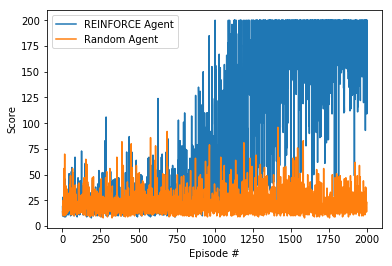

In [10]:
# the cumulative reward for REINFORCE agent and Random Agent
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(np.arange(1,len(R)+1),R,label="REINFORCE Agent")
ax.plot(np.arange(1,len(R0)+1),R0,label="Random Agent")


plt.ylabel('Score')
plt.xlabel('Episode #')
handles, labels = ax.get_legend_handles_labels()
display = (0,1)

#Create custom artists


#Create legend from custom artist/label lists
ax.legend([handle for i,handle in enumerate(handles) if i in display],
          [label for i,label in enumerate(labels) if i in display])

plt.show()